# ALeRCE API retrieval examples

Load libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os, sys

import requests
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import pandas as pd
import seaborn as sns
#from pandas.io.json import json_normalize

#from collections import OrderedDict

from astropy.time import Time
from datetime import datetime
from IPython.display import HTML

import astropy.units as u
from astropy import coordinates

#from astroquery.ned import Ned
#from astroquery.simbad import Simbad
#from astropy.time import Time

#import json

from alerce.api import AlerceAPI

#!pip install psycopg2-binary
import psycopg2

from io import StringIO

In [3]:
import time
from astropy.time import Time

In [4]:
now = Time(datetime.utcnow(), scale='utc').datetime
now_mjd = Time(datetime.utcnow(), scale='utc').mjd

# Get fresh list of SNe sent to TNS by ALeRCE

In [5]:
def dourl(searchweb, searchoptions):
    url = searchweb
    for key in searchoptions.keys():
        url = "%s&%s=%s" % (url, key, searchoptions[key])
    return url

In [6]:
def get_tns_df(searchoptions):
    urlpage = dourl(searchweb,searchoptions)
    s = requests.Session()
    response = s.get(urlpage)
    response.close()
    df = pd.read_csv(StringIO(response.text))
    urls = [f"http://alerce.online/object/{oid}" for oid in df['Disc. Internal Name']]
    df['url'] = urls
    return df

In [7]:
searchweb = "https://wis-tns.weizmann.ac.il/search?"
searchoptions = {
    "groupid[]":74,
    "num_page" : 500,  # number of rows per page
    "internal_name" : "ZTF",
    "format" : "csv",
    "display[remarks]":1,
}

In [8]:
all_alerce = []
page = 0
while True:
    print("Loading TNS page %i..." % page)
    searchoptions["page"] = page
    temp = get_tns_df(searchoptions)
    all_alerce.append(temp)
    if temp.shape[0] < 500:
        break
    page += 1
all_alerce = pd.concat(all_alerce)

Loading TNS page 0...
Loading TNS page 1...
Loading TNS page 2...


In [9]:
all_alerce.shape

(1002, 24)

In [10]:
list(all_alerce)

['ID',
 'Name',
 'RA',
 'DEC',
 'Obj. Type',
 'Redshift',
 'Host Name',
 'Host Redshift',
 'Discovering Group/s',
 'Classifying Group/s',
 'Associated Group/s',
 'Disc. Internal Name',
 'Disc. Instrument/s',
 'Class. Instrument/s',
 'TNS AT',
 'Public',
 'End Prop. Period',
 'Discovery Mag',
 'Discovery Mag Filter',
 'Discovery Date (UT)',
 'Sender',
 'Remarks',
 'Ext. catalog/s',
 'url']

In [11]:
sent = list(all_alerce["Disc. Internal Name"].values)

In [12]:
retracted = pd.read_csv("retracted.txt").oid.to_list()

### Remove retracted

In [13]:
all_alerce = all_alerce[~all_alerce["Disc. Internal Name"].isin(retracted)]

In [14]:
all_alerce.to_pickle("all_alerce.pkl")

In [15]:
classified_mask = ~(all_alerce["Classifying Group/s"].isna())

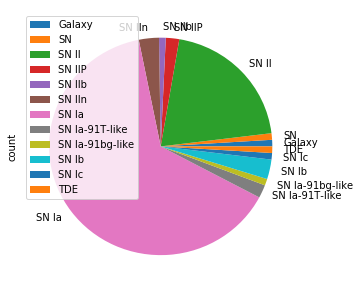

In [16]:
cl_SN, ncl_SN = np.unique(all_alerce[classified_mask]["Obj. Type"], return_counts=True)
df_SN = pd.DataFrame({"count": ncl_SN}, index=cl_SN)
df_SN.plot.pie(y="count", figsize=(5, 5))

In [17]:
all_alerce.loc[classified_mask][(all_alerce[classified_mask]["Obj. Type"] == 'SN IIb')]

ID        Name            RA           DEC Obj. Type  Redshift  \
167  44660  SN 2019pqo  15:41:30.333  +15:47:03.30    SN IIb   0.01413   

    Host Name  Host Redshift Discovering Group/s Classifying Group/s  ...  \
167  NGC 5980       0.013649       ALeRCE, ATLAS                 ZTF  ...   

    TNS AT Public End Prop. Period Discovery Mag  Discovery Mag Filter  \
167      1      1              NaN       18.6697                 r-ZTF   

     Discovery Date (UT)  Sender  Remarks Ext. catalog/s  \
167  2019-09-07 05:05:53  ALeRCE      NaN            NaN   

                                          url  
167  http://alerce.online/object/ZTF19abxqppy  

[1 rows x 24 columns]

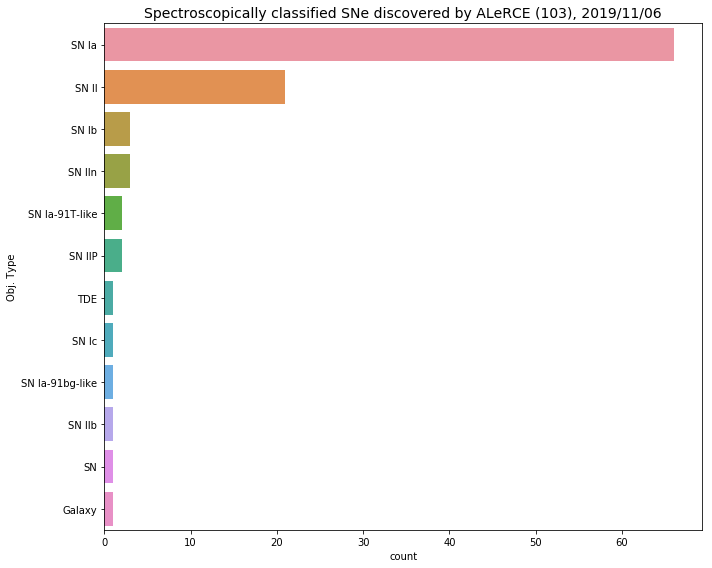

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
#sns.set(style="darkgrid")
cl, n = np.unique(all_alerce[classified_mask]["Obj. Type"], return_counts=True)
sns.countplot(ax=ax, y="Obj. Type", data=all_alerce[classified_mask], order=cl[n.argsort()[::-1]])
ax.set_title("Spectroscopically classified SNe discovered by ALeRCE (%i), %s/%02i/%02i" % 
             (classified_mask.sum(), now.year, now.month, now.day), fontsize=14)
#ax.axvline(2.5, c = 'gray')
plt.tight_layout()
plt.savefig("plots/SN_types.png")
plt.savefig("plots/SN_types.pdf")

In [19]:
classified_oids = all_alerce[classified_mask]["Disc. Internal Name"].tolist()

In [20]:
oids = [oid for oid in sent if oid not in retracted]
oids = np.array(oids, dtype = str)

# Optional, use all SNe found, not just those in TNS

In [21]:
mode="tns" #'tns' 'all'
if mode == "all":
    oids = []
    for file in os.listdir("candidates"):
        if file[-3:] == 'txt':
            for oid in open("candidates/%s" % file, 'r').readlines():
                oids.append(oid[:-1])
    oids = np.array(oids)
    oids = np.unique(oids)
    oids = [oid for oid in oids if oid not in retracted]
    oids = np.array(oids, dtype = str)
elif mode=="tns":
    oids = [oid for oid in sent if oid not in retracted]
    oids = np.array(oids, dtype = str)

# Run all these cells if you want to update the results

In [68]:
alerce = AlerceAPI()

In [69]:
import json
credentials_file = "../usecases/alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

In [70]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [71]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

tablename
7                  asassn
16                  class
8               crtsnorth
9               crtssouth
1              detections
14               features
20            features_v2
23            features_v3
21    ingestion_timestamp
0              insert_tmp
22   late_class_timestamp
3   late_probabilities_v2
24  late_probabilities_v3
11                 linear
17                 magref
18         non_detections
2                 objects
12          probabilities
13   stamp_classification
5               tax_class
4                taxonomy
6              temp_probs
19             temp_table
15                    tns
10                 xmatch

In [72]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

table                    column_name  \
0                   asassn                   ASAS-SN Name   
1                   asassn                    Other Names   
2                   asassn                           LCID   
3                   asassn                             ra   
4                   asassn                            dec   
5                   asassn                      Mean VMag   
6                   asassn                      Amplitude   
7                   asassn                         Period   
8                   asassn                           Type   
9                   asassn                            Url   
10                  asassn                      Reference   
11                  asassn                           Dist   
12                  asassn                       Parallax   
13                  asassn                 Parallax Error   
14                  asassn                           Gmag   
15                  asassn                          Bpmag   
16                  asassn                          Rpmag   
17                  asassn                           Jmag   
18                  asassn                           Hmag   
19                  asassn                           Kmag   
20                  asassn                          W1mag   
21                  asassn                          W2mag   
22                  asassn                          W3mag   
23                  asassn                          W4mag   
24                  asassn                          BP-RR   
25                  asassn                            J-K   
26                  asassn                          W1-W2   
27                  asassn                          W3-W4   
28                  asassn                 Sllk Statistic   
29                  asassn            RF Regression Score   
30                  asassn     Classification Probability   
31                  asassn                    Epoch (HJD)   
0                    class                             id   
1                    class                           name   
0                crtsnorth            Catalina_Surveys_ID   
1                crtsnorth                   Numerical_ID   
2                crtsnorth                        V_(mag)   
3                crtsnorth                  Period_(days)   
4                crtsnorth                      Amplitude   
5                crtsnorth                     Number_Obs   
6                crtsnorth                       Var_Type   
7                crtsnorth                             ra   
8                crtsnorth                            dec   
0                crtssouth                         SSS_ID   
1                crtssouth                   Numerical_ID   
2                crtssouth                             ra   
3                crtssouth                            dec   
4                crtssouth                         Period   
5                crtssouth                          V_CSS   
6                crtssouth                           Npts   
7                crtssouth                          V_amp   
8                crtssouth                           Type   
0               detections                            oid   
1               detections                         candid   
2               detections                            mjd   
3               detections                            fid   
4               detections                     diffmaglim   
5               detections                         magpsf   
6               detections                          magap   
7               detections                       sigmapsf   
8               detections                       sigmagap   
9               detections                             ra   
10              detections                            dec   
11              detections                        sigmara   
12              detections                       sigmade

In [73]:
query='''
select objects.oid, objects.firstmjd, objects.nobs, objects.meanra, objects.meandec
from objects
where objects.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
SNe = pd.read_sql_query(query, conn)
SNe.set_index('oid', inplace=True)
SNe.head()

firstmjd  nobs      meanra    meandec
oid                                                    
ZTF17aaaeqnb  58778.136979     1   19.895777  32.180523
ZTF17aabbxwa  58726.502940    10   80.039311 -17.944245
ZTF18aaavffc  58789.514595     1  187.979934  32.544452
ZTF18aaedrgt  58781.491076     2  118.184173  45.949277
ZTF18aaexyql  58785.503380     7  126.794474  28.734377

In [74]:
query='''
select oid, candid, mjd, fid, magpsf, sigmapsf, magpsf_corr, sigmapsf_corr
from detections
where detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
all_detections = pd.read_sql_query(query, conn)
all_detections.set_index('candid', inplace=True)
all_detections.head()

oid           mjd  fid     magpsf  sigmapsf  \
candid                                                                     
936169913315015012  ZTF19abiijfy  58690.169919    2  19.698338  0.136072   
936168984315015017  ZTF19abiiitl  58690.168981    2  19.884129  0.157709   
936192433315015010  ZTF19abiijfy  58690.192431    1  19.795248  0.122960   
937371221415015020  ZTF19abiovio  58691.371227    2  20.146393  0.212616   
937443201415015014  ZTF19abiovio  58691.443206    1  20.032164  0.174063   

                    magpsf_corr  sigmapsf_corr  
candid                                          
936169913315015012    19.698338       0.136072  
936168984315015017    19.884129       0.157709  
936192433315015010    19.795248       0.122960  
937371221415015020    19.115045       0.108332  
937443201415015014    18.700192       0.078293

In [75]:
query='''
select oid, fid, diffmaglim, mjd
from non_detections
where non_detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
all_non_detections = pd.read_sql_query(query, conn)
all_non_detections.set_index('mjd', inplace=True)
all_non_detections.head()

oid  fid  diffmaglim
mjd                                        
58660.232801  ZTF19abiijfy    2   20.829399
58663.190648  ZTF19abiijfy    2   20.358101
58663.211806  ZTF19abiijfy    1   20.739300
58666.171516  ZTF19abiijfy    2   19.855000
58666.209086  ZTF19abiijfy    1   20.780399

# Histogram of cadences

In [76]:
dts = []
dts_1st = []
dts_fid = []
for oid in all_detections.oid.unique():
    mask = (all_detections.oid == oid)
    times = np.sort(np.array(all_detections.loc[mask].mjd.unique()))
    if mask.sum() > 1:
        dts.append(times[1:] - times[:-1])
        dts_1st.append([times[1] - times[0]])
    for fid in [1, 2]:
        mask = (all_detections.oid == oid) & (all_detections.fid == fid)
        times = np.sort(np.array(all_detections.loc[mask].mjd.unique()))
        if mask.sum() > 1:
            dts_fid.append(times[1:] - times[:-1])
dts = np.concatenate(dts)
dts_1st = np.concatenate(dts_1st)
dts_fid = np.concatenate(dts_fid)

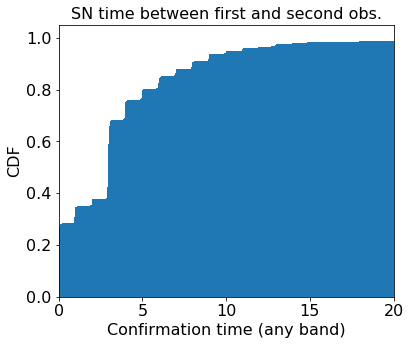

In [77]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts_1st, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Confirmation time (any band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN time between first and second obs.", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNconfirmation_any_%s.png" % mode)

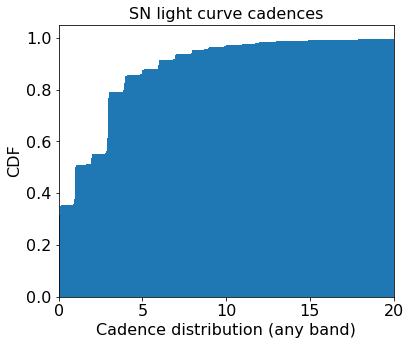

In [78]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Cadence distribution (any band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN light curve cadences", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNcadence_any_%s.png" % mode)

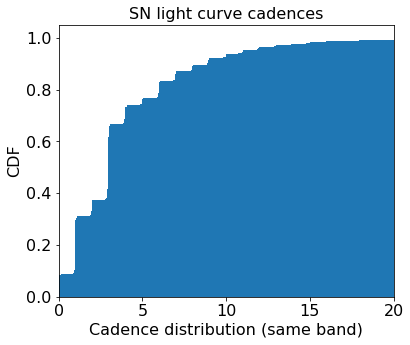

In [79]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts_fid, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Cadence distribution (same band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN light curve cadences", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNcadence_same_%s.png" % mode)

# Extract relevant features

In [80]:
nobs = []
dts = []
dt2s = []
dmags = []
dts_fid = []
dmags_fid = []
dmdt_fid = []
first_mjds = []
first_det_mags = []
max_mags = []
max_mjds = []
dt_first_max = []
dmag_first_max = []
ras = []; decs = []
for SN in oids:#["ZTF19abpsana"]:
    stats = SNe.loc[SN]
    stats.dropna(inplace=True)
    detections = all_detections[all_detections.oid == SN]
    non_detections = all_non_detections[all_non_detections.oid == SN]
    nobs.append(int(stats.nobs))
    
    
    first_det_idx = detections.mjd.idxmin()
    first_det_mjd = float(detections.loc[first_det_idx].mjd)
    first_det_fid = int(detections.loc[first_det_idx].fid)
    first_det_mag = float(detections.loc[first_det_idx].magpsf)
    first_det_mags.append(first_det_mag)
    ras.append(stats.meanra)
    decs.append(stats.meandec)
    first_mjds.append(first_det_mjd)
    max_mjds.append(detections.loc[detections.magpsf.idxmin()].mjd)
    max_mags.append(detections.loc[detections.magpsf.idxmin()].magpsf)
    dt_first_max.append(max_mjds[-1] - first_mjds[-1])
    dmag_first_max.append(first_det_mags[-1] - max_mags[-1])
    
    mask = non_detections.index < first_det_mjd
    if np.sum(mask) > 0:
        last_non_det_mjd = np.array(non_detections.index[mask]).max()
        last_non_det_mag = non_detections.loc[last_non_det_mjd].diffmaglim
        if last_non_det_mag.shape != ():
            last_non_det_mag = last_non_det_mag.unique()[0]
        dts.append(first_det_mjd - last_non_det_mjd)
        dmags.append(last_non_det_mag - first_det_mag)
    else:
        dts.append(None)
        dmags.append(None)

    mask = (non_detections.index < first_det_mjd) & (non_detections.fid == first_det_fid)
    if np.sum(mask) > 0:
        last_non_det_fid_mjd = non_detections.index[mask].max()
        last_non_det_fid_mag = non_detections.loc[last_non_det_fid_mjd].diffmaglim
        if last_non_det_fid_mag.shape != ():
            last_non_det_fid_mag = last_non_det_fid_mag.unique()[0]
        dts_fid.append(first_det_mjd - last_non_det_fid_mjd)
        dmags_fid.append(last_non_det_fid_mag - first_det_mag)
        dmdt_fid.append(dmags_fid[-1] / dts_fid[-1])
    else:
        dts_fid.append(None)
        dmags_fid.append(None)
        dmdt_fid.append(None)
    
    if nobs[-1] > 1:
        second_det_mjd = detections.mjd[detections.mjd > first_det_mjd].min()
        dt2s.append(second_det_mjd - last_non_det_mjd)
    else: 
        dt2s.append(None)
        
    print(SN, nobs[-1], dts[-1], dt2s[-1], dmags[-1], dmags_fid[-1], dt_first_max[-1])

/home/fforster/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:4784: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


ZTF17aaaeqnb 1 0.0029050999000901356 None 0.25976943969730115 0.25976943969730115 0.0
ZTF17aabbxwa 10 0.02222219979739748 23.000011599899153 0.6825332641602024 1.0616321563721023 44.990081000098144
ZTF18aaavffc 1 2.9877083000028506 None -0.5736446380615021 -0.5736446380615021 0.0
ZTF18aaedrgt 2 3.001377300002787 10.019965300001786 0.9907302856446023 0.9907302856446023 0.0
ZTF18aaexyql 7 5.999120300097275 6.021284699898388 1.5943393707275 0.9637393951416016 5.999236099902191
ZTF18aahxxtv 1 3.9383101999992505 None -0.6243667602539027 -0.6243667602539027 0.0
ZTF18aaiubrl 2 13.996574100099679 18.99467599990021 -0.7163162231444993 -2.671716690063498 0.0
ZTF18aaiwhxd 3 3.002662099999725 8.000682899801177 0.7878761291502983 0.7878761291502983 7.997835599802784
ZTF18aaixhal 1 0.016793900103948545 None 0.2839984893799006 -3.5672016143799006 0.0
ZTF18aajeaby 8 2.9782408000028227 5.978333400002157 0.1443805694580007 0.1443805694580007 3.000092599999334
ZTF18aajxumx 9 1.9946528001019033 9.94847219

ZTF19ablsehq 1 0.03180560010514455 None 1.7251586914062997 1.8468589782714986 0.0
ZTF19ablumqx 1 0.026504699904762674 None 1.4788093566894993 1.7142086029052983 0.0
ZTF19ablwlib 1 3.041562499900465 None 0.8039054870606002 0.8039054870606002 0.0
ZTF19ablxhnk 1 2.966099499797565 None 0.05158996582029829 -0.047609329223700314 0.0
ZTF19ablybsj 1 1.9418287000007695 None 0.33784103393560017 0.33784103393560017 0.0
ZTF19ablytdf 2 3.059953700103506 6.059050899806607 0.1085987091064986 -0.12270164489740054 2.999097199703101
ZTF19ablzgqq 2 0.03180560009786859 29.970520900198608 0.5323600769043004 0.36105918884280186 0.0
ZTF19ablzhqc 11 7.138101900200127 29.865821799896366 0.561285018920902 -0.1371154785156996 25.726492999594484
ZTF19ablzhwr 1 2.9405323999963002 None 1.0078544616699006 0.7567539215087997 0.0
ZTF19ablzyvp 1 0.9789930998013006 None 1.1154956817627024 1.0079956054687997 0.0
ZTF19abmmvds 1 4.956493099794898 None 1.4896678924561009 1.4896678924561009 0.0
ZTF19abmolyr 49 0.073946699798

ZTF19abpvhki 11 3.0828935000972706 6.034085600200342 0.5014667510987003 0.7477664947509979 11.999548600106209
ZTF19abpxnbz 2 2.8776041001983685 6.897465300098702 -0.09740066528319957 0.28050041198730113 0.0
ZTF19abpxntu 6 2.9162500000966247 6.922175899897411 -0.5020885467530007 -2.6132888793945988 7.028900399796839
ZTF19abpxuaa 3 4.021388899898739 7.002071699898806 -0.4242973327637003 -0.4242973327637003 2.980682800000068
ZTF19abpxxrd 2 2.938206000100763 13.920682899995882 -2.1636543273925994 -0.3265533447266016 0.0
ZTF19abpyjqx 6 6.002256899802887 9.990729099801683 0.022935867309499258 0.022935867309499258 10.011238400402362
ZTF19abpzvae 11 3.0215162000022247 6.126134300000558 0.6027679443360014 0.6027679443360014 9.103136599995196
ZTF19abqanpy 38 2.9599190000008093 2.9981482001021504 0.4505977630615021 0.20359802246090197 20.037685200099077
ZTF19abqbzal 1 1.9747684999019839 None 2.8436450958250994 3.1602458953856996 0.0
ZTF19abqgxla 18 None 2.306678200198803 None None 9.0162152996999

ZTF19abtrgyl 12 2.931874999900174 5.906377299797896 0.3240203857422017 0.3240203857422017 7.984652799998003
ZTF19abtriyg 18 2.931874999900174 5.906377299797896 -0.22165870666499998 -0.22165870666499998 13.981770799895457
ZTF19abtsiyh 2 5.963703700101178 8.963182800202048 -0.6083202362059978 -2.4298191070556 0.0
ZTF19abtslqm 20 4.981018600097741 8.015821800101548 1.5061969757080007 1.0924968719481996 3.0348032000038074
ZTF19abtsnyy 35 2.971111099803238 2.9945716998990974 -0.3015480041504013 -0.3015480041504013 21.981712900094863
ZTF19abtsskw 2 3.0597684997992474 6.016689800198947 -4.110774993896499 -0.7952747344970987 0.0
ZTF19abttmpt 1 0.024050900203292258 None 0.3515644073485973 -0.6274356842041016 0.0
ZTF19abttqpp 1 0.025405000094906427 None 0.5042343139649006 -0.45146560668939983 0.0
ZTF19abttrxq 25 2.998599500002456 5.977858799997193 -0.8718662261962997 -0.888565063476598 55.95824080010061
ZTF19abttstb 12 0.025856499902147334 3.027037099796871 0.0792465209960973 -0.8109531402588033

ZTF19abwstko 4 0.06855329979589442 2.9973843001935165 0.6682567596436009 0.9868564605712997 2.928831000397622
ZTF19abwswjw 3 0.07541670009959489 3.0444792001944734 0.48817253112790127 0.8252735137938991 5.98458329999994
ZTF19abwswzb 46 0.04164349980419502 3.0320486002019607 1.978450775146399 2.098951339721598 14.735173600296548
ZTF19abwsxwh 1 0.050439800004824065 None 0.7087993621825994 0.8380985260010014 0.0
ZTF19abwtbdd 1 4.92107639999449 None -0.03807067871089842 -0.2096710205077983 0.0
ZTF19abwtgic 20 None -14.022187500006112 None None 49.896111099900736
ZTF19abwtgin 3 None -13.979340300204058 None None 0.04284719980205409
ZTF19abwting 5 6.97666660019604 7.019120299897622 0.5786476135253977 0.5786476135253977 6.063611099903937
ZTF19abxdnhr 15 2.9699189997991198 3.0372916999986046 -2.6427326202393004 -1.7718334197998011 8.997500000099535
ZTF19abxdnzt 18 2.950381899900094 3.018587900005514 -0.7685470581055007 -0.8058471679687997 13.002372700204432
ZTF19abxdpwz 36 1.9745485999956145 1

ZTF19abyzpsh 1 2.938217599905329 None 1.7859401702881001 1.7859401702881001 0.0
ZTF19abyzumy 1 2.95188649980264 None 2.138259887695302 1.7552585601806996 0.0
ZTF19abyzuos 18 3.0037732000055257 6.003136600003927 -0.12459182739259944 0.10690879821780186 15.034664299797441
ZTF19abyzvwf 12 8.949212899999111 11.960705999801576 0.7932395935058985 0.7932395935058985 6.017476900000474
ZTF19abzfdee 3 2.8573727000984945 6.867465299801552 -0.8106727600096981 -0.25087165832519887 4.010092599703057
ZTF19abzfeha 5 2.863402799805044 6.879212900101265 -0.7775802612304012 0.12991905212409804 7.018726800095465
ZTF19abzffgo 7 6.040937499805295 9.981782399801887 -0.347587585449201 -0.09638786315910153 6.940196700394154
ZTF19abzffsj 3 2.9990856000003987 6.009664299803262 -0.36795616149899857 -0.36795616149899857 6.141261599899735
ZTF19abzfmak 15 2.890856400197663 6.889722200197866 -0.6655483245849005 -0.23244857788079898 16.98521990000154
ZTF19abzfwbw 1 1.9691204000992002 None -0.5837059020995987 -0.806707

ZTF19acakfzp 1 0.9730902998999227 None -0.20320892333979756 -0.596408843994098 0.0
ZTF19acamaoi 6 5.903680600000371 5.9322454001012375 -0.915060043335 -0.09526062011719816 0.9878702997957589
ZTF19acamfpr 1 2.9156712999974843 None 0.390625 -0.039575576782201694 0.0
ZTF19acamhlw 7 5.91518509999878 5.938576300199202 -1.0358467102050994 -0.6616477966308985 8.026793999997608
ZTF19acamkpb 1 0.9329050999003812 None -0.20293045043939983 -0.20293045043939983 0.0
ZTF19acamlgj 2 2.900544000098307 2.9244097999981022 -0.5268135070800994 -1.0267143249512003 0.0
ZTF19acammiy 6 2.9005440002001706 2.9248494998028036 -0.5447521209716015 -1.2648525238037003 15.083391199805192
ZTF19acampey 1 2.902812500098662 None -0.6340427398681001 -1.4455432891844993 0.0
ZTF19acamppc 1 2.902812500098662 None -0.369527816772397 -1.1051273345946981 0.0
ZTF19acamrvh 3 0.9369674998961273 0.9612847001990303 -0.060329437255898455 -0.060329437255898455 0.0
ZTF19acamsrp 1 2.9156135001030634 None -0.504442214965799 -1.425342559

ZTF19acbodbr 2 0.058611100204871036 7.060219899802178 0.06772041320800071 -0.20257949829099786 0.0
ZTF19acboidj 1 5.029398200204014 None 0.11862182617189987 -0.31057929992680045 0.0
ZTF19acboiyx 6 8.00136570000177 9.995127300004242 0.1626701354980007 0.06697082519529829 17.002580999898782
ZTF19acbokgt 1 0.046053300000494346 None 0.07211303710939987 -0.3901863098144993 0.0
ZTF19acbolha 3 0.0009028002023114823 1.9783681000990327 0.18899536132810013 0.18899536132810013 0.0
ZTF19acbooqd 1 7.043576400203165 None 0.26997947692879976 -0.5181217193603018 0.0
ZTF19acbopaj 1 7.043576400203165 None 0.4087753295899006 -0.46152496337889914 0.0
ZTF19acborda 2 8.003564800201275 36.99978009989718 -0.2725372314452983 -0.06153678894050074 0.0
ZTF19acbpdro 3 10.999374999897555 21.980544000201917 1.078294754028299 1.078294754028299 10.981169000304362
ZTF19acbpjqd 6 9.86709490010253 9.951979200006463 0.08715248107910156 0.08715248107910156 5.995000000097207
ZTF19acbpnii 11 2.930069400194043 11.908807799896

ZTF19accsmmd 1 2.976296300003014 None 1.2346305847167969 0.7550296783446981 0.0
ZTF19acctjbv 2 11.966840300003241 11.975590300004114 2.8200035095214986 2.8200035095214986 0.0
ZTF19acctjpf 1 0.00873840010171989 None -0.23406791687009942 -0.14046859741209872 0.0
ZTF19acctjqn 1 0.008738399999856483 None -0.29681015014650214 -0.2027091979980007 0.0
ZTF19acctkwy 2 2.9731713000001037 16.958530099800555 0.13368225097659803 -1.18971824646 13.985358799800451
ZTF19acctlcg 1 16.97837970010005 None 0.8537197113037003 0.7574195861816015 0.0
ZTF19acctlim 5 11.986169000003429 15.98049770000216 1.0950946807861008 0.5600929260254013 11.000266199895123
ZTF19acctlmx 1 11.98935180020635 None 0.6154289245605007 0.11832809448240056 0.0
ZTF19acctlrh 1 13.989467600200442 None 0.4290618896483984 -1.1570396423340021 0.0
ZTF19acctqnk 5 2.98677090019919 9.970185199999833 0.08664894104009946 -0.030351638793899127 12.990231399897311
ZTF19accuxwo 1 3.976863400101138 None 0.084276199340799 0.40277671813960225 0.0
ZTF

ZTF19aceshib 11 1.0926041997954599 2.947893599899544 -0.2215061187744034 -0.4775066375733026 14.882592600304633
ZTF19acetvuq 5 0.8978355998988263 4.898622700202395 -0.7926635742187003 -0.7926635742187003 0.0
ZTF19acetvyb 6 2.980266200094775 2.9908448999995016 0.049806594848700314 0.049806594848700314 7.016655100102071
ZTF19acetxvq 37 0.9707407000023522 1.9709259000010206 -0.586086273193402 -0.3168869018555007 11.02702549980313
ZTF19acetyox 1 0.9706250000963337 None -0.6275558471680007 -0.7186565399169993 0.0
ZTF19acetypv 1 0.9706250000963337 None -0.6644668579100994 -0.6714668273925 0.0
ZTF19acewdna 1 None None None None 0.0
ZTF19acewhhp 2 2.913900500003365 5.909444500000973 -0.893539428710902 -0.893539428710902 0.0
ZTF19acewhje 2 10.998900499900628 16.998530099896016 0.5991497039795028 0.8015499114990021 0.0
ZTF19acewuwn 10 2.9383564999952796 5.935694400097418 0.12107849121089842 0.12107849121089842 16.909004599801847
ZTF19acexijn 9 2.8346528000038234 2.8960069999011466 0.490570068359

ZTF19acgonwy 13 6.9605439998049405 7.002280100103235 0.8116035461425994 0.8116035461425994 4.001956000000064
ZTF19acgospv 1 2.0319908000019495 None 0.11654472351070311 -0.11045455932619674 0.0
ZTF19acgotoe 1 1.004791699895577 None -0.02799415588379972 -0.02799415588379972 0.0
ZTF19acgouje 4 6.975474499893608 13.869930600099906 -0.21271133422850141 -0.21271133422850141 9.886134300002595
ZTF19acgphsf 1 2.9958796002028976 None -0.7158260345458984 -0.7158260345458984 0.0
ZTF19acgpkye 2 None 2.980891200102633 None None 3.986157400002412
ZTF19acgpuua 1 2.9206712999002775 None -0.0373573303222976 -0.0373573303222976 0.0
ZTF19acgpzsb 1 3.0200115999032278 None 0.6409912109375 -0.08910942077639916 0.0
ZTF19acgqros 1 0.0279861000017263 None 0.07612609863280184 0.0793266296387003 0.0
ZTF19acgqsov 9 0.02797459989960771 4.026111099803529 0.34473228454589844 0.5492305755614986 9.998599499900592
ZTF19acgqsqa 1 1.0001967998978216 None -0.08836746215819957 -0.08836746215819957 0.0
ZTF19acgrbeb 6 4.10644

ZTF19acjljwl 1 2.8929977001971565 None -0.44974327087399857 -0.44974327087399857 0.0
ZTF19acjrknv 2 1.977060199897096 2.9924073998990934 -0.026161193847599407 -0.7980613708495987 0.0
ZTF19acjtgkj 2 8.894502300201566 13.020856399904005 0.571363449096701 0.571363449096701 4.126354099702439
ZTF19acjtgxj 3 2.85939819990017 5.870243100100197 0.6085872650146023 0.05298805236819959 3.010844900200027
ZTF19acjtkha 6 2.98070599980565 3.005370299804781 2.2371273040771023 2.2371273040771023 5.9887152001974755
ZTF19acjtlxe 3 2.9841087999011506 2.995300900096481 0.8581428527831996 0.8581428527831996 4.015972199900716
ZTF19acjtplk 1 4.0243403002023115 None -0.4637737274169993 0.43222618103019883 0.0
ZTF19acjtpmm 2 4.002858800202375 8.011805599802756 0.8277549743651988 0.8277549743651988 4.0089467996003805
ZTF19acjtpps 1 4.002847200201359 None 0.11530113220220173 0.11530113220220173 0.0
ZTF19acjtpqd 1 4.002847200201359 None 0.5530376434325994 0.5530376434325994 0.0
ZTF19acjutrw 1 0.10135419989819638 N

In [81]:
len(oids), len(nobs), len(dts), len(dt2s), len(dmags), len(dts_fid), len(dmags_fid), len(first_mjds), len(dt_first_max)

(1181, 1181, 1181, 1181, 1181, 1181, 1181, 1181, 1181)

In [82]:
df = {'oid': oids, 'nobs': nobs, 'dt': dts, 'dt2': dt2s, 'dmag': dmags, 'dt_fid': dts_fid, 
      'dmag_fid': dmags_fid, 'first_mjd': first_mjds, 'first_det_mag': first_det_mags, 
      'ra': ras, 'dec': decs, 'dt_first_max': dt_first_max, 'dmag_first_max': dmag_first_max,
      'mag_at_max': max_mags, 'dmdt_fid': dmdt_fid}#      }
df = pd.DataFrame(df)
df.head()

oid  nobs        dt        dt2      dmag     dt_fid  dmag_fid  \
0  ZTF17aaaeqnb     1  0.002905        NaN  0.259769   0.002905  0.259769   
1  ZTF17aabbxwa    10  0.022222  23.000012  0.682533   3.000255  1.061632   
2  ZTF18aaavffc     1  2.987708        NaN -0.573645   2.987708 -0.573645   
3  ZTF18aaedrgt     2  3.001377  10.019965  0.990730   3.001377  0.990730   
4  ZTF18aaexyql     7  5.999120   6.021285  1.594339  16.028287  0.963739   

      first_mjd  first_det_mag          ra        dec  dt_first_max  \
0  58778.136979      20.018631   19.895777  32.180523      0.000000   
1  58726.502940      19.097267   80.039311 -17.944245     44.990081   
2  58789.514595      18.946445  187.979934  32.544452      0.000000   
3  58781.491076      18.792669  118.184173  45.949277      0.000000   
4  58785.503380      18.634060  126.794474  28.734377      5.999236   

   dmag_first_max  mag_at_max   dmdt_fid  
0        0.000000   20.018631  89.418419  
1        0.701225   18.396042   0.353847  
2        0.000000   18.946445  -0.192002  
3        0.000000   18.792669   0.330092  
4        0.354803   18.279257   0.060127

In [83]:
df.to_pickle("summary_%s.pkl" % mode)

# Start from here if you want to use available results

In [84]:
mode = 'all' #'tns'
df = pd.read_pickle("summary_%s.pkl" % mode)
df.set_index("oid", inplace=True)
df.head()

nobs        dt        dt2      dmag     dt_fid  dmag_fid  \
oid                                                                      
ZTF17aaaeqnb     1  0.002905        NaN  0.259769   0.002905  0.259769   
ZTF17aabbxwa    10  0.022222  23.000012  0.682533   3.000255  1.061632   
ZTF18aaavffc     1  2.987708        NaN -0.573645   2.987708 -0.573645   
ZTF18aaedrgt     2  3.001377  10.019965  0.990730   3.001377  0.990730   
ZTF18aaexyql     7  5.999120   6.021285  1.594339  16.028287  0.963739   

                 first_mjd  first_det_mag          ra        dec  \
oid                                                                
ZTF17aaaeqnb  58778.136979      20.018631   19.895777  32.180523   
ZTF17aabbxwa  58726.502940      19.097267   80.039311 -17.944245   
ZTF18aaavffc  58789.514595      18.946445  187.979934  32.544452   
ZTF18aaedrgt  58781.491076      18.792669  118.184173  45.949277   
ZTF18aaexyql  58785.503380      18.634060  126.794474  28.734377   

              dt_first_max  dmag_first_max  mag_at_max   dmdt_fid  
oid                                                                
ZTF17aaaeqnb      0.000000        0.000000   20.018631  89.418419  
ZTF17aabbxwa     44.990081        0.701225   18.396042   0.353847  
ZTF18aaavffc      0.000000        0.000000   18.946445  -0.192002  
ZTF18aaedrgt      0.000000        0.000000   18.792669   0.330092  
ZTF18aaexyql      5.999236        0.354803   18.279257   0.060127

### Histogram of UT times of first detection

In [85]:
df["first_UT"] = df.apply(lambda row: float(Time(row["first_mjd"], format='mjd').datetime.hour) + float(Time(row["first_mjd"], format='mjd').datetime.minute) / 60., axis=1)

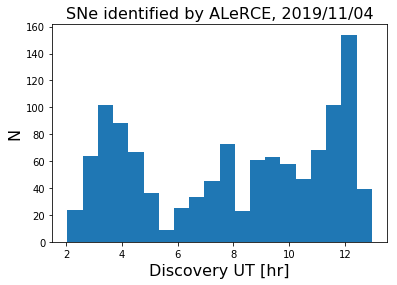

In [86]:
fig, ax = plt.subplots()
ax.hist(df.first_UT, bins=20)
ax.set_xlabel("Discovery UT [hr]", fontsize=16)
ax.set_ylabel("N", fontsize=16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/discovery_UT.png")


### Histogram of RA DEC coordinates

In [87]:
import ephem

In [88]:
df["ecl_lat"] = df.apply(lambda row: np.rad2deg(ephem.Ecliptic(ephem.Equatorial('%s' % (row.ra / 15.), '%s' % row.dec, epoch=ephem.J2000)).lat), axis=1)

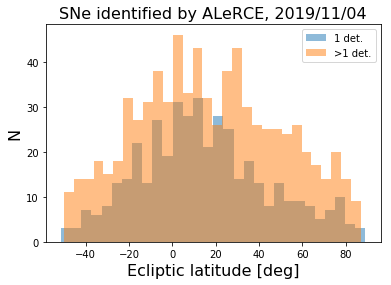

In [89]:
fig, ax = plt.subplots()
mask = df.nobs == 1
ax.hist(df.ecl_lat[mask], bins=30, label="1 det.", alpha=0.5)
ax.hist(df.ecl_lat[~mask], bins=30, label=">1 det.", alpha=0.5)
ax.legend()
ax.set_xlabel("Ecliptic latitude [deg]", fontsize=16)
ax.set_ylabel("N", fontsize=16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/discovery_ecl_lat.png")


### Cumulative distribution of MJD times

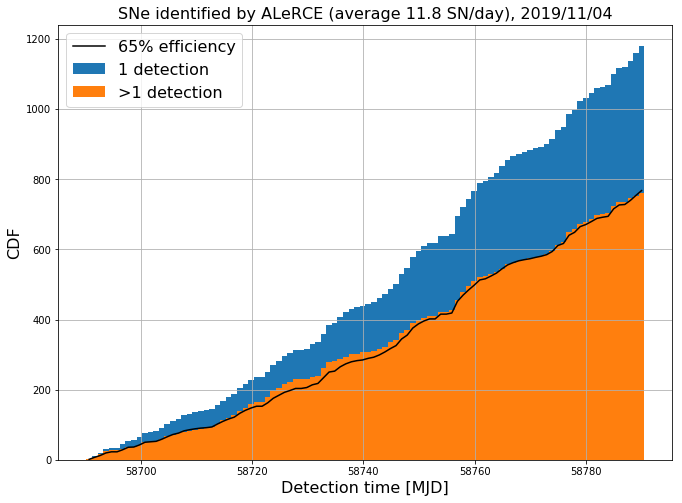

In [90]:
fig, ax = plt.subplots(figsize = (11, 8))
x, y, _ = ax.hist(df.first_mjd, bins = np.linspace(df.first_mjd.min(), df.first_mjd.max(), df.first_mjd.max() - df.first_mjd.min() + 1), cumulative = True, label="1 detection")
ax.set_xlabel("Detection time [MJD]", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS (average %.1f SN/day), %i/%02i/%02i" % 
                 (len(oids) / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE (average %.1f SN/day), %i/%02i/%02i" % 
                 (df.shape[0] / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day), fontsize = 16)
efficiency = 0.65
plt.savefig("plots/firstmjd.png")
ax.hist(df[df.nobs > 1].first_mjd, bins = np.linspace(df.first_mjd.min(), df.first_mjd.max(), df.first_mjd.max() - df.first_mjd.min() + 1), cumulative = True, label=">1 detection")
ax.plot((y[:-1] + y[1:]) / 2, x * efficiency, c = 'k', label="%i%% efficiency" % (efficiency * 100.))
ax.legend(fontsize=16)
plt.savefig("plots/firstmjd_efficiency_%s.png" % mode)
plt.savefig("plots/firstmjd_efficiency_%s.pdf" % mode)

# Do mosaic of stamps

In [91]:
def plot_stamp(self, oid, candid=None):
    'plot stamp in a notebook given oid. It uses IPython HTML.'

    # if candid is None, get minimum candid                                                                                                                                                                    
    if candid is None:
        candid = min(self.get_detections(oid).index)

    science = "http://avro.alerce.online/get_stamp?oid=%s&candid=%s&type=science&format=png" % (oid, candid)
    images="""                                                                                                                                                                                                 
    <div>ZTF oid: %s, candid: %s</div>                                                                                                                                                                         
    <div>&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                                                        
    Science                                                                                                                                                                                                    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                   
    Template                                                                                                                                                                                                   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                   
    Difference                                                                                                                                                                                                 
    <div class="container">                                                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    </div>                                                                                                                                                                                                     
    """ % (oid, candid, science, science.replace("science", "template"), science.replace("science", "difference"))
    display(HTML(images))


# Distribution of number of detections

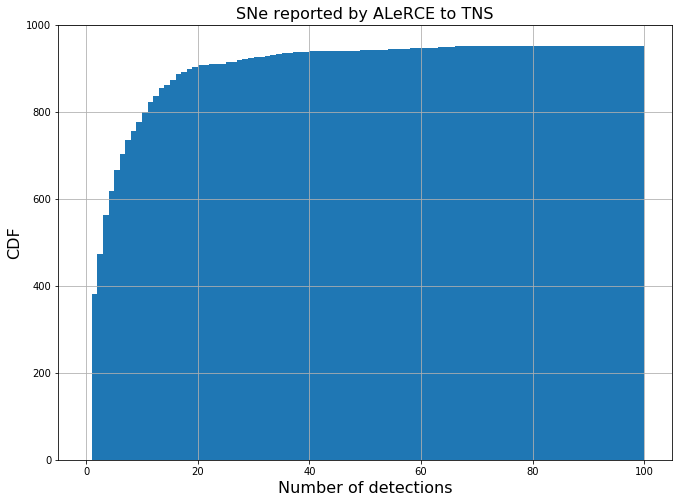

In [47]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.nobs, bins = np.linspace(0, df.nobs.max(), df.nobs.max() + 1), cumulative = True)
ax.set_xlabel("Number of detections", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/nobs.png")

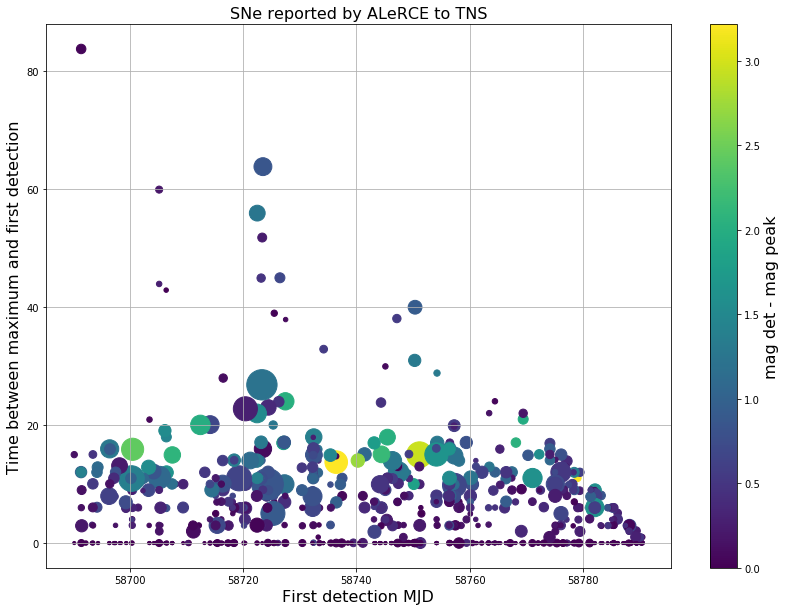

In [48]:
fig, ax = plt.subplots(figsize = (14, 10))
sc = ax.scatter(df.first_mjd, df.dt_first_max, s = 10 * df.nobs, c = df.dmag_first_max)
cbar = fig.colorbar(sc)
cbar.set_label("mag det - mag peak", fontsize=16)
ax.set_xlabel("First detection MJD", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("Time between maximum and first detection", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/dt_first_max_firstMJD.png")

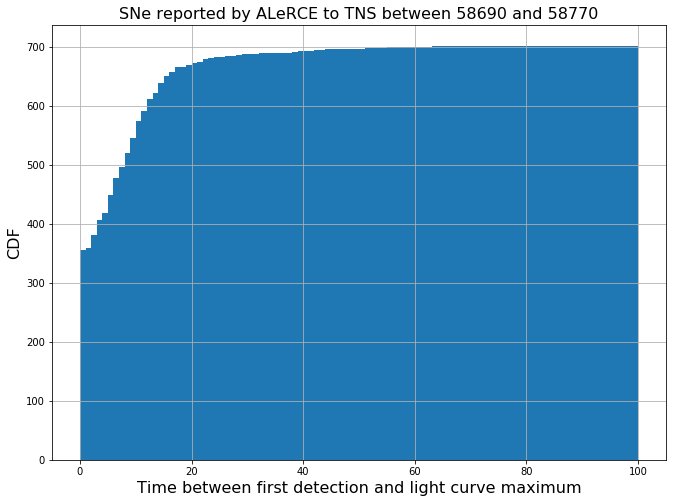

In [49]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.dt_first_max[df.first_mjd < df.first_mjd.max() - 20], bins = np.linspace(0, df.nobs.max(), df.nobs.max() + 1), cumulative = True)
ax.set_xlabel("Time between first detection and light curve maximum", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS between %i and %i" % (df.first_mjd.min(), df.first_mjd.max() - 20), fontsize = 16)
plt.savefig("plots/dt_first_mag.png")

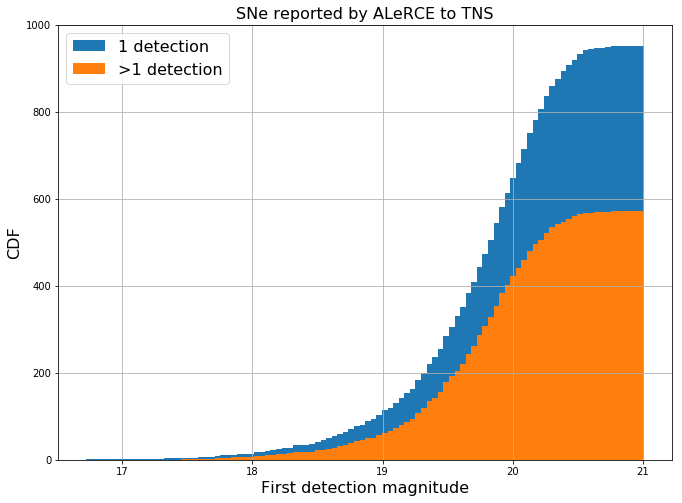

In [50]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1), cumulative = True, label="1 detection")
ax.hist(df[df.nobs > 1].first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1), cumulative = True, label=">1 detection")
ax.legend(fontsize=16)
ax.set_xlabel("First detection magnitude", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/mags.png")

952 SNe reported (excluding 21 retracted)
Average number of detections: 9
Median number of detections: 6
Fraction of candidates with >1 detections: 0.600840
SNe with time between 1st detection and last non-detection < 1 day: 130
SNe with time between 2nd detection and last non-detection < 1 day: 25
Median time between 1st detection and last non-detection:  nan [days]
Median time between 2nd detection and last non-detection: 6.04 [days]


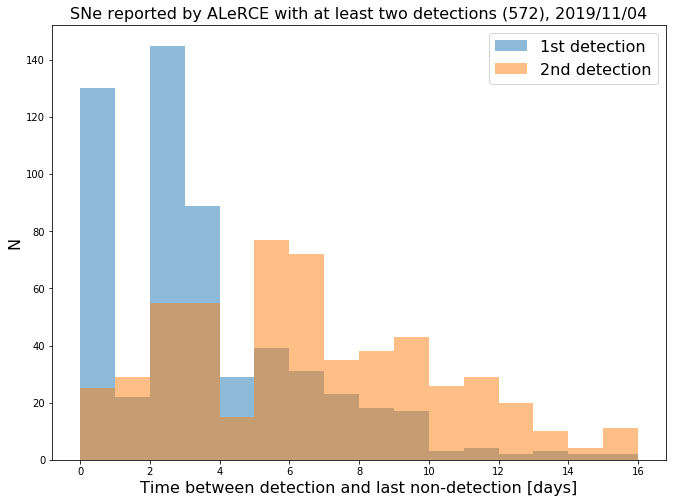

In [51]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.dt[df.nobs > 1], alpha = 0.5, bins = np.linspace(0, 16, 17), label = "1st detection" )
ax.hist(df.dt2[df.nobs > 1], alpha = 0.5, bins = np.linspace(0, 16, 17), label = "2nd detection")
ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_ylabel("N", fontsize = 16)
ax.legend(fontsize = 16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/TimeSinceDetection_%s.png" % mode)
plt.savefig("plots/TimeSinceDetection_%s.pdf" % mode)

# Show number of SNe with a lower non-detection in the same filter within the last 25 hr

Index(['ZTF19abvdgqo', 'ZTF19abueupg'], dtype='object', name='oid')


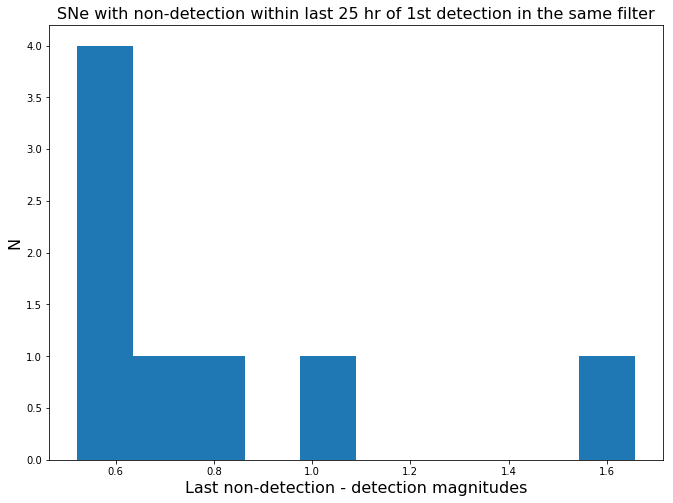

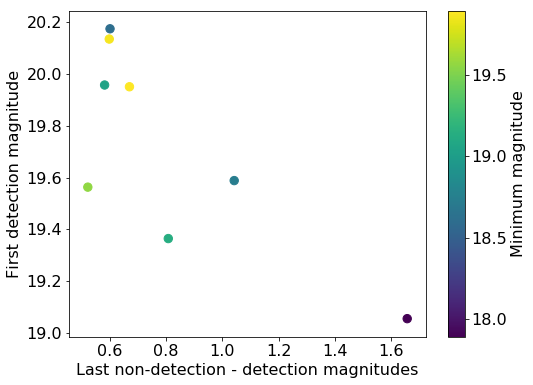

In [52]:
fig, ax = plt.subplots(figsize = (11, 8))
lasthr = 25.
mask = (df.dmag_fid.notna())  & (df.dmag_fid > 0.5) & (df.dt_fid <= lasthr / 24.) & (df.nobs > 1)
ax.hist(df.dmag_fid[mask], alpha = 1, bins=10)# cumulative=True)#,
        #label = "%s SNe @ %i/%02i/%02i" % (mask.sum(), now.year, now.month, now.day))#, cumulative=True)
#ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
#print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
#print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
#print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
#print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
#print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
#print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
#print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
#print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("N", fontsize = 16)
ax.set_title("SNe with non-detection within last %i hr of 1st detection in the same filter" % (lasthr), fontsize = 16)
#ax.legend(fontsize=16, loc = 1)
plt.savefig("plots/Deltamag.png")
plt.savefig("plots/Deltamag.pdf")
print(df.loc[mask & (df.dmag_fid > 1)].index)


fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df.dmag_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)
cbar = fig.colorbar(sc, ticks =[18, 18.5, 19, 19.5, 20])
cbar.set_label('Minimum magnitude', fontsize=16)
cbar.ax.tick_params(which='major',labelsize=16)
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("First detection magnitude", fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/mag_dmag.png")

for oid in mask[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))

12


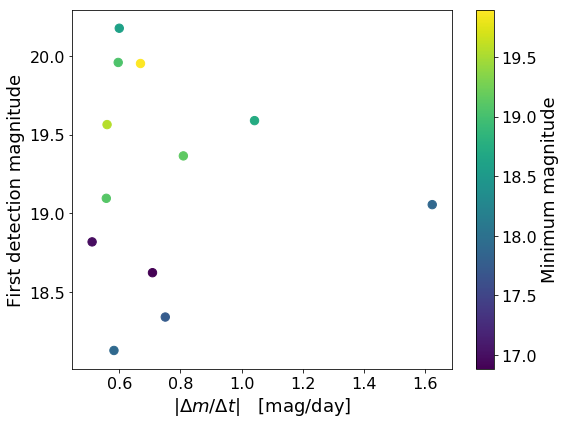

In [53]:
mask =  (df.dmdt_fid.notna()) & (df.dmdt_fid > 0.5) & (df.dmdt_fid < 20) & (df.dmag_fid > 0.5)  & (df.nobs>1)
print(mask.sum())

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df.dmdt_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)
cbar = fig.colorbar(sc)#, ticks =[17, 17.18, 18.5, 19, 19.5, 20])
cbar.set_label('Minimum magnitude', fontsize=18)
cbar.ax.tick_params(which='major',labelsize=16)
ax.set_xlabel(r"$|\Delta m/ \Delta t|$   [mag/day]", fontsize = 18)
ax.set_ylabel("First detection magnitude", fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig("plots/dmdt.png")

for oid in mask[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))

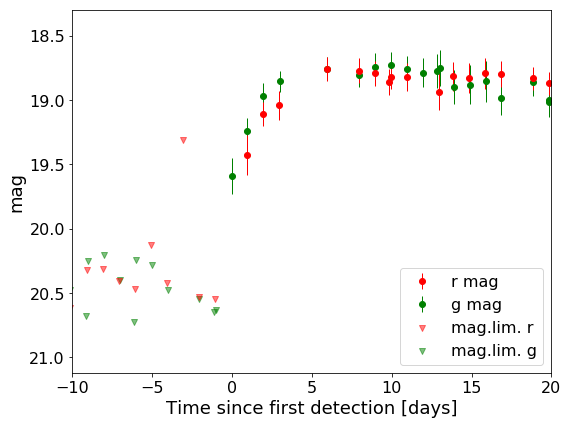

In [54]:
oid = 'ZTF19abueupg'#'ZTF19abvdgqo'
det = alerce.get_detections(oid)
nondet = alerce.get_non_detections(oid)
fig, ax = plt.subplots(figsize=(8,6))
colors = {1: 'g', 2: 'r'}
mjd0 = det.mjd.min()
for fid in [1, 2]:
    mask = det.fid == fid
    ax.errorbar(det.mjd[mask] - mjd0, det.magpsf[mask], yerr=det.sigmapsf[mask], marker='o', lw=0, elinewidth=1, c=colors[fid], label="%s mag" % colors[fid])
    mask = (nondet.fid == fid) & (nondet.index < det.mjd.min())
    ax.scatter(nondet.index[mask] - mjd0, nondet.diffmaglim[mask], marker='v', c=colors[fid], alpha=0.5, label="mag.lim. %s" % colors[fid])
ax.set_ylim(ax.get_ylim()[1], 18.3)
ax.set_xlim(-10, 20)
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.tick_params(axis='y', which='major', labelsize=16)
ax.set_xlabel("Time since first detection [days]", fontsize=18)
ax.set_ylabel("mag", fontsize=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=16, loc=4)
plt.tight_layout()
plt.savefig("BestSN.png")

# Find distribution of time between detection and 5th detection in the same band

In [55]:
mask = (df.nobs > 5)
dt_5th = {}
for oid in df[mask].index:
    mask = all_detections.oid == oid
    for fid in all_detections[mask].fid.unique():
        mask = (all_detections.oid == oid) & (all_detections.fid == fid)
        if mask.sum() == 0:
            continue
        fid_mjds = all_detections[mask].mjd.values
        if len(fid_mjds) > 4:
            if oid in dt_5th.keys():
                dt_5th[oid] = min(dt_5th[oid], fid_mjds[4] - df.loc[oid].first_mjd)
            else:
                dt_5th[oid] = fid_mjds[4] - df.loc[oid].first_mjd

3.9996486848067434
13.145630799899664
27.39467473998701


232

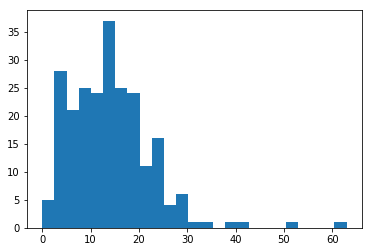

In [56]:
fig, ax = plt.subplots()
ax.hist(dt_5th.values(), bins=25)
print(np.percentile(np.array(list(dt_5th.values())), 5))
print(np.median(np.array(list(dt_5th.values()))))
print(np.percentile(np.array(list(dt_5th.values())), 95))
len(dt_5th)

In [57]:
mask = (df.nobs > 5) & (df.dmag_fid > 0) & (df.dt_fid <= lasthr / 24.)
ax.hist(df.dmag_fid[mask].dropna(), alpha = 0.5, bins=20, label = "%s SNe @ %i/%02i/%02i" % (mask.sum(), now.year, now.month, now.day))
#ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
#print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
#print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
#print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
#print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
#print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
#print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
#print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
#print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("N", fontsize = 16)
ax.set_title("Rising SNe reported by ALeRCE, non-det. within last %i hr of 1st det. in same filter" % (lasthr), fontsize = 16)
ax.legend(fontsize=16, loc = 1)
plt.savefig("plots/Deltamag.png")
plt.savefig("plots/Deltamag.pdf")
print(df.loc[mask & (df.dmag_fid > 1)].index)

Index(['ZTF19abvdgqo', 'ZTF19abueupg'], dtype='object', name='oid')


<Figure size 432x288 with 0 Axes>

In [58]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.models import ColumnDataSource, OpenURL, TapTool

output_notebook()

Loading BokehJS ...

In [59]:
df["nobs_t"] = 5 + df.nobs
df["dmdt"] = df.dmag_fid / df.dt_fid

In [60]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 800,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://dev.alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

color_col = 'first_mjd'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df.first_mjd.min(), high=df.first_mjd.max())

x_col = 'dt_fid'
y_col = 'dmag_fid'
size_col = 'nobs_t'
p.circle(
    x_col,
    y_col,
    source = df,
    color = mapper,
    size = size_col,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (x_col, y_col, size_col, color_col))
show(p)


In [61]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 1000,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

color_col = 'dmag_first_max'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df.dmag_first_max.min(), high=df.dmag_first_max.max())


x_col = 'first_mjd'
y_col = 'dt_first_max'
size_col = 'nobs_t'
p.circle(
    x_col,
    y_col,
    source = df,
    color = mapper,
    size = size_col,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (y_col, x_col, size_col, color_col))
show(p)


In [62]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 800,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://dev.alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

#sc = ax.scatter(df.dmdt_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)

mask =  (df.dmdt_fid.notna()) & (df.dmdt_fid > 0.2) & (df.dmdt_fid < 20) & (df.dmag_fid > 0.5)  & (df.nobs>1)
color_col = 'mag_at_max'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df[mask][color_col].min(), high=df[mask][color_col].max())

x_col = 'dmdt_fid'
y_col = 'first_det_mag'
size_col = 'dmag_first_max'
p.circle(
    x_col,
    y_col,
    source = df.loc[mask],
    color = mapper,
    size = 20,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (x_col, y_col, size_col, color_col))
show(p)


In [63]:
mask.sum()

68

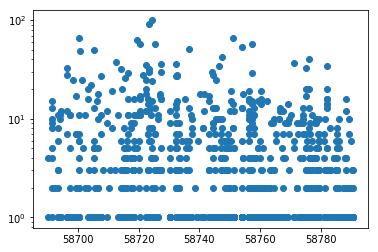

In [64]:
fig, ax = plt.subplots()
ax.scatter(df.first_mjd, df.nobs)
ax.set_yscale("log")

In [65]:
(df.dec < 30).sum() /  (df.dec < 90).sum()

0.6449579831932774

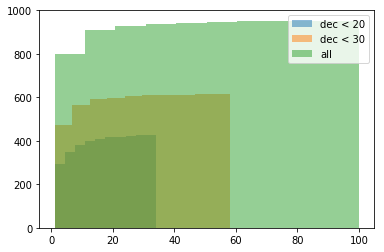

In [66]:
fig, ax = plt.subplots()
mask = df.dmag > 0
ax.hist(df.nobs[df.dec < 15], cumulative=True, alpha=0.5, label = "dec < 20")
ax.hist(df.nobs[df.dec < 30], cumulative=True, alpha=0.5, label = "dec < 30")
ax.hist(df.nobs[df.dec < 90], cumulative=True, alpha=0.5, label = 'all')
plt.legend()

# Obtain TNS stats (scrapping)

In [308]:
#results = {}
#specs = {}
#for name in all_alerce.Name.values:
#    objname = name[3:]
#    print(objname, len(results))
#    url = "https://wis-tns.weizmann.ac.il/object/%s" % objname
#    response = requests.get(url)
#    results[objname] = re.findall("cell-time_received.>(.*?)<.*cell-user_name.>(.*?)<.*cell-source_group_name.>(.*?)<.*cell-discovery_date.>(.*?)<.*", response.text)[1:]
#    specs[objname] = re.findall("spectrum.*?cell-id.>.*?cell-obsdate.>(.*?)<.*cell-tel_inst.>(.*?)<.*cell-exptime.>(.*?)<.*cell-observer.>(.*?)<.*", response.text)[1:]

2019rmo 0
2019rmn 1
2019rmm 2
2019rml 3
2019rmk 4
2019rmj 5
2019rmi 6
2019rmh 7
2019rmg 8
2019rmf 9
2019rme 10
2019rmd 11
2019rmc 12
2019rmb 13
2019rma 14
2019rlz 15
2019rly 16
2019rlx 17
2019rlw 18
2019rlv 19
2019rlu 20
2019rlt 21
2019rls 22
2019rlr 23
2019rlq 24
2019rlp 25
2019rlo 26
2019rln 27
2019rlm 28
2019rij 29
2019rii 30
2019rih 31
2019rig 32
2019rif 33
2019rie 34
2019rid 35
2019ric 36
2019rib 37
2019ria 38
2019rhz 39
2019rhy 40
2019rhx 41
2019rhw 42
2019rhv 43
2019rhu 44
2019rht 45
2019rhs 46
2019rbb 47
2019qxl 48
2019qxk 49
2019qxj 50
2019qxi 51
2019qxh 52
2019qxg 53
2019qxf 54
2019qxe 55
2019qxd 56
2019qxc 57
2019qxb 58
2019qxa 59
2019qwz 60
2019qwy 61
2019qwx 62
2019qww 63
2019qwv 64
2019qwu 65
2019qvr 66
2019qvq 67
2019qvp 68
2019qvo 69
2019qvn 70
2019qvm 71
2019qvl 72
2019qvk 73
2019qvj 74
2019qvi 75
2019qvh 76
2019qvg 77
2019qvf 78
2019qve 79
2019qst 80
2019qss 81
2019qsr 82
2019qsq 83
2019qsp 84
2019qso 85
2019qsn 86
2019qsm 87
2019qsl 88
2019qsk 89
2019qsj 90
2019qsi 9

### Save results

In [499]:
#import pickle
#with open('wis_results.pkl', 'wb') as handle:
#    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('wis_specs.pkl', 'wb') as handle:
#    pickle.dump(specs, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load results

In [116]:
import pickle
results = pickle.load(open('wis_results.pkl', 'rb'))
specs = pickle.load(open('wis_specs.pkl', 'rb'))

In [117]:
for SN in list(specs.keys()):
    if specs[SN] == []:
        del specs[SN]

In [118]:
delta_report = []
delta_2ndreport = []
group_2ndreport = []
delta_clf = []
mjd_disc = []
for SN in results.keys():
    #if not SN in specs.keys():
    #    continue
    report_2nd = 1e99
    clf_date = 1e99
    if len(results[SN]) > 0:
        for r in results[SN]:
            report_day = Time(r[0].replace(" ", "T")).mjd
            disc_day = Time(r[3].replace(" ", "T")).mjd
            disc_group = r[1]
            if disc_group == "ALeRCE":
                first_detection = disc_day
                report_ALeRCE = report_day
                delta_report.append(report_day - first_detection)
                mjd_disc.append(disc_day)
                if SN in specs.keys():
                    if specs[SN] != []:
                        clf_day = Time(specs[SN][0][0].replace(" ", "T")).mjd
                        delta_clf.append(clf_day - first_detection)
            else:
                if report_day < report_2nd:# and disc_group[:3] == "ZTF" :
                    report_2nd = report_day
                    report_group = disc_group
    if report_2nd < 1e99:
        delta_2ndreport.append(report_2nd - first_detection)
        group_2ndreport.append((SN, report_group))
                
                
delta_report = np.array(delta_report)
delta_2ndreport = np.array(delta_2ndreport)
mjd_disc = np.array(mjd_disc)

In [119]:
cl, n = np.unique(np.array(group_2ndreport)[:, 1], return_counts=True)

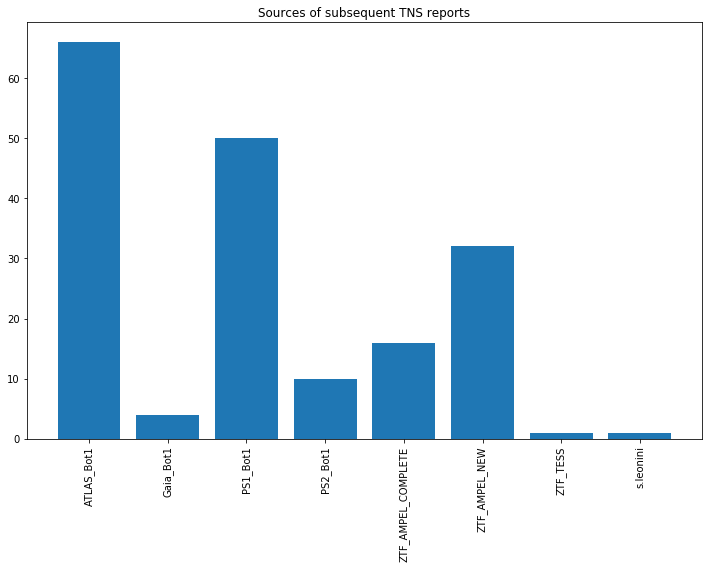

In [120]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(cl, n)
plt.xticks(rotation=90)
ax.set_title("Sources of subsequent TNS reports")
plt.tight_layout()
plt.savefig("plots/OtherSources.png")

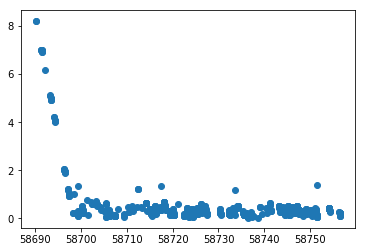

In [121]:
fig, ax = plt.subplots()
ax.scatter(mjd_disc, delta_report)#, bins=100, cumulative=True);

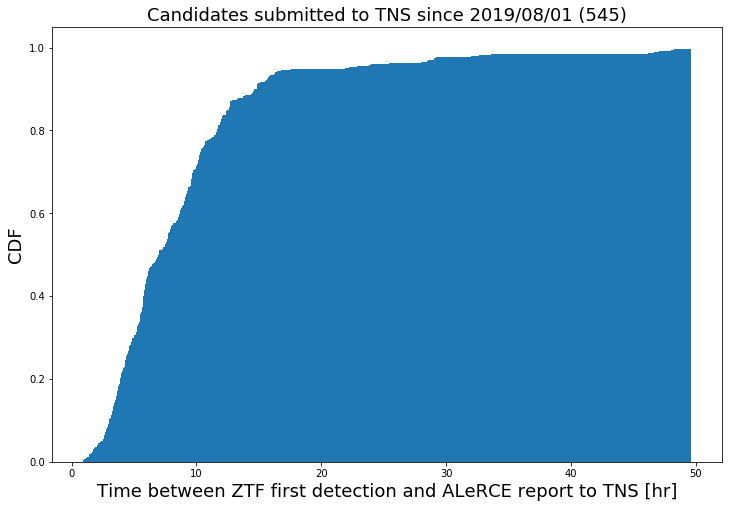

In [122]:
fig, ax = plt.subplots(figsize=(12, 8))
refmjd = 58696
ax.hist(delta_report[mjd_disc > refmjd] * 24., bins=1000, cumulative=True, density=True);
ax.set_title("Candidates submitted to TNS since %i/%02i/%02i (%i)" %
             (Time(refmjd, format='mjd').datetime.year,
              Time(refmjd, format='mjd').datetime.month,
              Time(refmjd, format='mjd').datetime.day,
              len(delta_report[mjd_disc > 58697])), fontsize=18)
ax.set_xlabel("Time between ZTF first detection and ALeRCE report to TNS [hr]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/Report_times.png")

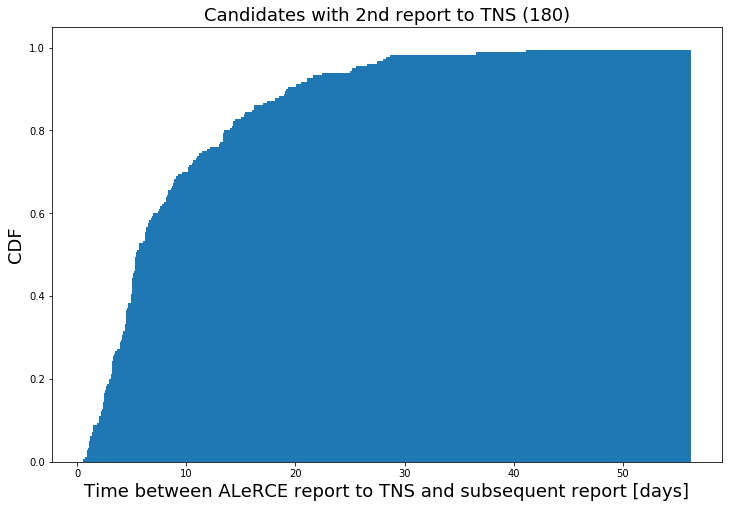

In [123]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(delta_2ndreport, bins=1000, cumulative=True, density=True);
ax.set_title("Candidates with 2nd report to TNS (%i)" % len(delta_2ndreport), fontsize=18)
ax.set_xlabel("Time between ALeRCE report to TNS and subsequent report [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/ALeRCE_vs_rest.png")

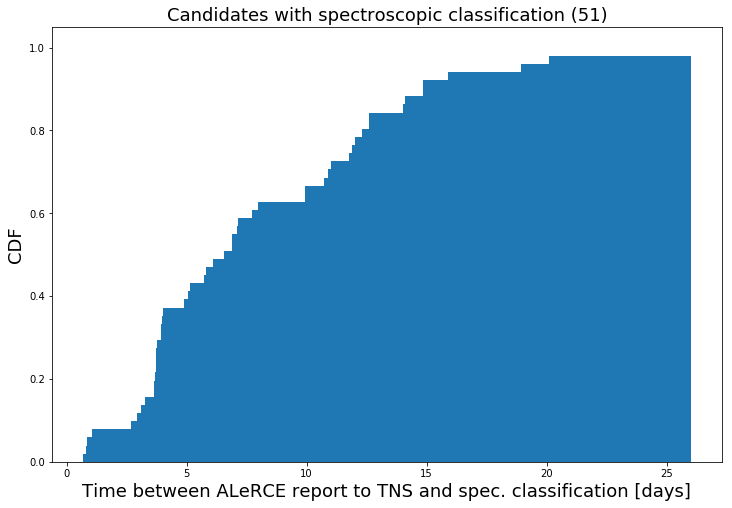

In [124]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(delta_clf, bins=1000, density=True, cumulative=True);
ax.set_title("Candidates with spectroscopic classification (%i)" % len(delta_clf), fontsize=18)
ax.set_xlabel("Time between ALeRCE report to TNS and spec. classification [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/ALeRCE_classification.png")

In [125]:
print(np.median(delta_report[mjd_disc > refmjd]))

0.2903356481474475


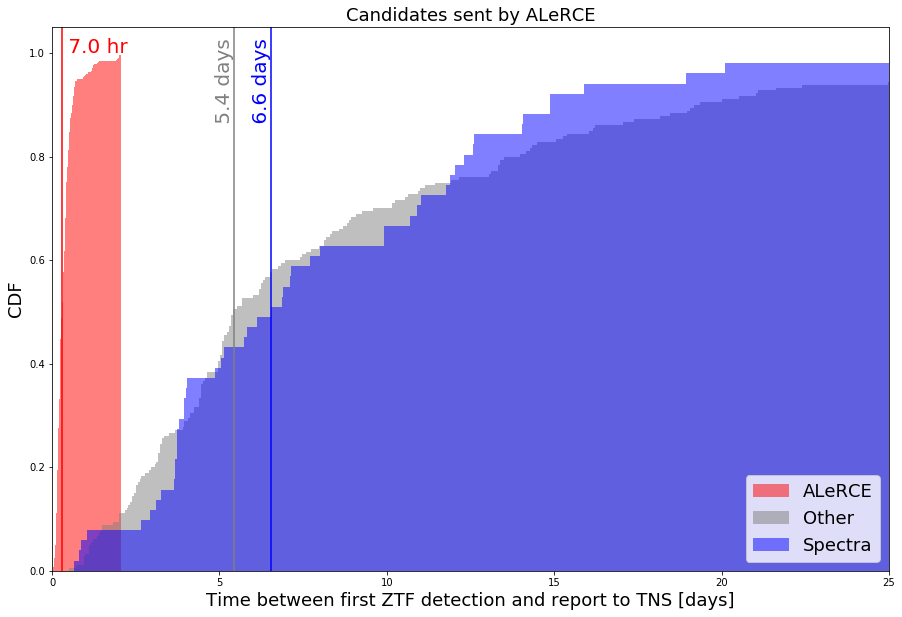

In [126]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(delta_report[mjd_disc > refmjd], bins=1000, density=True, alpha=0.5, cumulative=True, color = 'r', label='ALeRCE');
ax.hist(delta_2ndreport, bins=1000, density=True, alpha=0.5, cumulative=True, label='Other', color = 'gray');
ax.hist(delta_clf, bins=1000, density=True, alpha=0.5, cumulative=True, label='Spectra', color = 'b');
ax.axvline(np.median(delta_report[mjd_disc > refmjd]), c = 'r')
ax.text(np.median(delta_report[mjd_disc > refmjd]), 1.,
        " %.1f hr" % (np.median(delta_report[mjd_disc > refmjd]) * 24.), color = 'r', fontsize=20)
ax.axvline(np.median(delta_2ndreport), c = 'gray')
ax.text(np.median(delta_2ndreport), 1.,
        " %.1f days" % (np.median(delta_2ndreport)), color = 'gray', fontsize=20, rotation=90, ha = 'right')
ax.axvline(np.median(delta_clf), c = 'b')
ax.text(np.median(delta_clf), 1.,
        " %.1f days" % (np.median(delta_clf)), color = 'b', fontsize=20, rotation=90, ha = 'right')
ax.set_title("Candidates sent by ALeRCE", fontsize=18)
ax.set_xlabel("Time between first ZTF detection and report to TNS [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
ax.set_xlim(0, 25)
ax.legend(fontsize=18, loc=4)
plt.savefig("plots/ALeRCE_Other.pdf")
plt.savefig("plots/ALeRCE_Other.png")

In [53]:
list(zip(group_2ndreport, delta_2ndreport))

[(('2019rij', 'ATLAS_Bot1'), 2.5359722222201526),
 (('2019qvm', 'PS1_Bot1'), 3.10763888888323),
 (('2019qvf', 'Gaia_Bot1'), 6.235150462962338),
 (('2019qsp', 'PS1_Bot1'), 3.6770486111126957),
 (('2019qsg', 'PS1_Bot1'), 5.6986805555497995),
 (('2019qsc', 'Gaia_Bot1'), 3.559988425928168),
 (('2019qqd', 'PS1_Bot1'), 5.386145833334012),
 (('2019qqc', 'ZTF_AMPEL_NEW'), 2.4506018518513883),
 (('2019qpz', 'PS1_Bot1'), 4.5067129629605915),
 (('2019qpy', 'PS1_Bot1'), 5.032465277778101),
 (('2019qnp', 'ZTF_AMPEL_NEW'), 3.3701736111106584),
 (('2019qnk', 'PS1_Bot1'), 7.5820138888884685),
 (('2019qnb', 'PS1_Bot1'), 5.524305555554747),
 (('2019qna', 'PS1_Bot1'), 5.717592592591245),
 (('2019qmx', 'ATLAS_Bot1'), 6.257349537037953),
 (('2019qla', 'ZTF_AMPEL_NEW'), 4.440127314817801),
 (('2019qkz', 'ZTF_AMPEL_NEW'), 4.452893518522615),
 (('2019qky', 'ZTF_AMPEL_NEW'), 4.457037037034752),
 (('2019qkt', 'PS1_Bot1'), 8.865173611113278),
 (('2019qiz', 'ZTF_AMPEL_NEW'), 5.334085648151813),
 (('2019qix', 'ZTF

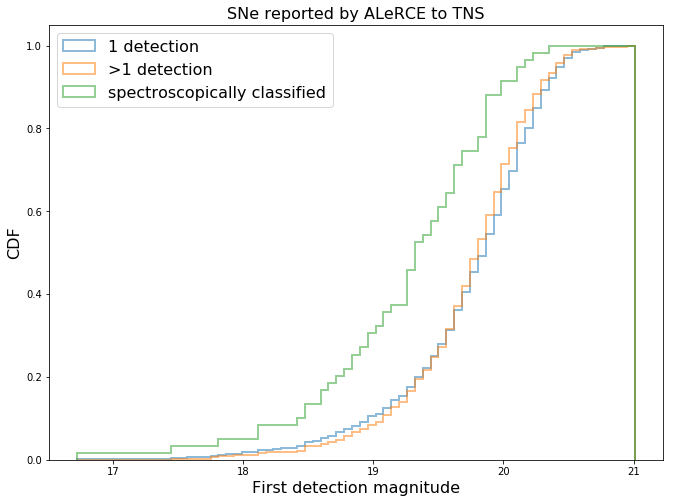

In [55]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label="1 detection", density=True, alpha = 0.5, histtype='step', lw=2)
ax.hist(df[df.nobs > 1].first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label=">1 detection", density=True, alpha = 0.5, histtype='step', lw=2)
ax.hist(all_alerce.loc[classified_mask]["Discovery Mag"], bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label="spectroscopically classified", density=True, alpha = 0.5, histtype='step', lw=2)
ax.legend(fontsize=16, loc=2)
ax.set_xlabel("First detection magnitude", fontsize = 16)
#ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/mags+clf.png")

In [56]:
all_alerce["shortname"] = all_alerce.Name.apply(lambda x: x[3:])

In [57]:
list(all_alerce)

['ID',
 'Name',
 'RA',
 'DEC',
 'Obj. Type',
 'Redshift',
 'Host Name',
 'Host Redshift',
 'Discovering Group/s',
 'Classifying Group/s',
 'Associated Group/s',
 'Disc. Internal Name',
 'Disc. Instrument/s',
 'Class. Instrument/s',
 'TNS AT',
 'Public',
 'End Prop. Period',
 'Discovery Mag',
 'Discovery Mag Filter',
 'Discovery Date (UT)',
 'Sender',
 'Remarks',
 'Ext. catalog/s',
 'url',
 'shortname']

# Do some statistics on ML classified objects

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

In [59]:
#!pip install psycopg2-binary
import psycopg2

In [63]:
import json
credentials_file = "../usecases/alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

In [64]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [65]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

tablename
7                  asassn
16                  class
8               crtsnorth
9               crtssouth
1              detections
14               features
20            features_v2
0              insert_tmp
3   late_probabilities_v2
11                 linear
17                 magref
18         non_detections
2                 objects
12          probabilities
13   stamp_classification
5               tax_class
4                taxonomy
6              temp_probs
19             temp_table
15                    tns
10                 xmatch

In [66]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

table                    column_name  \
0                   asassn                   ASAS-SN Name   
1                   asassn                    Other Names   
2                   asassn                           LCID   
3                   asassn                             ra   
4                   asassn                            dec   
5                   asassn                      Mean VMag   
6                   asassn                      Amplitude   
7                   asassn                         Period   
8                   asassn                           Type   
9                   asassn                            Url   
10                  asassn                      Reference   
11                  asassn                           Dist   
12                  asassn                       Parallax   
13                  asassn                 Parallax Error   
14                  asassn                           Gmag   
15                  asassn                          Bpmag   
16                  asassn                          Rpmag   
17                  asassn                           Jmag   
18                  asassn                           Hmag   
19                  asassn                           Kmag   
20                  asassn                          W1mag   
21                  asassn                          W2mag   
22                  asassn                          W3mag   
23                  asassn                          W4mag   
24                  asassn                          BP-RR   
25                  asassn                            J-K   
26                  asassn                          W1-W2   
27                  asassn                          W3-W4   
28                  asassn                 Sllk Statistic   
29                  asassn            RF Regression Score   
30                  asassn     Classification Probability   
31                  asassn                    Epoch (HJD)   
0                    class                             id   
1                    class                           name   
0                crtsnorth            Catalina_Surveys_ID   
1                crtsnorth                   Numerical_ID   
2                crtsnorth                        V_(mag)   
3                crtsnorth                  Period_(days)   
4                crtsnorth                      Amplitude   
5                crtsnorth                     Number_Obs   
6                crtsnorth                       Var_Type   
7                crtsnorth                             ra   
8                crtsnorth                            dec   
0                crtssouth                         SSS_ID   
1                crtssouth                   Numerical_ID   
2                crtssouth                             ra   
3                crtssouth                            dec   
4                crtssouth                         Period   
5                crtssouth                          V_CSS   
6                crtssouth                           Npts   
7                crtssouth                          V_amp   
8                crtssouth                           Type   
0               detections                            oid   
1               detections                         candid   
2               detections                            mjd   
3               detections                            fid   
4               detections                     diffmaglim   
5               detections                         magpsf   
6               detections                          magap   
7               detections                       sigmapsf   
8               detections                       sigmagap   
9               detections                             ra   
10              detections                            dec   
11              detections                        sigmara   
12              detections                       sigmade

In [67]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

{'Other': 0,
 'Ceph': 1,
 'LPV': 4,
 'RRL': 5,
 'EB': 3,
 'SNe': 6,
 'DSCT': 2,
 'AGN I': 7,
 'Blazar': 8,
 'CV/Nova': 9,
 'SN Ia': 10,
 'SN Ibc': 11,
 'SN II': 12,
 'SN IIn': 13,
 'SLSN': 14,
 'EB/SD/D': 15,
 'EB/C': 16,
 'Periodic/Other': 17,
 'AGN': 18,
 'SN': 19,
 'Variable Star': 20,
 'Asteroid': 21,
 'Bogus': 22}

Ceph
LPV
RRL
DSCT
AGN I
Blazar
CV/Nova
SN Ia
SN Ibc
SN II
SN IIn
SLSN
EB/SD/D
EB/C
Periodic/Other


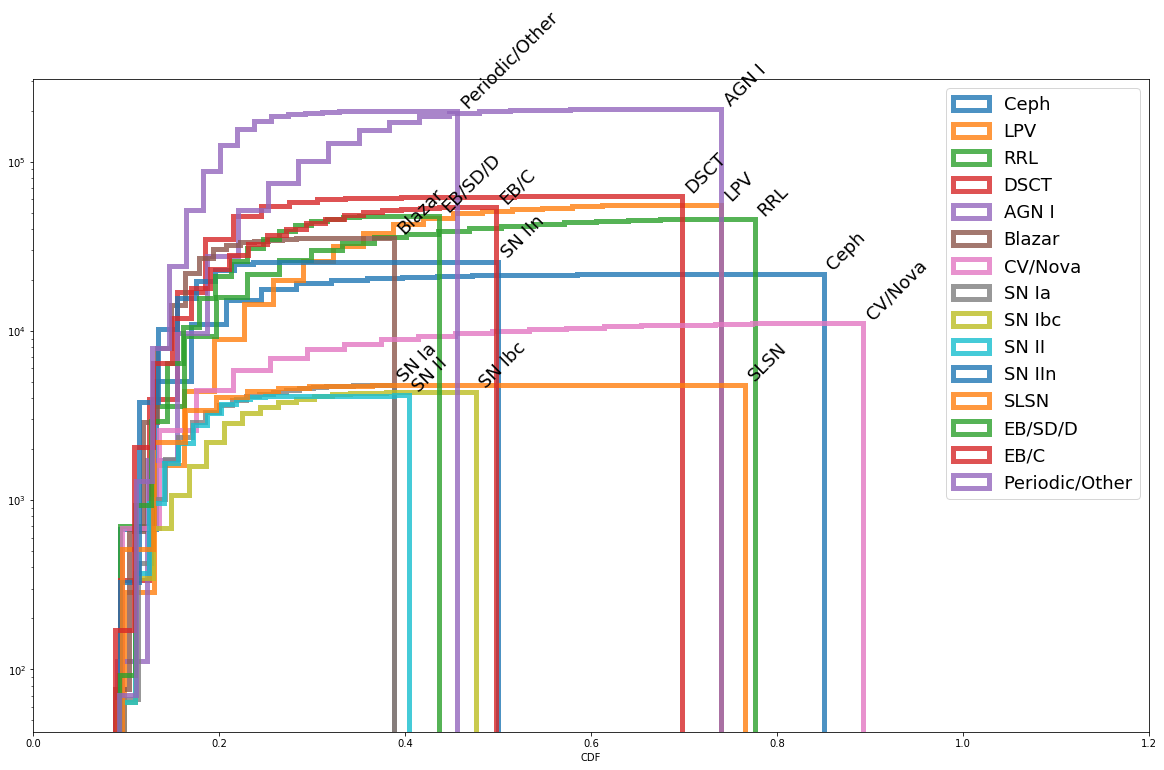

In [117]:
fig, ax = plt.subplots(figsize=(20, 12))
ncl = 0
df_cl = {}
for cl in classmapper.keys():
    if cl in ["Other", "EB", "SNe", "AGN", "SN", "Variable Star", "Asteroid", "Bogus"]:
        continue
    ncl += 1
    print(cl)
    prob_name = "%s_prob" % cl.replace(" ", "")
    if cl == "AGN I":
        prob_name = "AGN-I_prob"
    elif cl == "EB/SD/D":
        prob_name = "EBSD/D_prob"
    elif cl == "EB/C":
        prob_name = "EBC_prob"
    elif cl == "Periodic/Other":
        prob_name = "Periodic-Other_prob"
    query='''
    select late_probabilities_v2."%s"
    from late_probabilities_v2 

    inner join objects
    on late_probabilities_v2.oid=objects.oid

    where objects.classrf=%i
    
    ''' % (prob_name, classmapper[cl])
    # notar que "SNIa_prob" is written between parenthesis, since this is a programatically defined column in SQL

    df_cl[prob_name] = pd.read_sql_query(query, conn)
    ax.hist(df_cl[prob_name][prob_name], histtype='step', cumulative=True, bins=20, lw=5, label=cl, alpha=0.8)
    ax.text(df_cl[prob_name][prob_name].max(), df_cl[prob_name].shape[0], cl, fontsize=18, rotation=45, va='bottom', ha='left')
ax.legend(fontsize=18)
ax.set_xlim(0, 1.2)
ax.set_yscale('log')
ax.set_xlabel("Probability")
ax.set_xlabel("CDF")
plt.savefig("plots/cumulative.png")    

0 Ceph_prob 0.138
1 LPV_prob 0.178
2 RRL_prob 0.15
3 DSCT_prob 0.15199999999999997
4 AGN-I_prob 0.188
5 Blazar_prob 0.126
6 CV/Nova_prob 0.13
7 SNIa_prob 0.12
8 SNIbc_prob 0.12
9 SNII_prob 0.118
10 SNIIn_prob 0.124
11 SLSN_prob 0.118
12 EBSD/D_prob 0.14
13 EBC_prob 0.132
14 Periodic-Other_prob 0.15


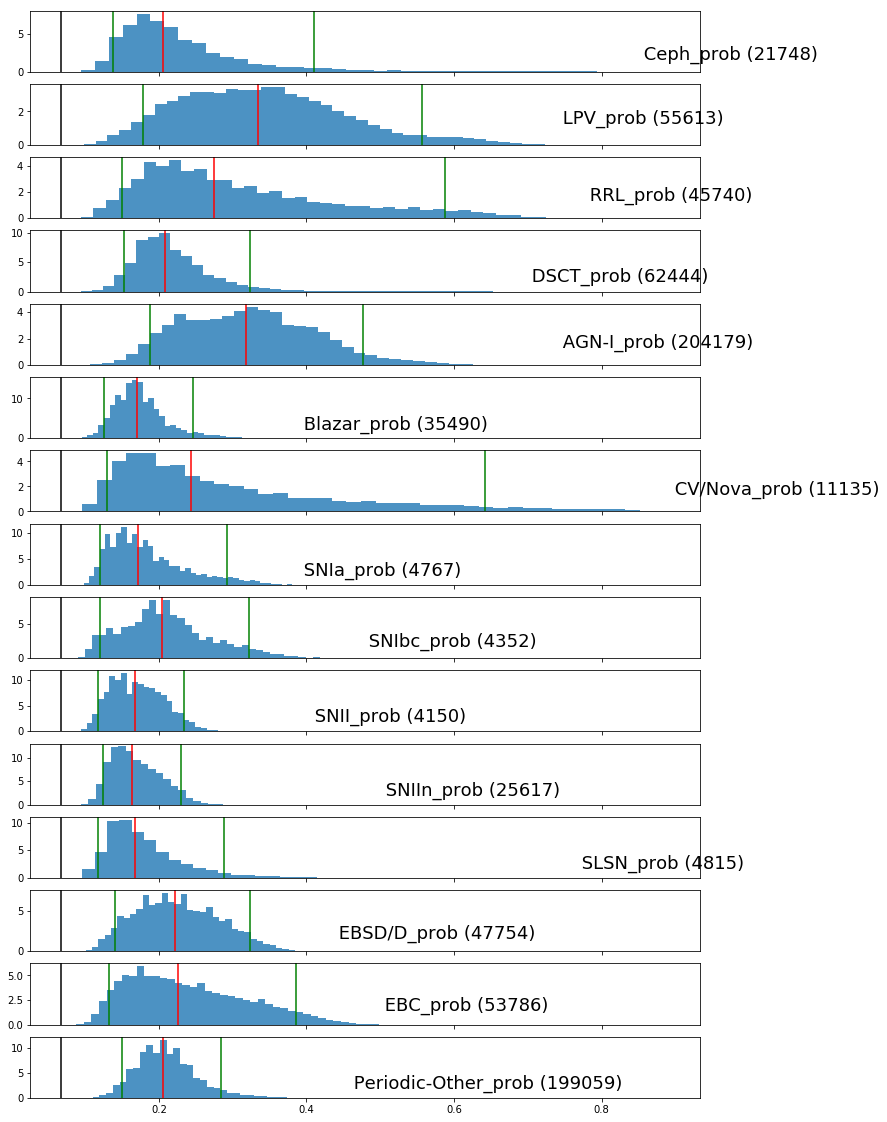

In [184]:
fig, ax = plt.subplots(nrows = len(df_cl.keys()), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(df_cl.keys()):
    print(idx, cl, np.percentile(df_cl[cl][cl], 5.))
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 5.), c='g')
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 50.), c='r')
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 95.), c='g')

    ax[idx].axvline(1/len(df_cl.keys()), c = 'k')
    ax[idx].hist(df_cl[cl][cl], density=True, bins=40, lw=5, label=cl, alpha=0.8)
    ax[idx].text(df_cl[cl][cl].max(), 1., " %s (%i)" % (cl, df_cl[cl].shape[0]), fontsize=18, va='bottom', ha='left')

#ax[-1].set_xlabel("probability")    

# Build histogram given probability cut

In [187]:
class_order = ['AGN-I', 'Blazar', 'CV/Nova', 'LPV', 'SNIa', 'SNIbc', 'SNII', 'SNIIn',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'Periodic-Other']

/home/fforster/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


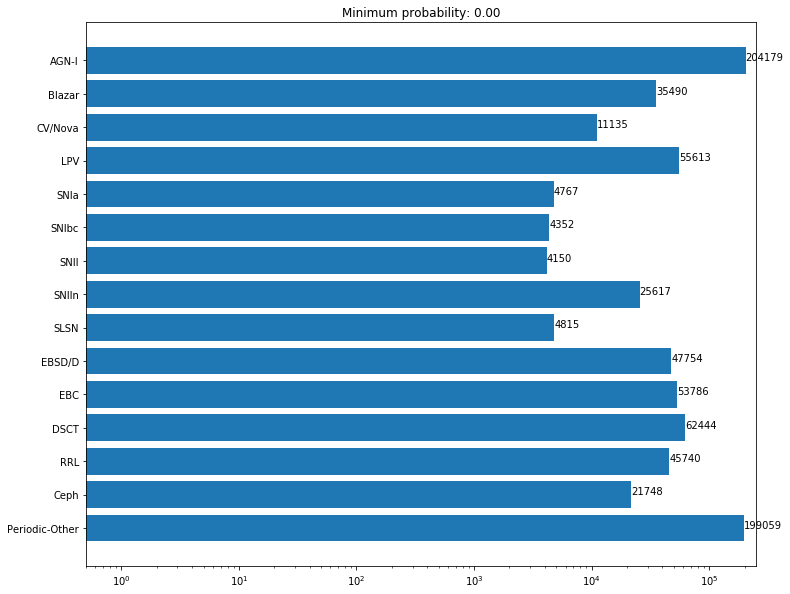

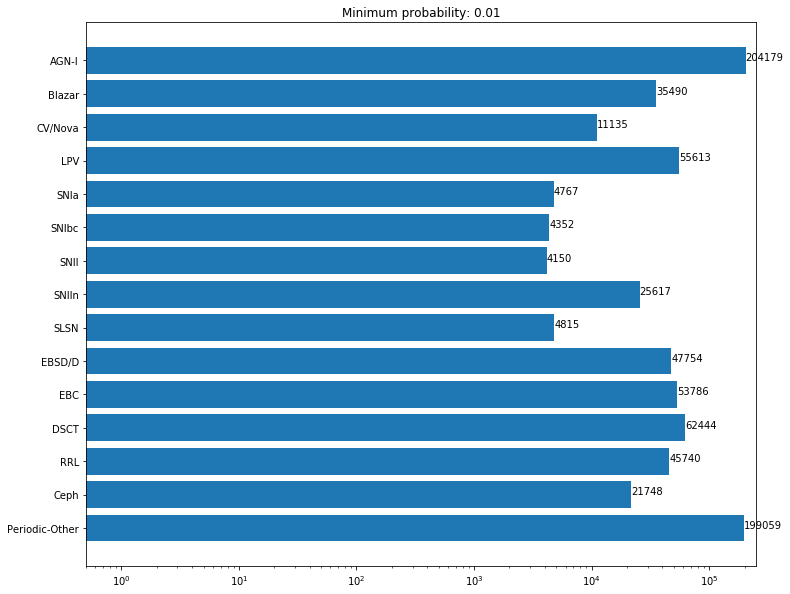

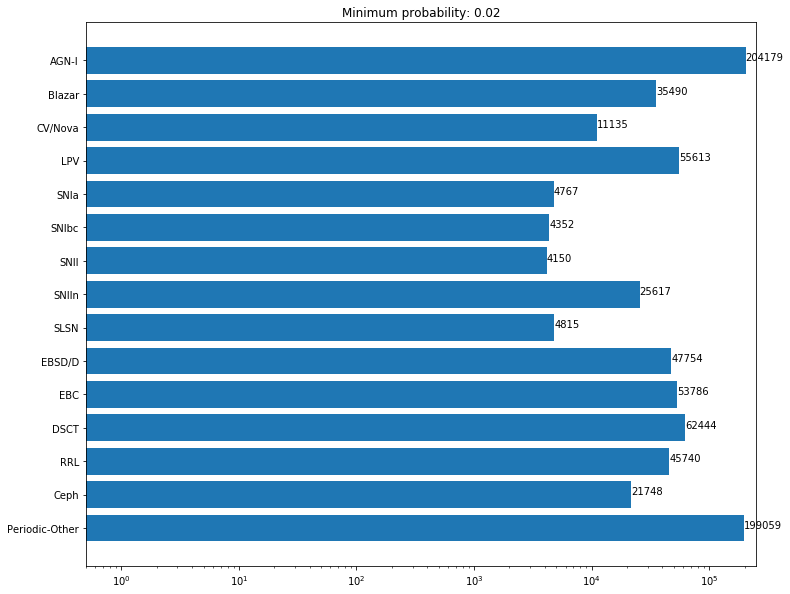

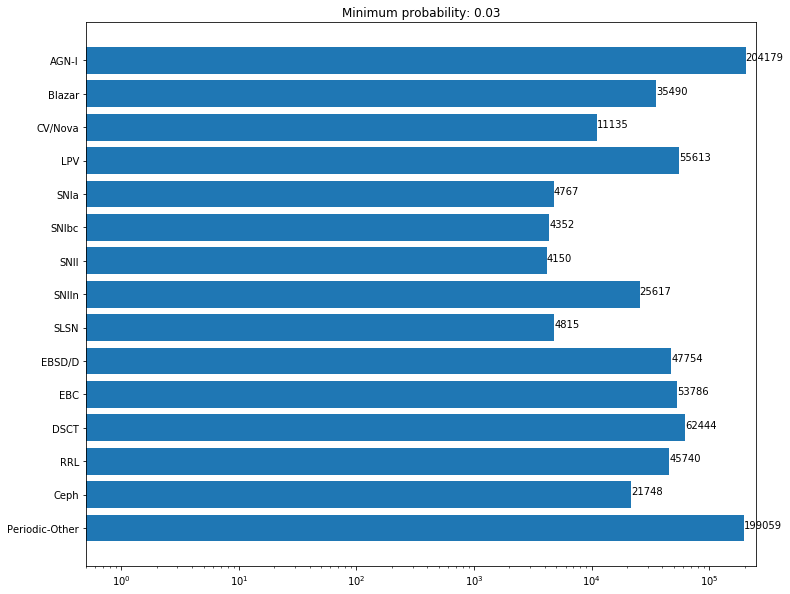

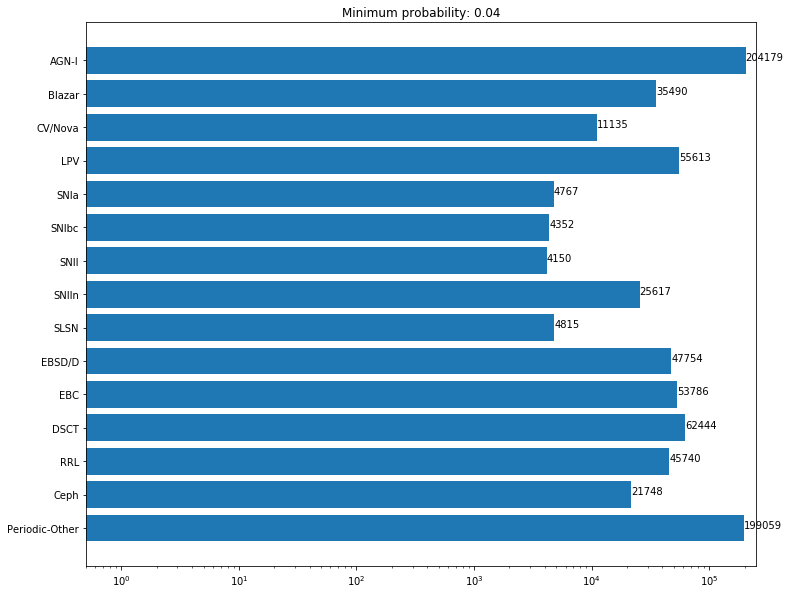

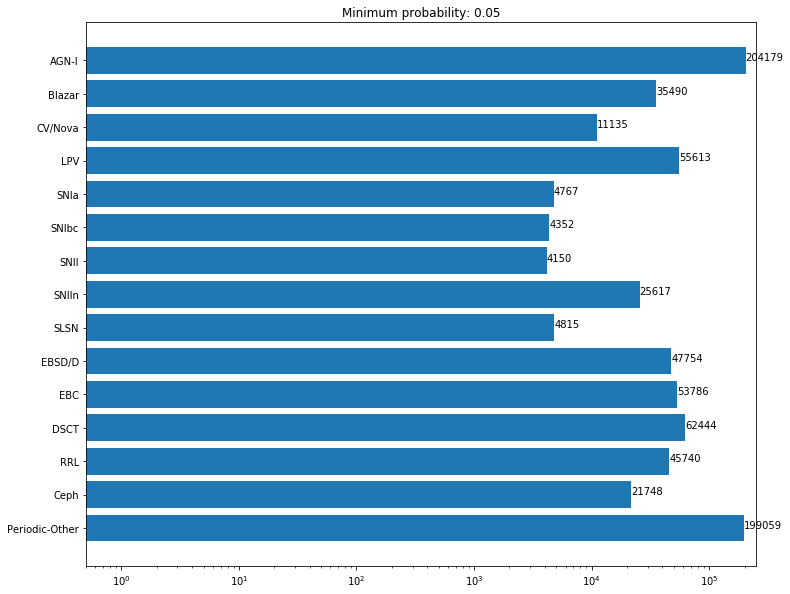

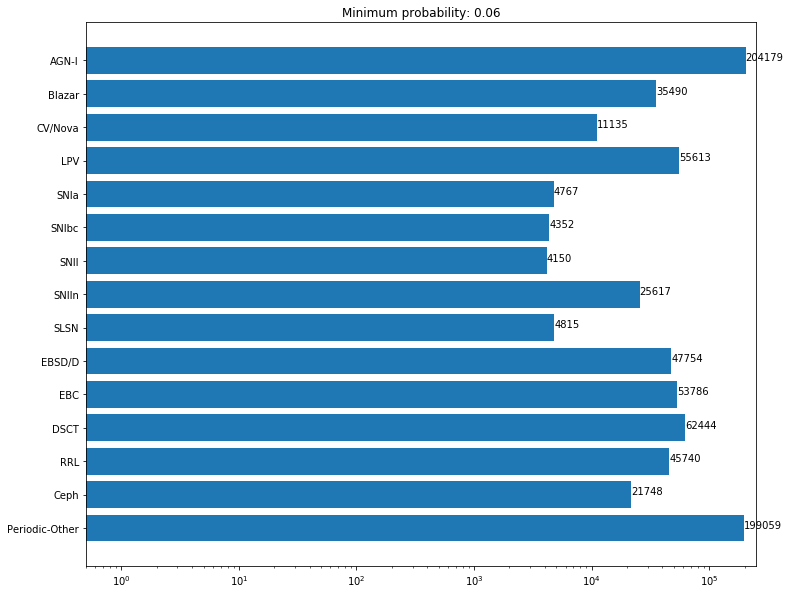

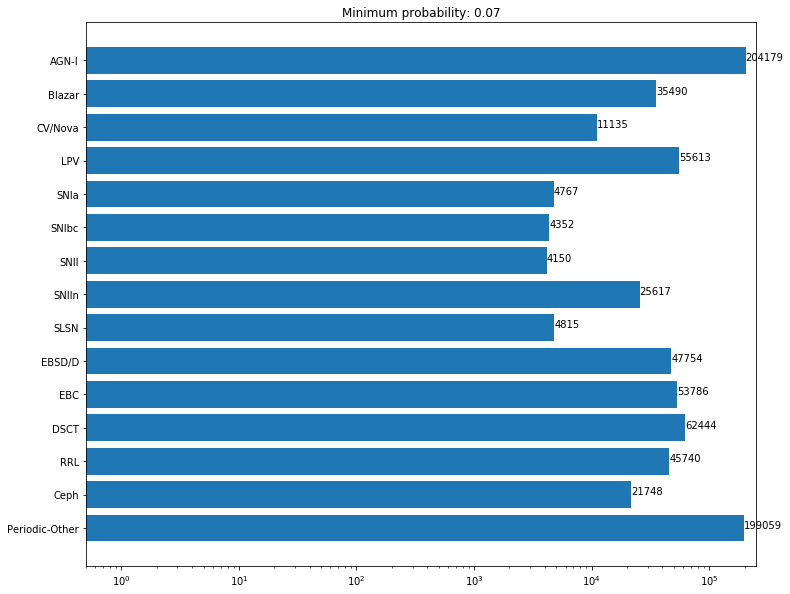

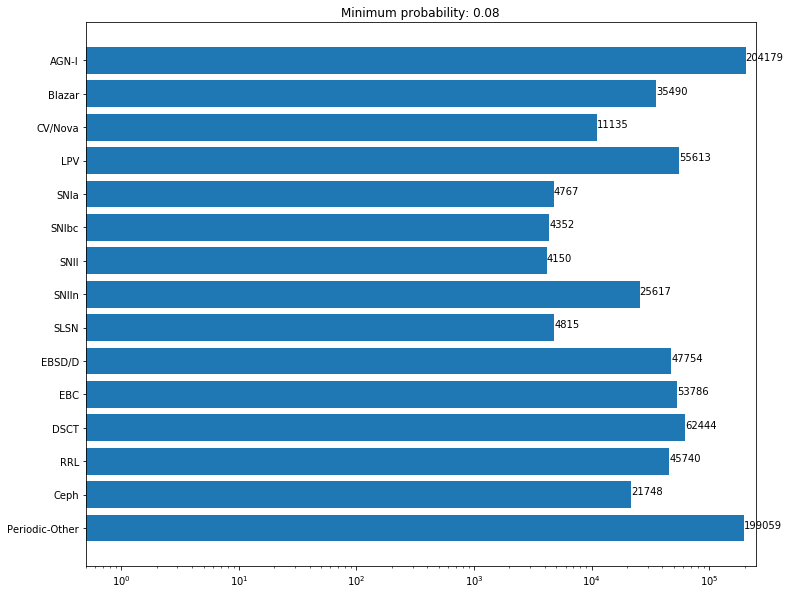

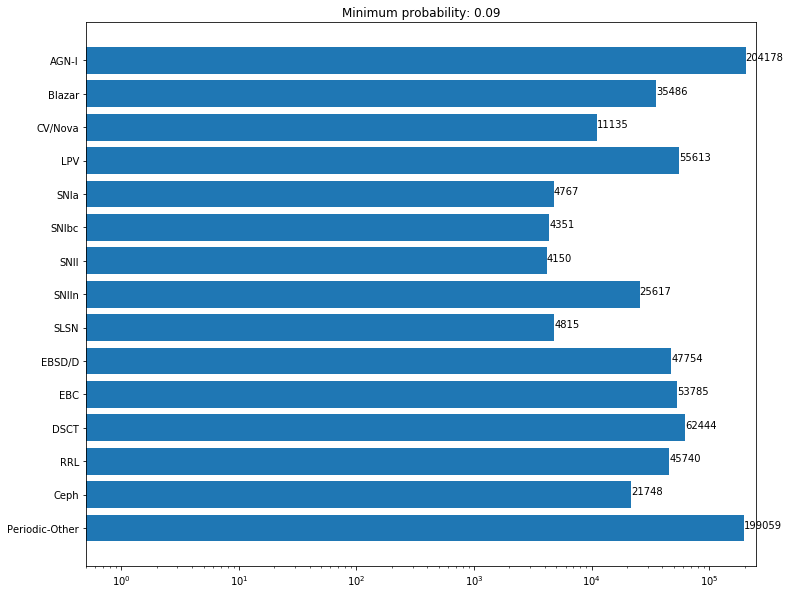

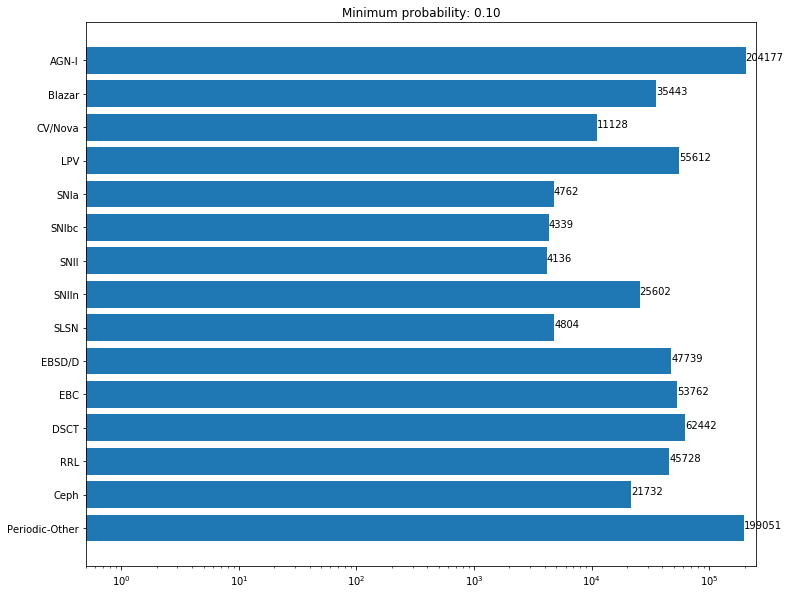

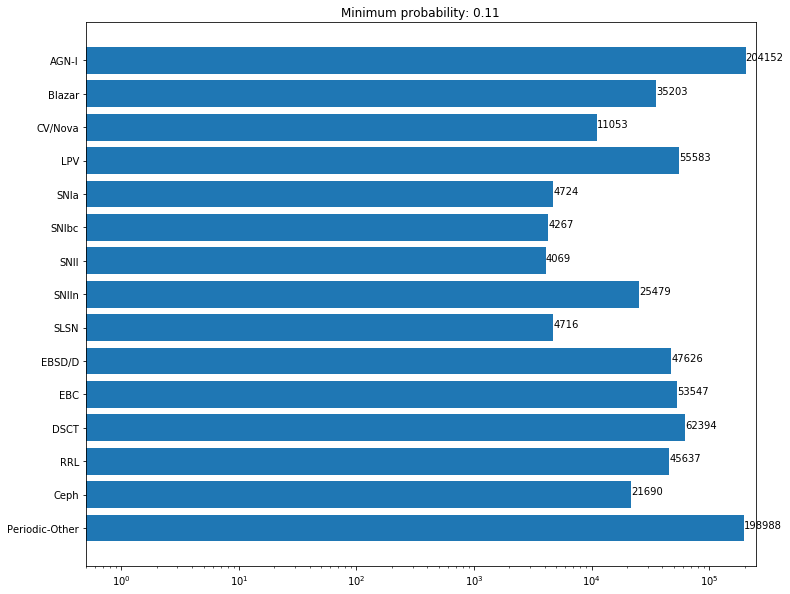

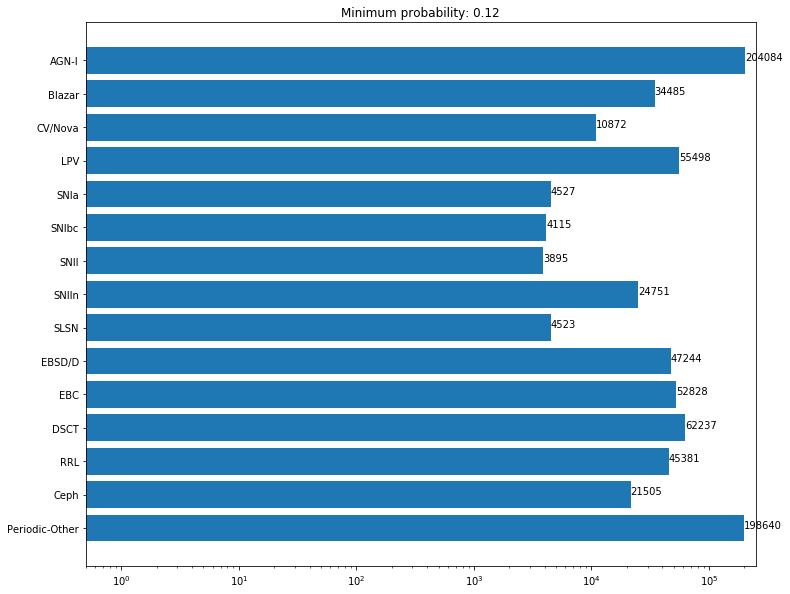

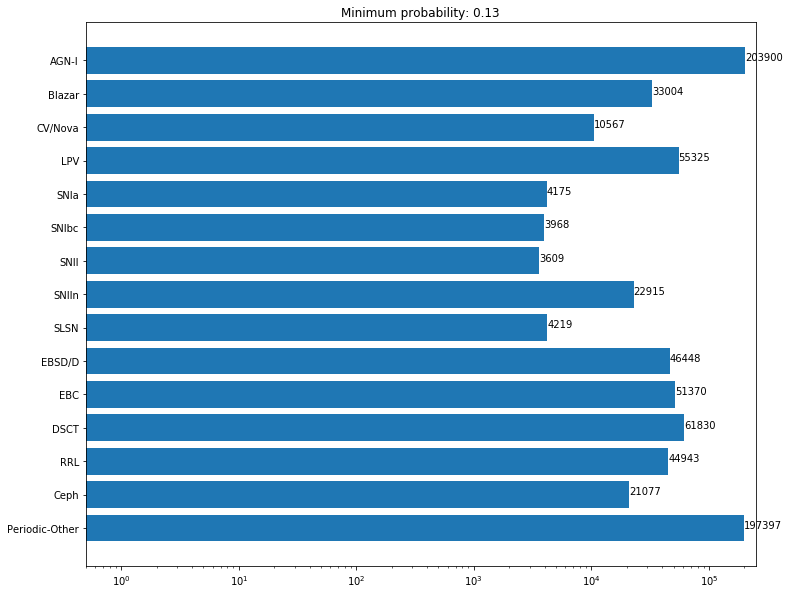

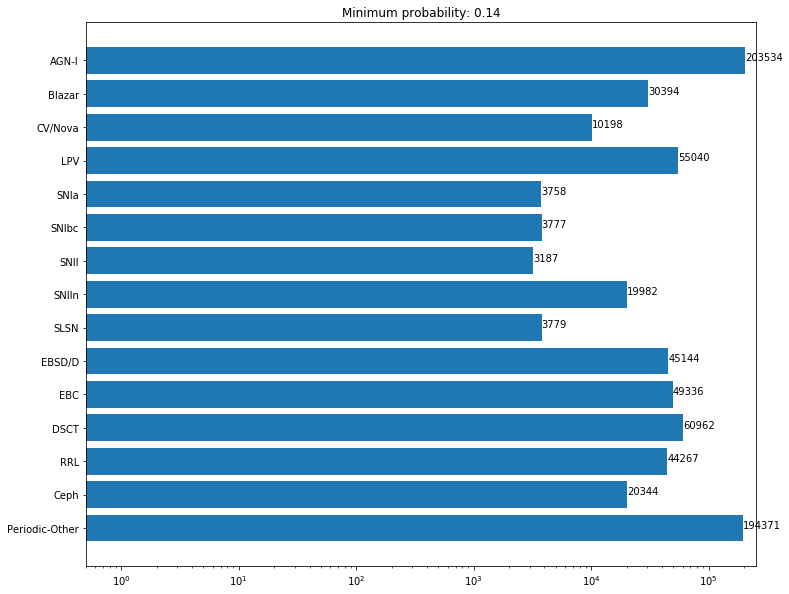

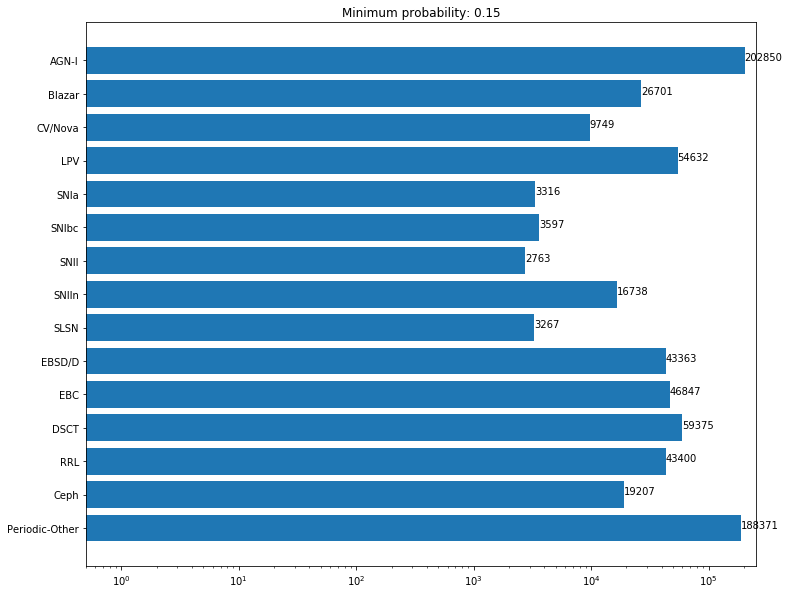

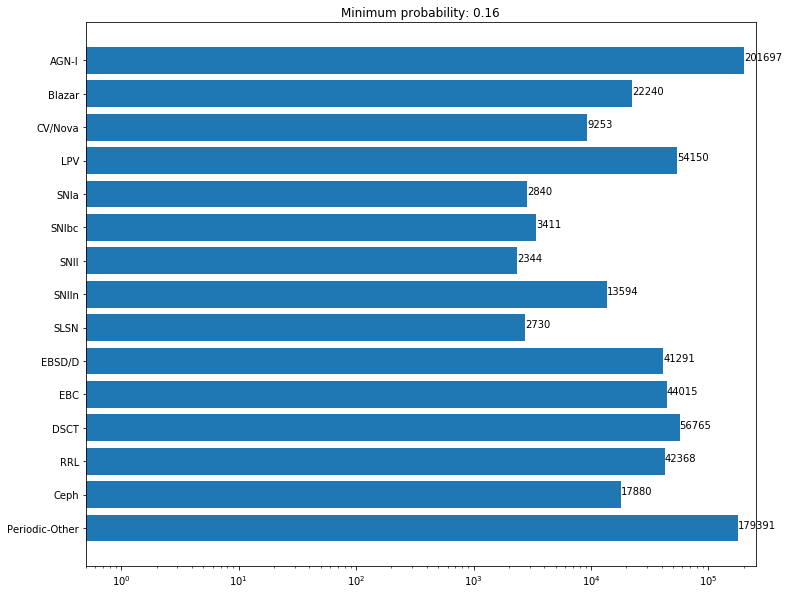

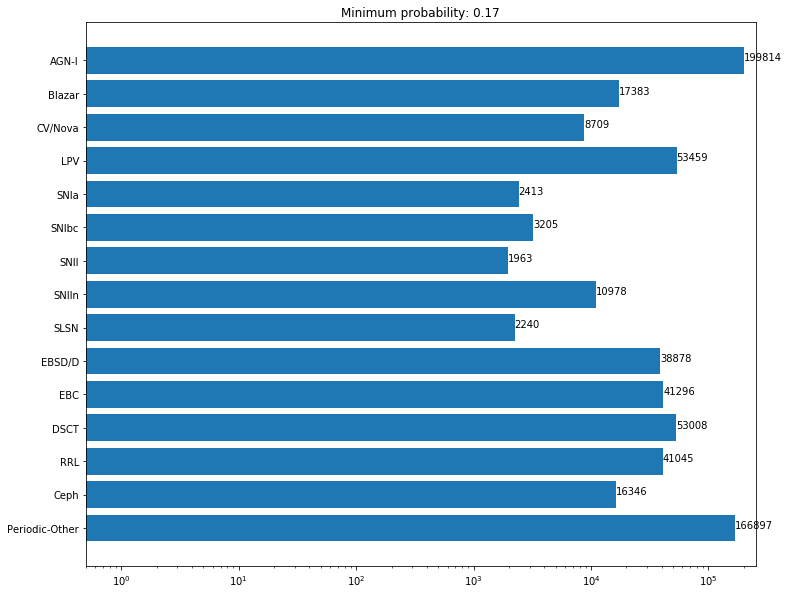

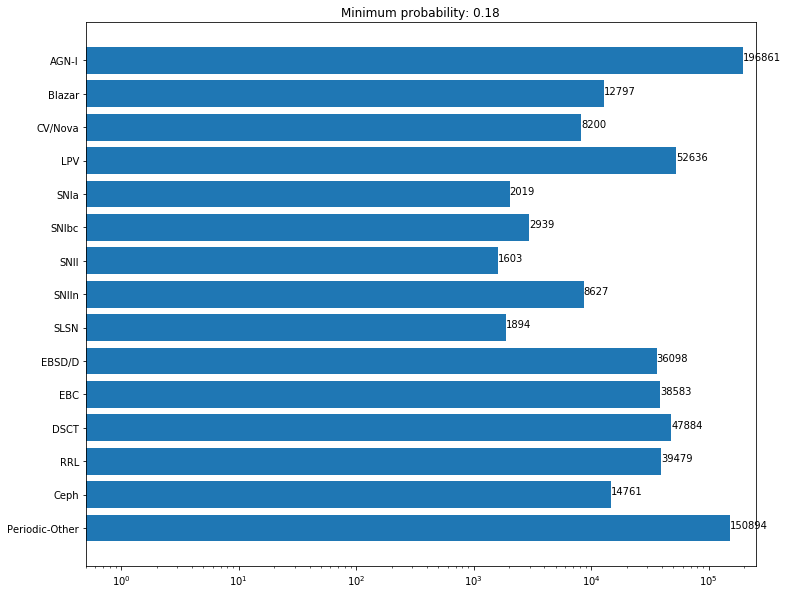

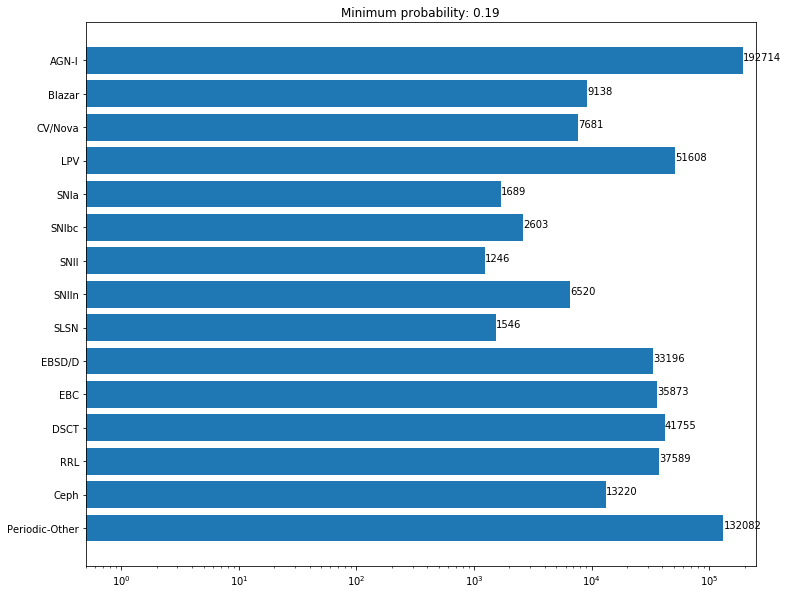

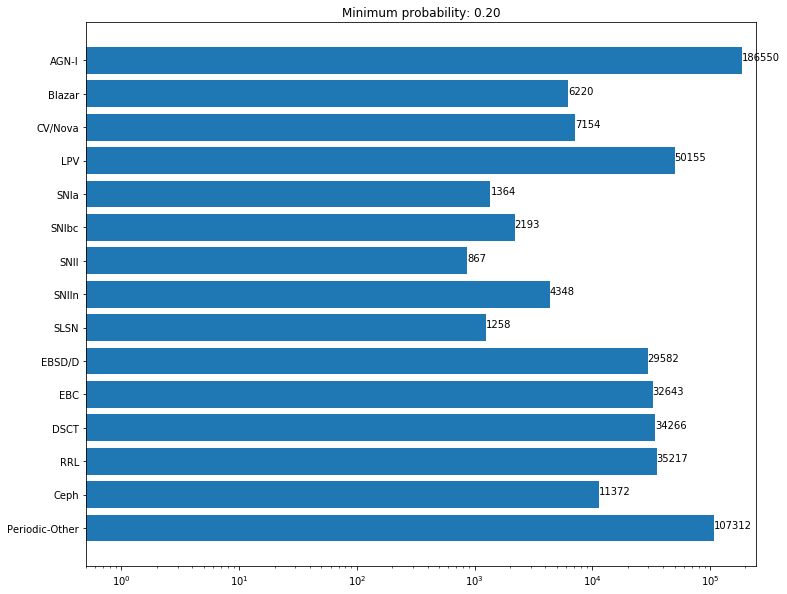

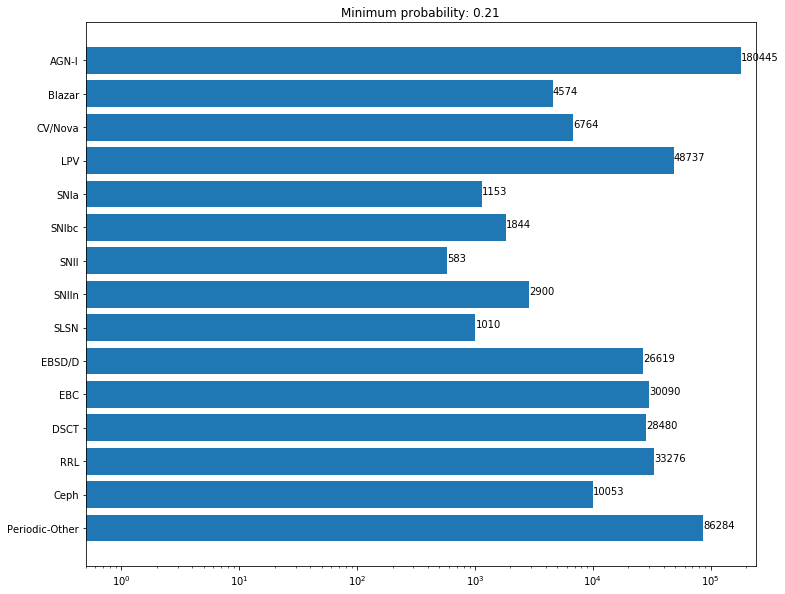

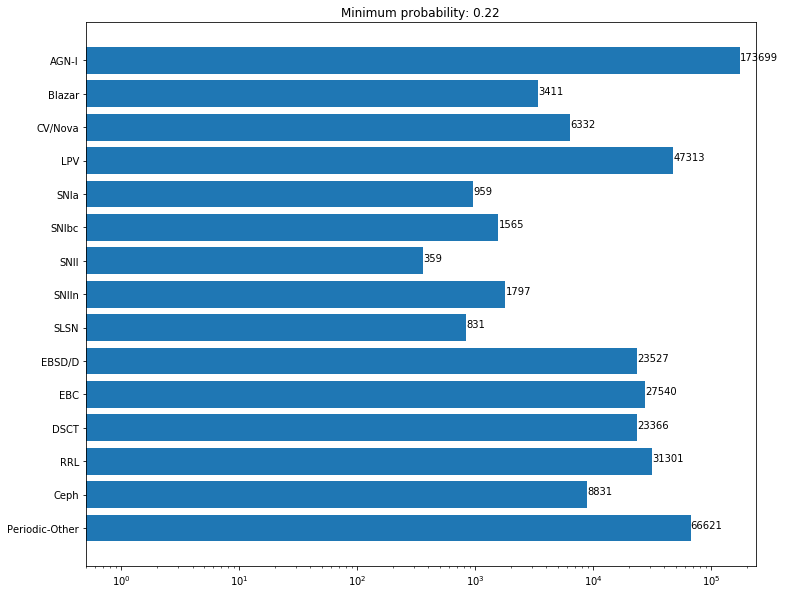

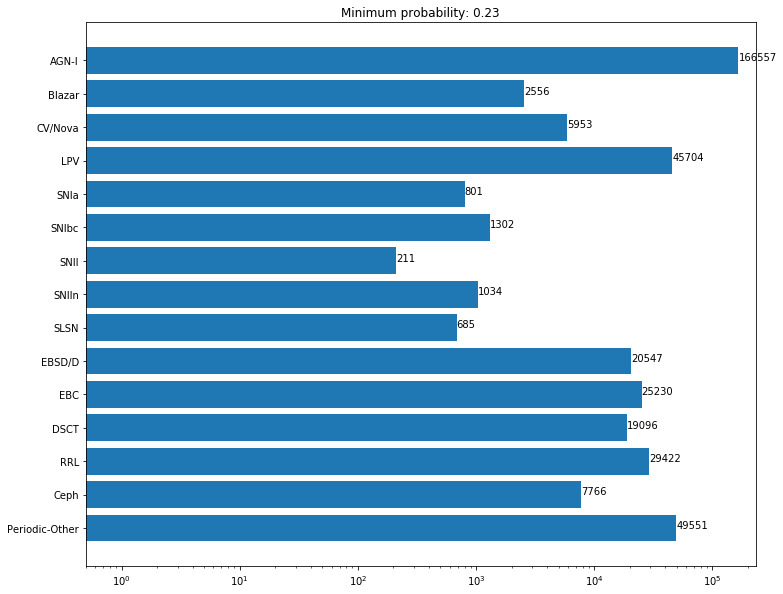

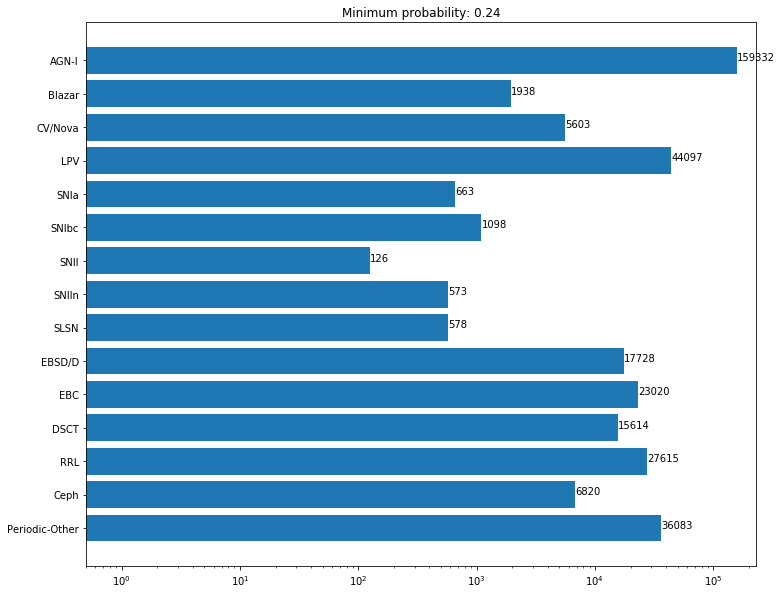

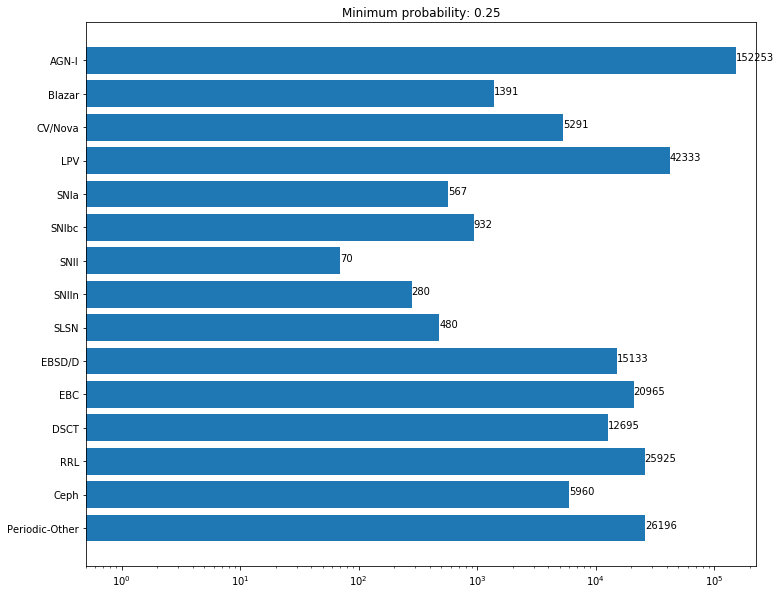

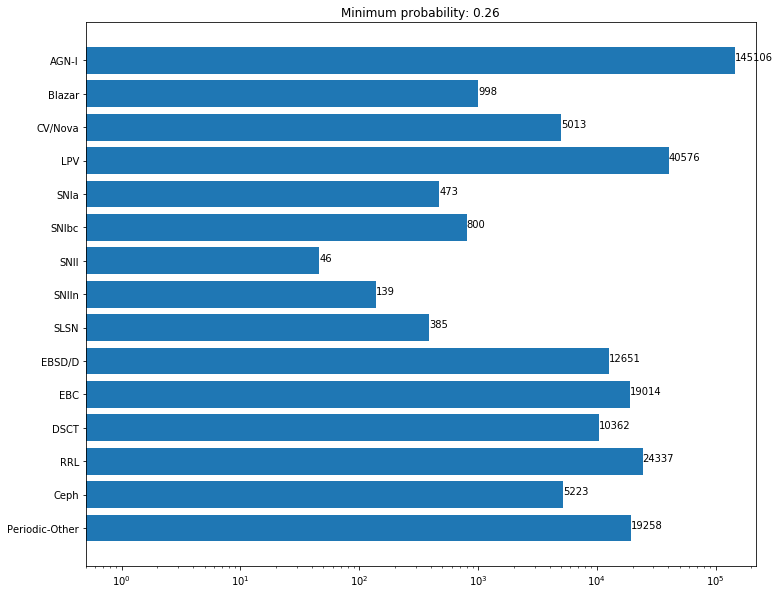

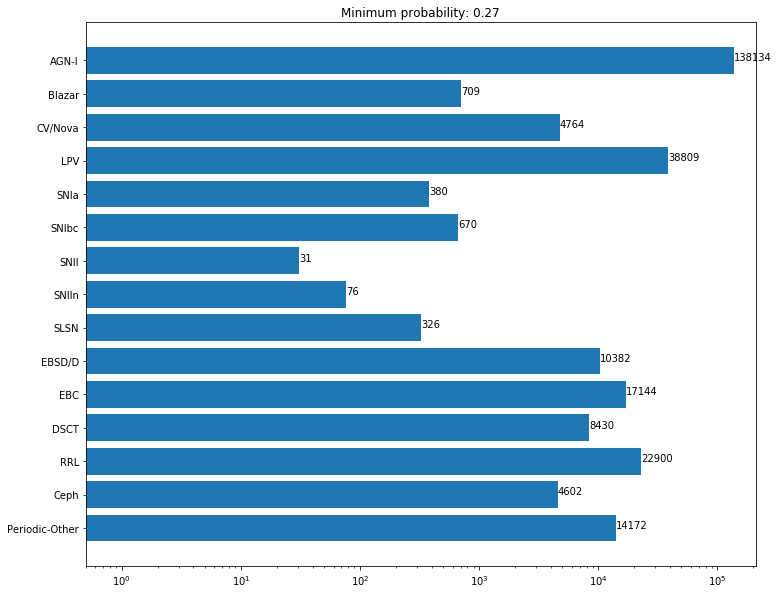

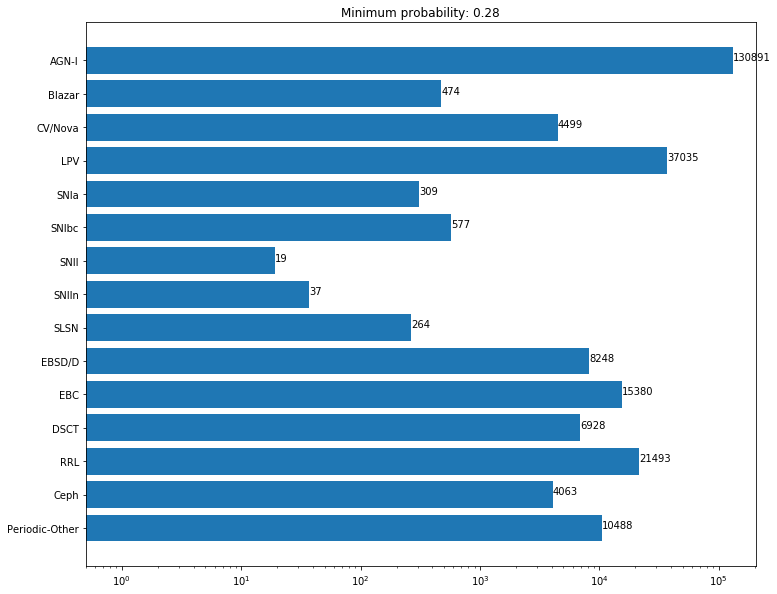

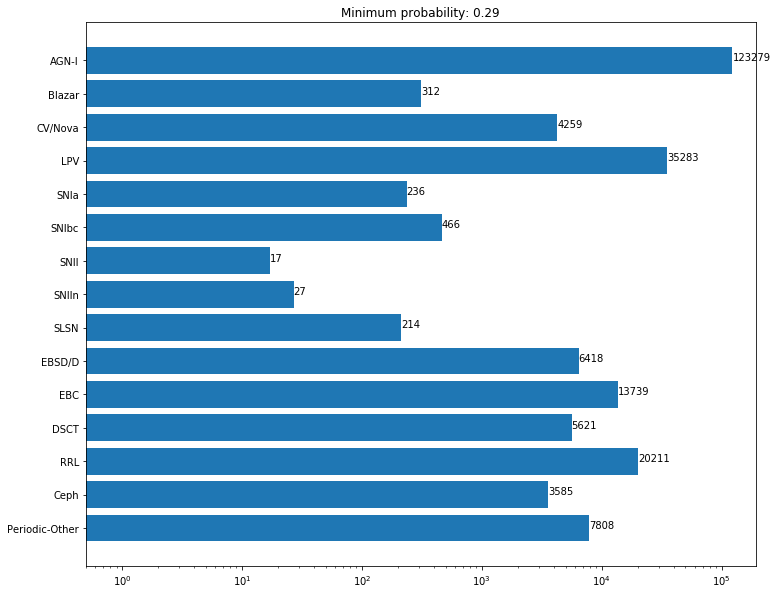

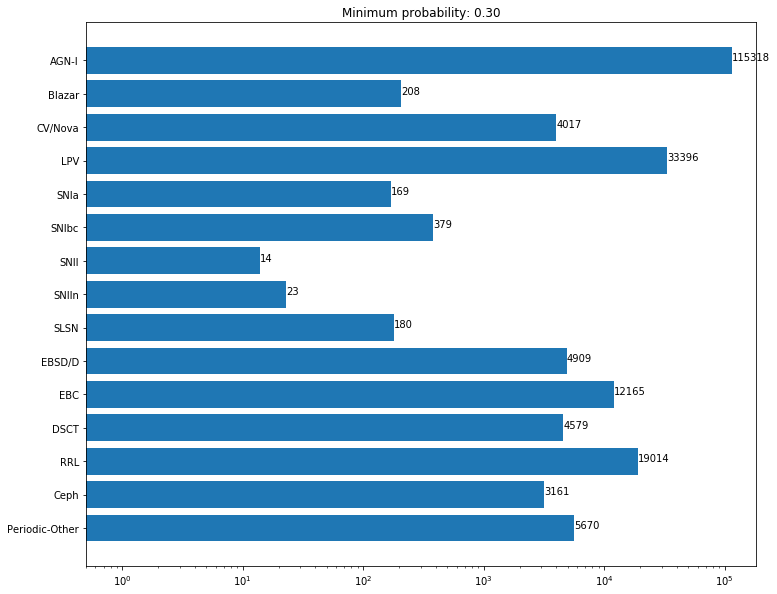

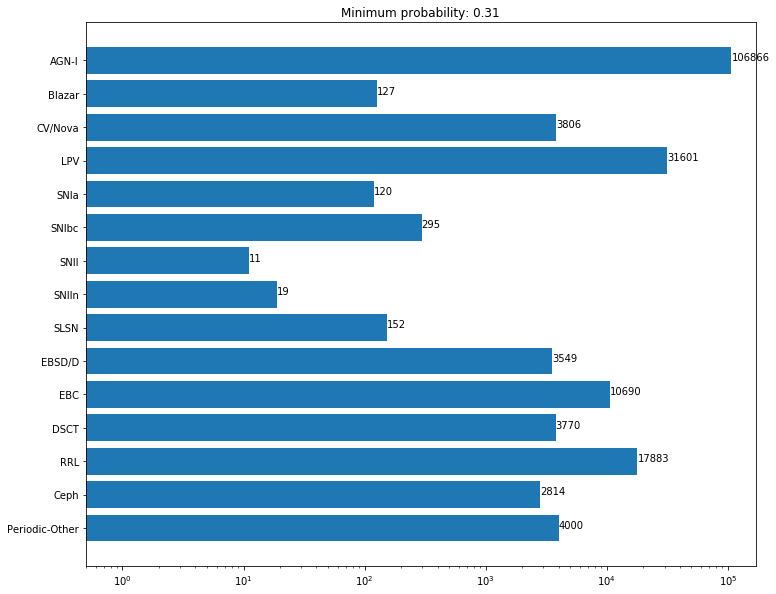

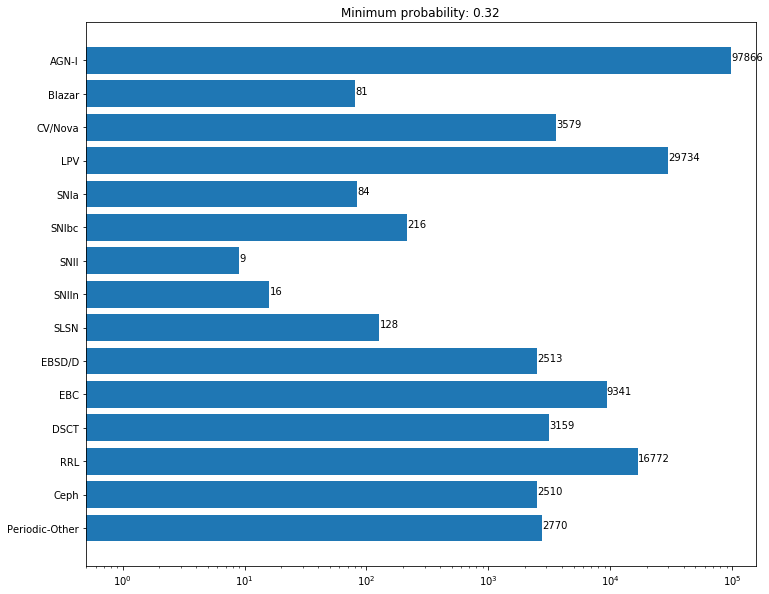

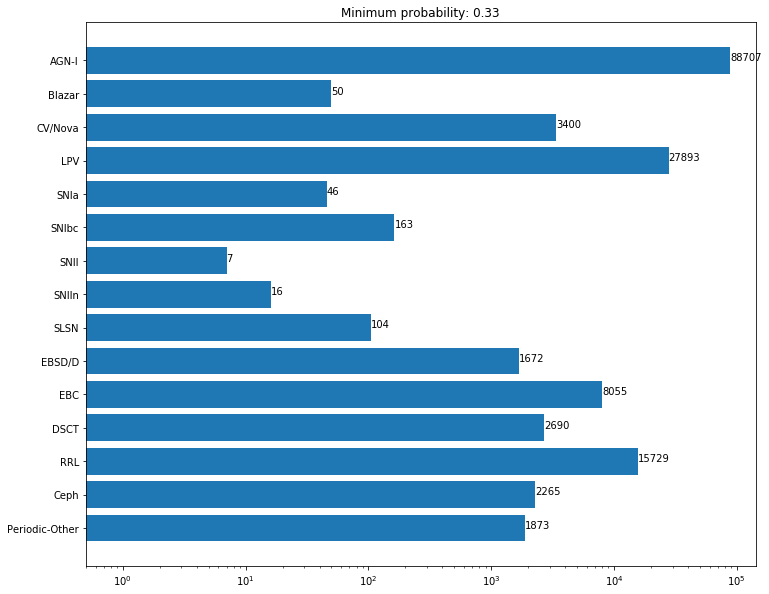

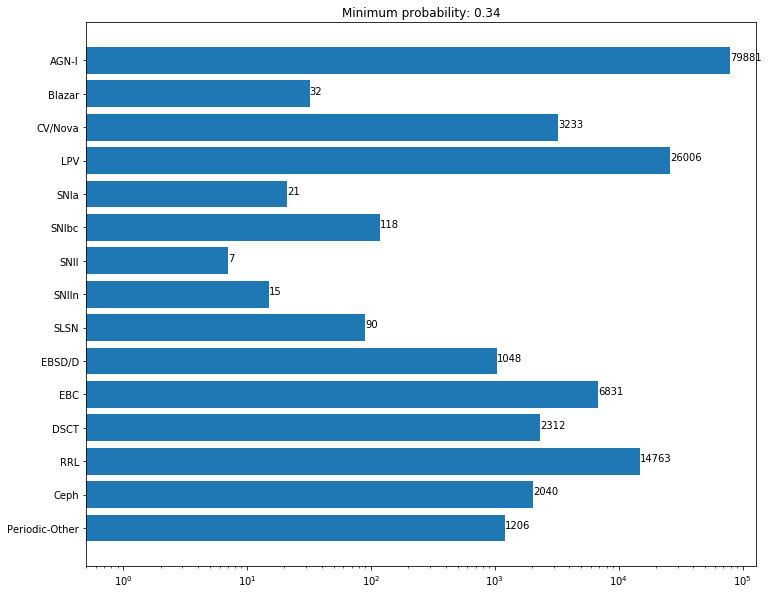

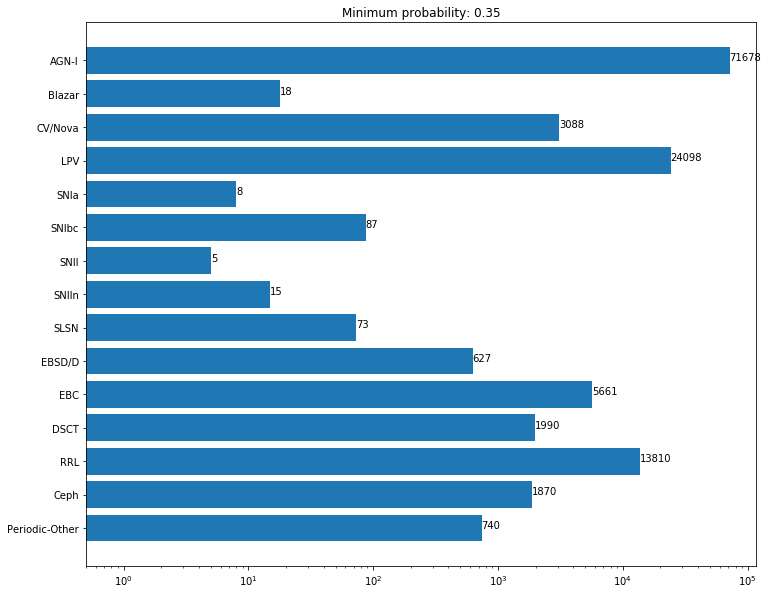

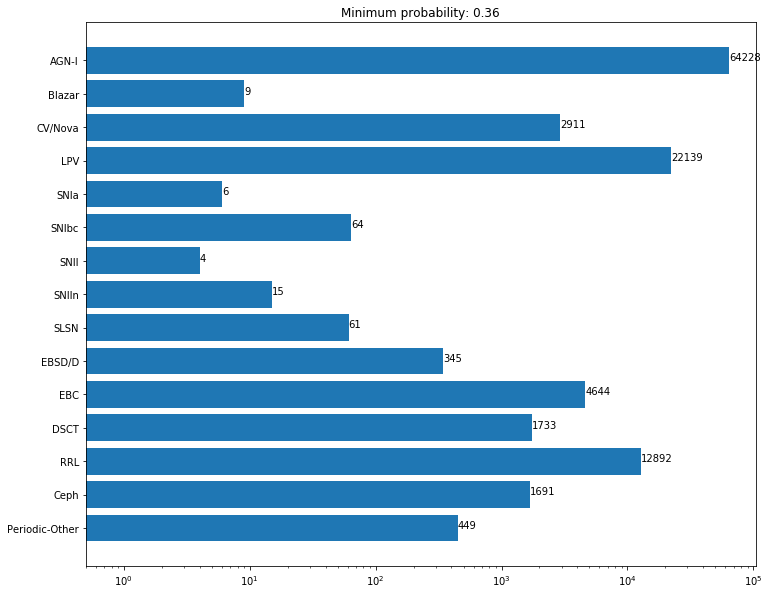

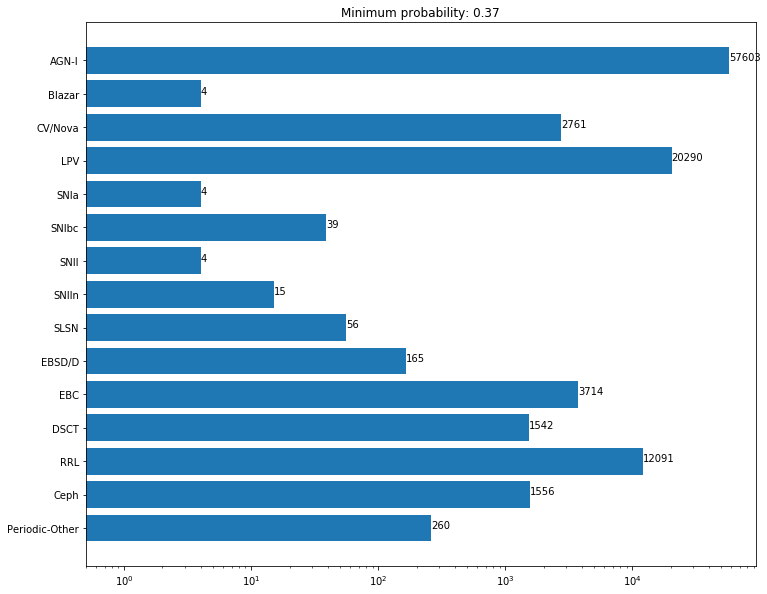

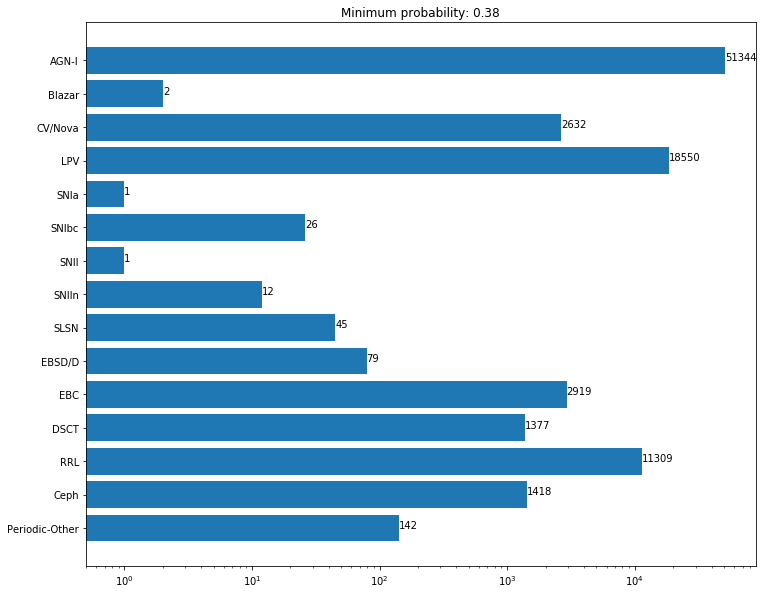

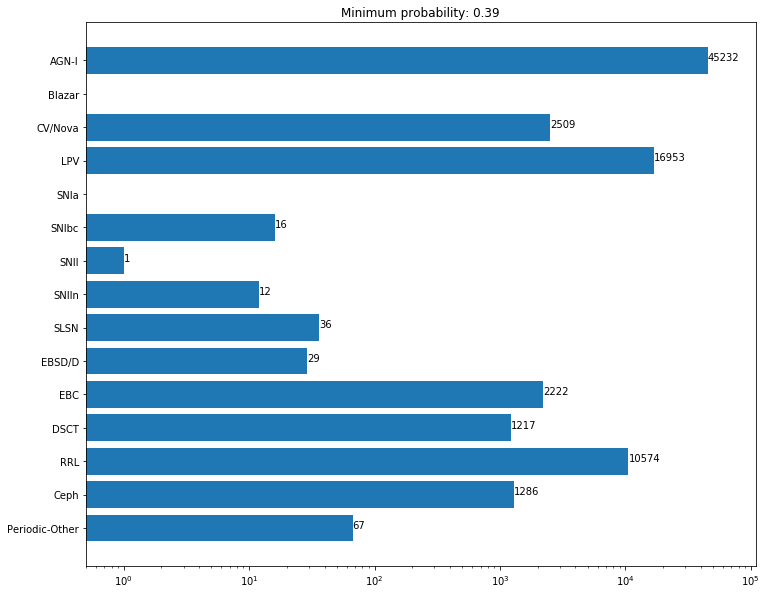

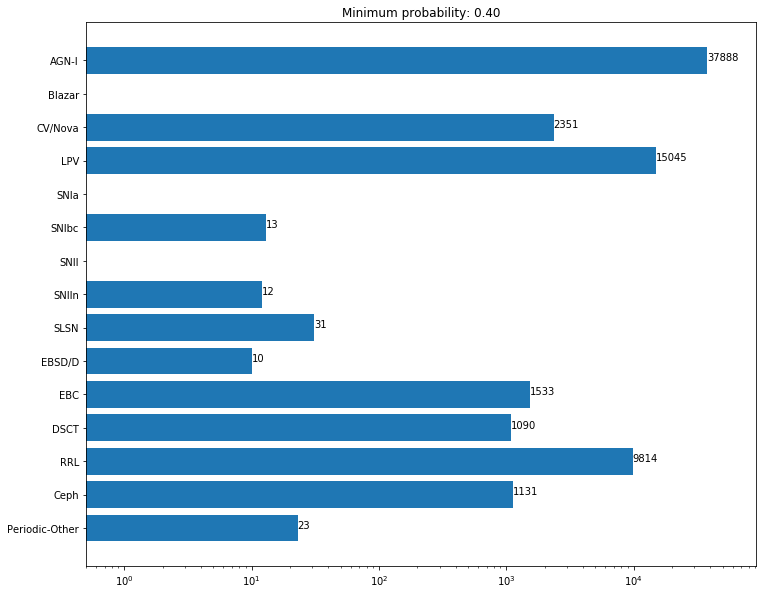

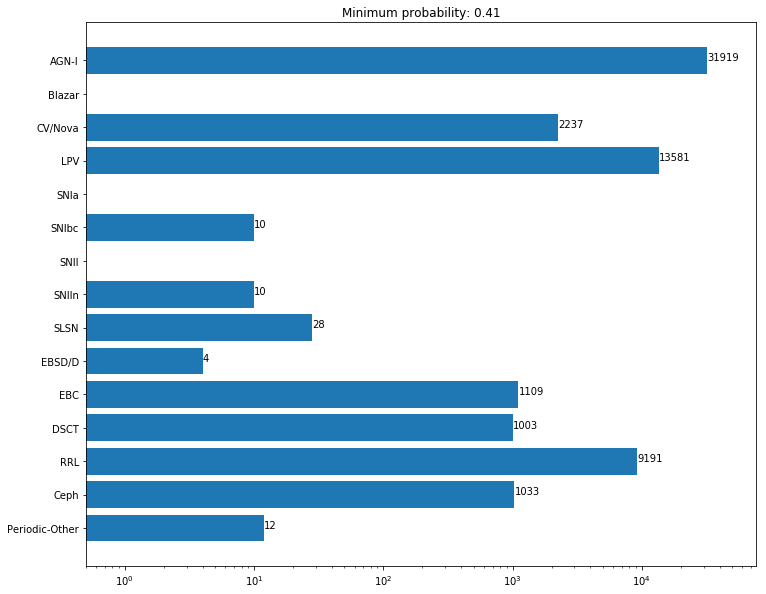

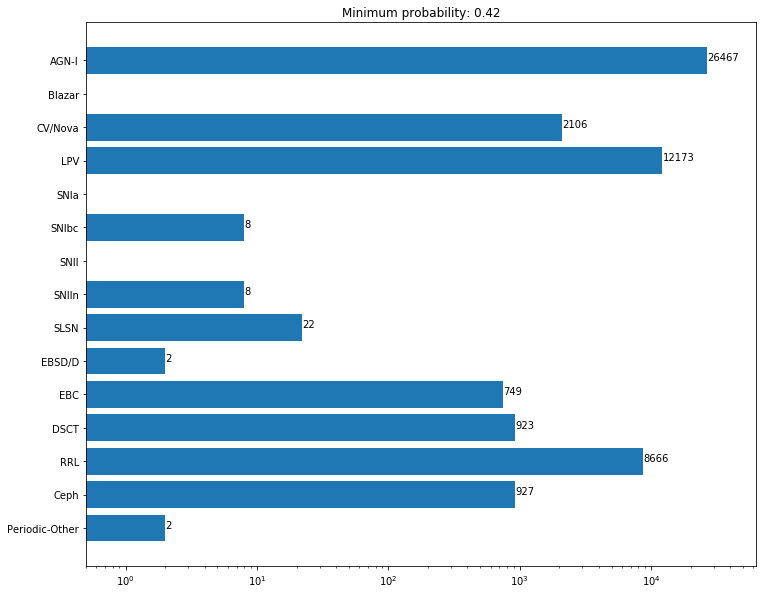

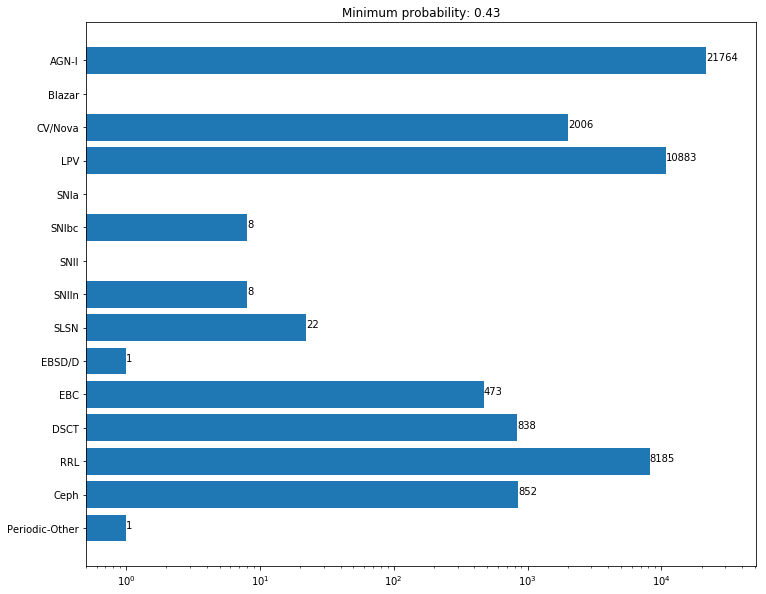

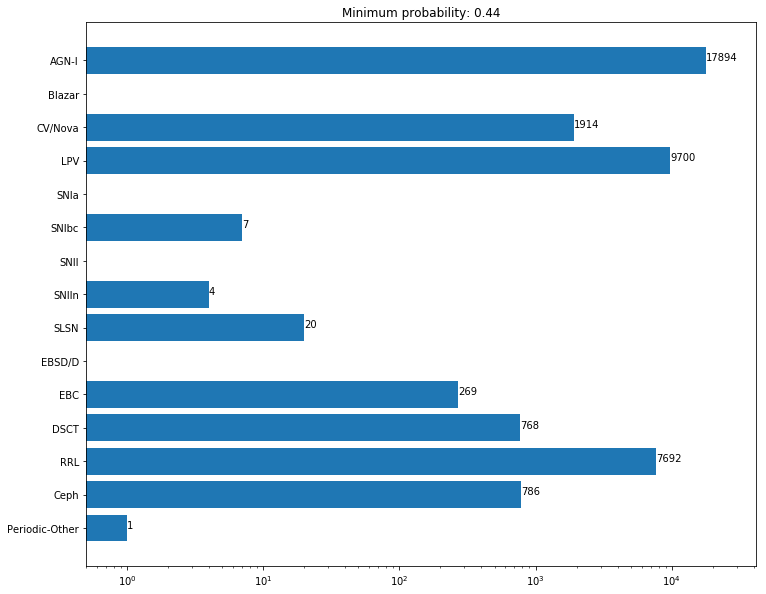

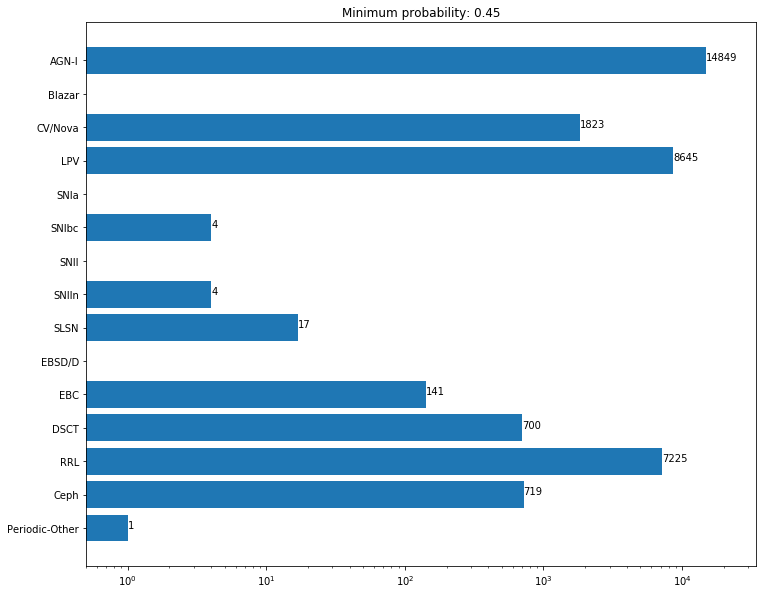

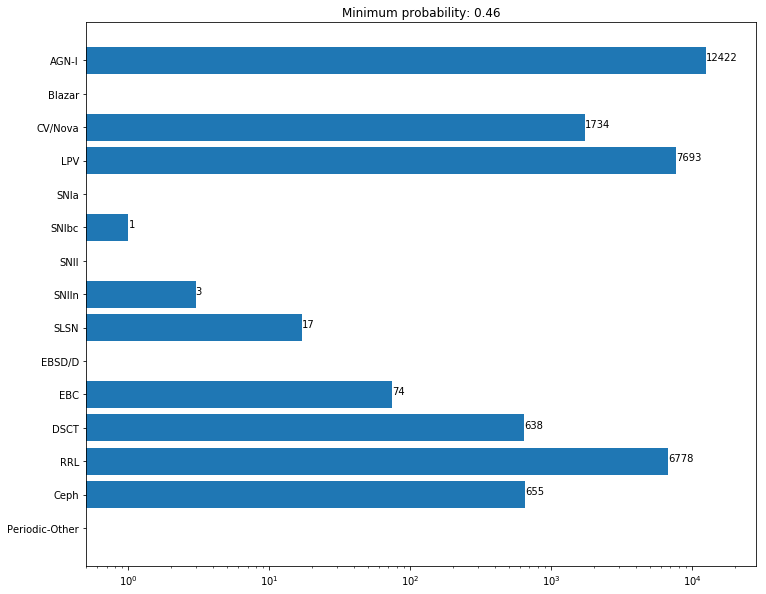

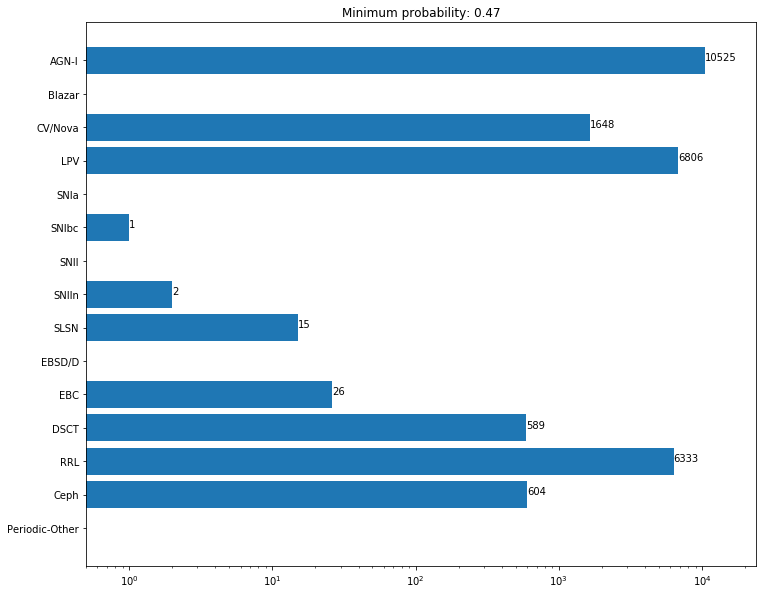

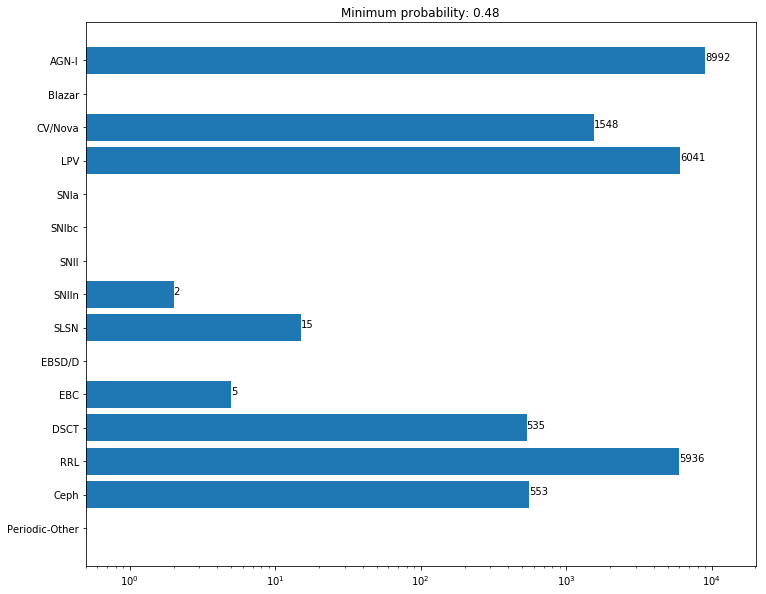

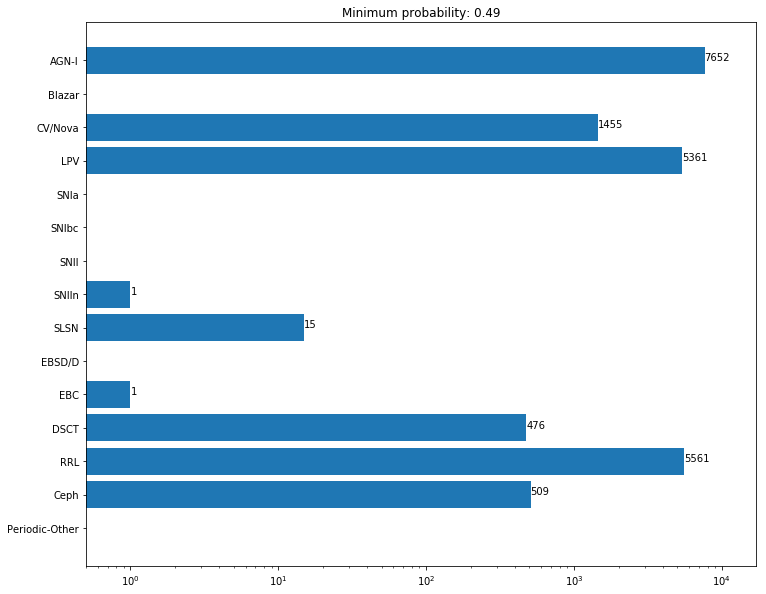

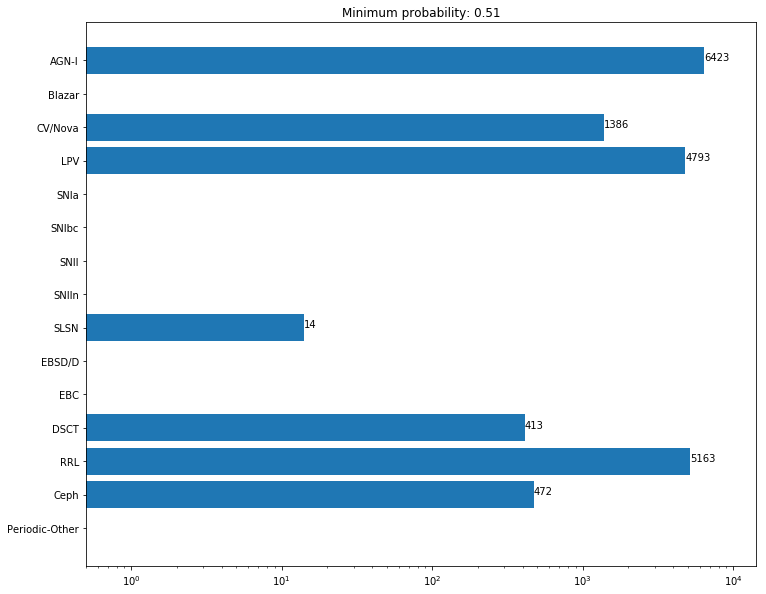

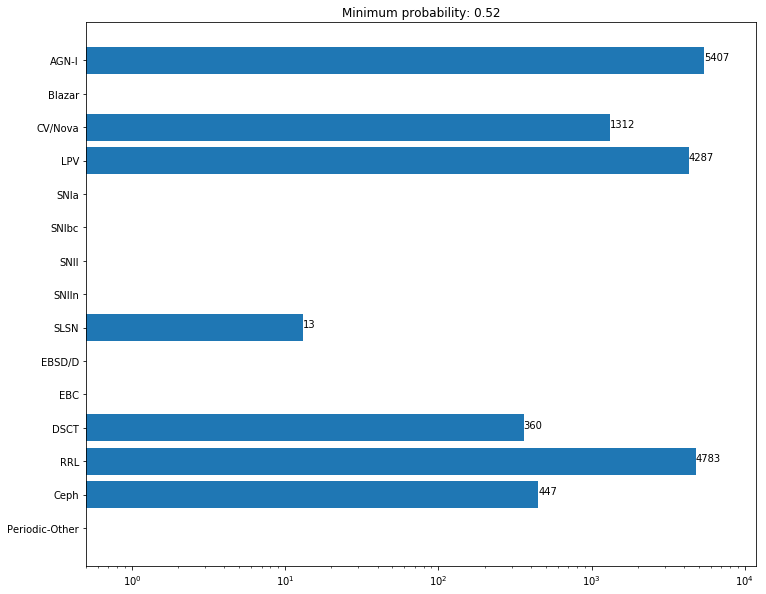

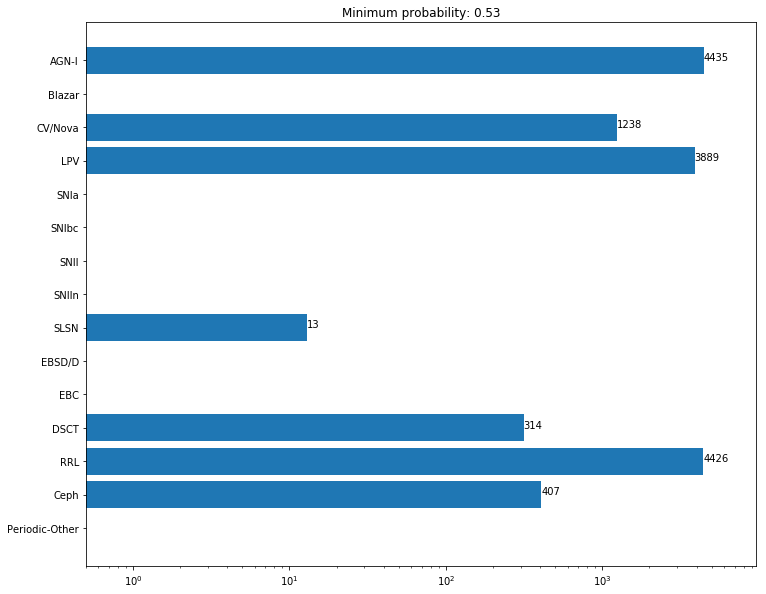

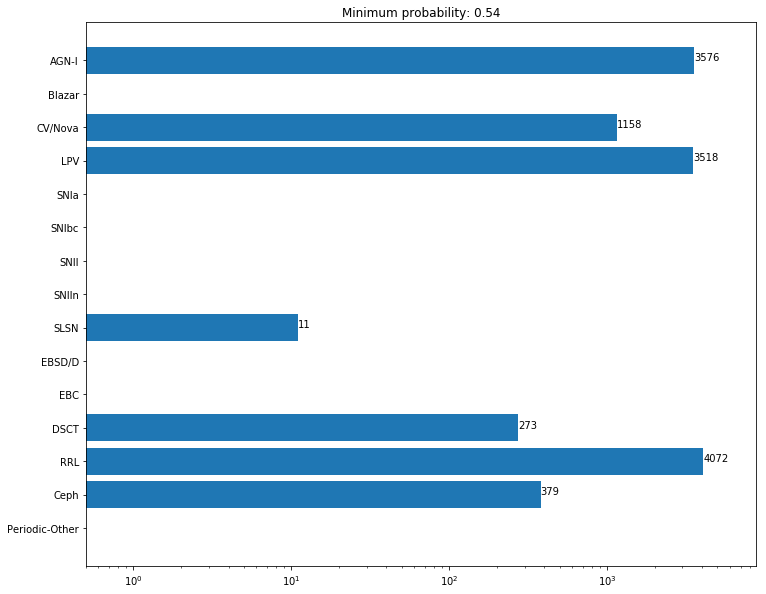

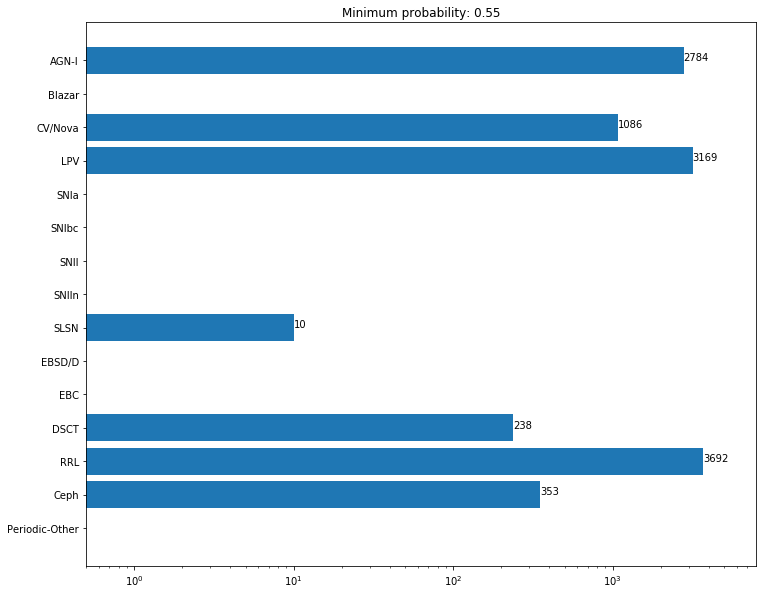

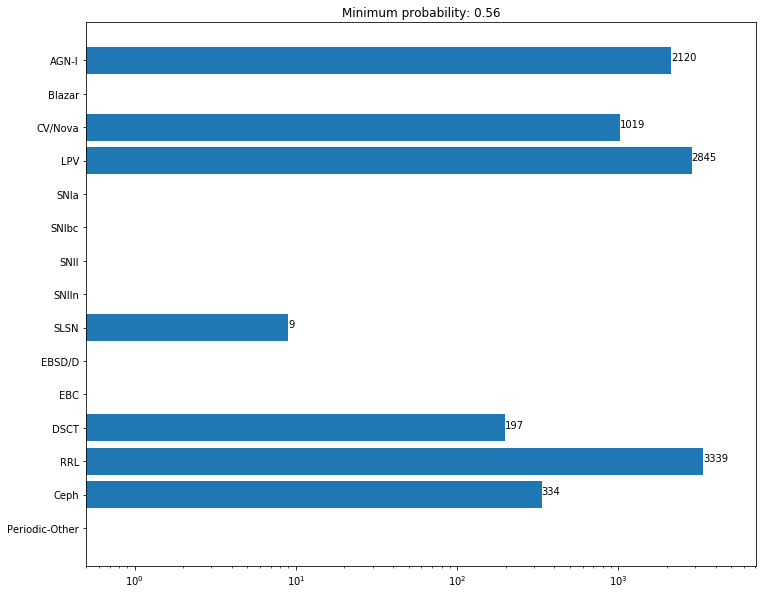

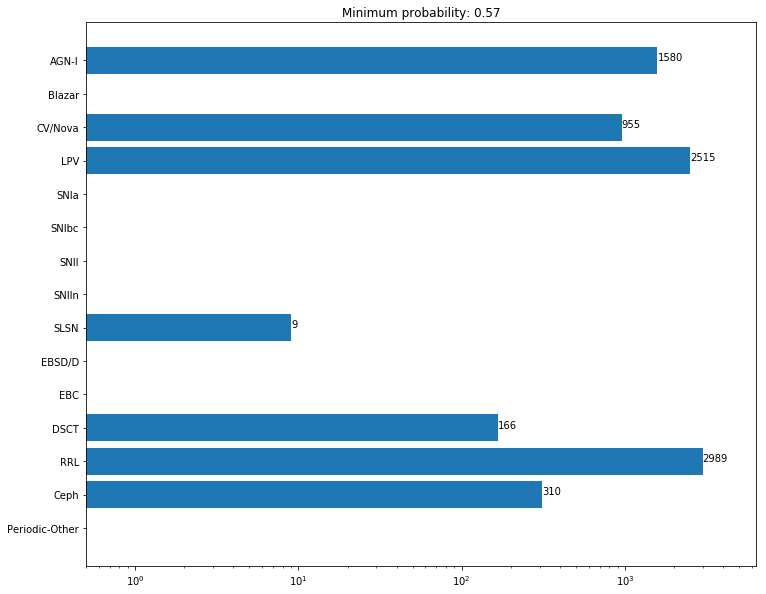

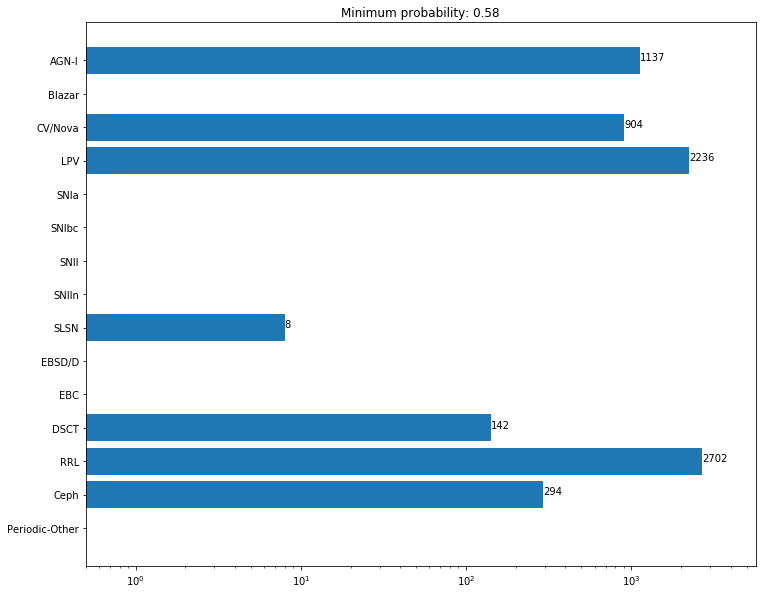

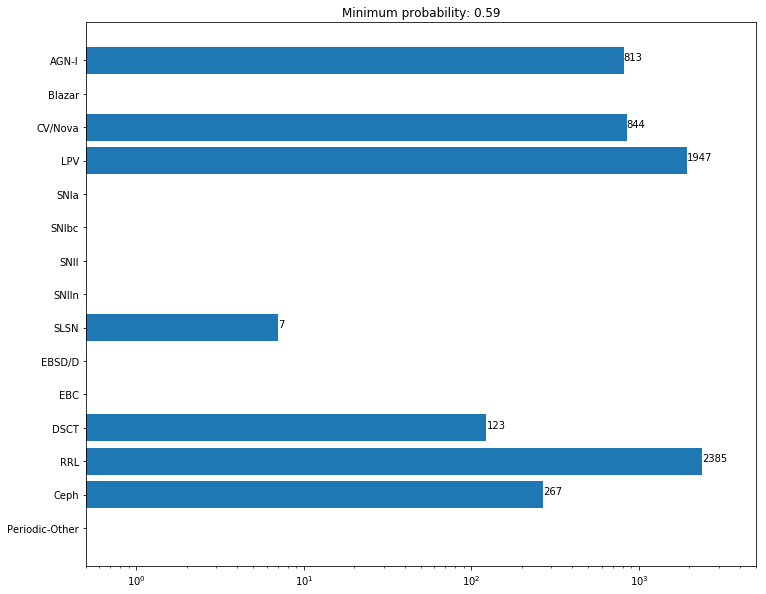

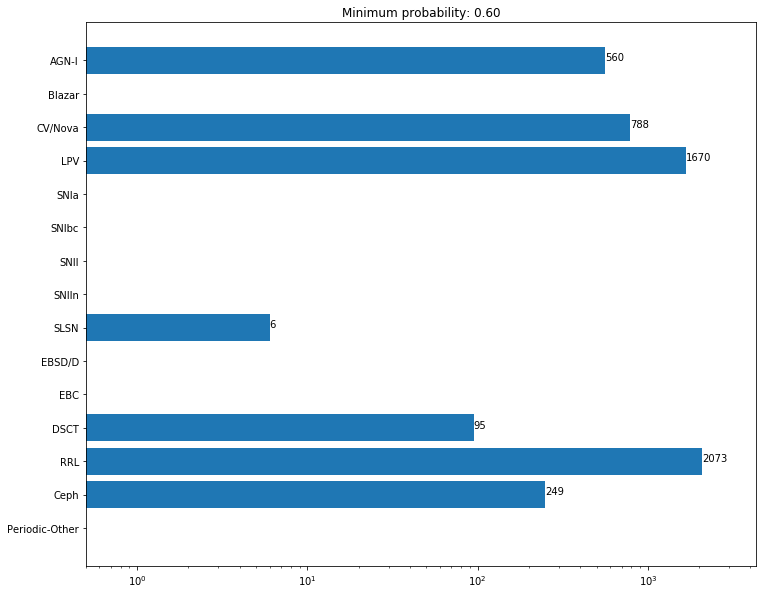

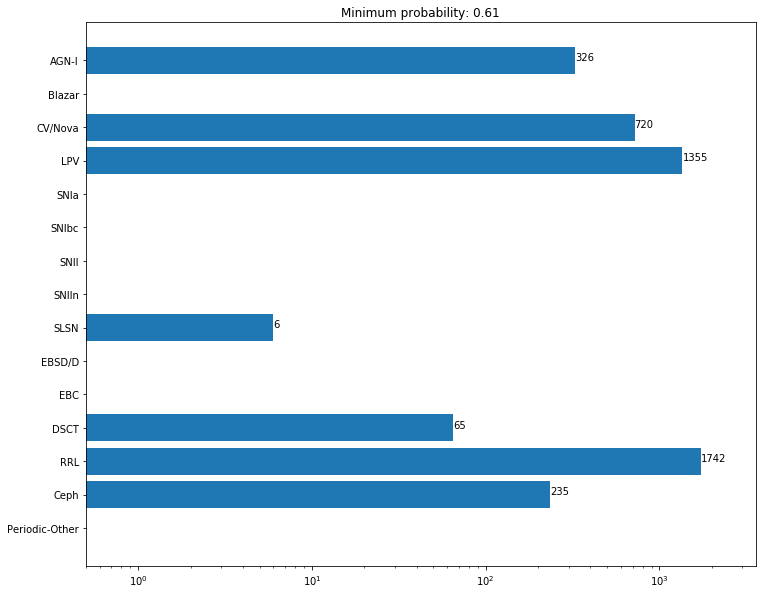

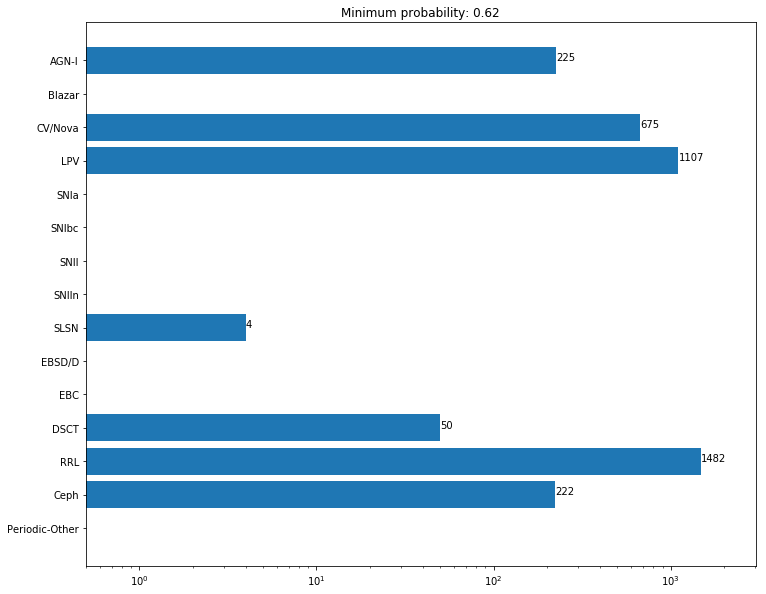

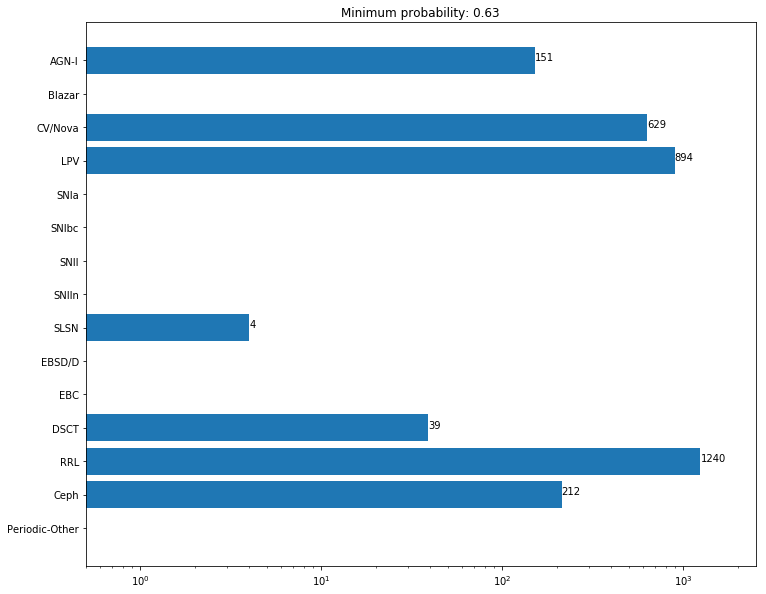

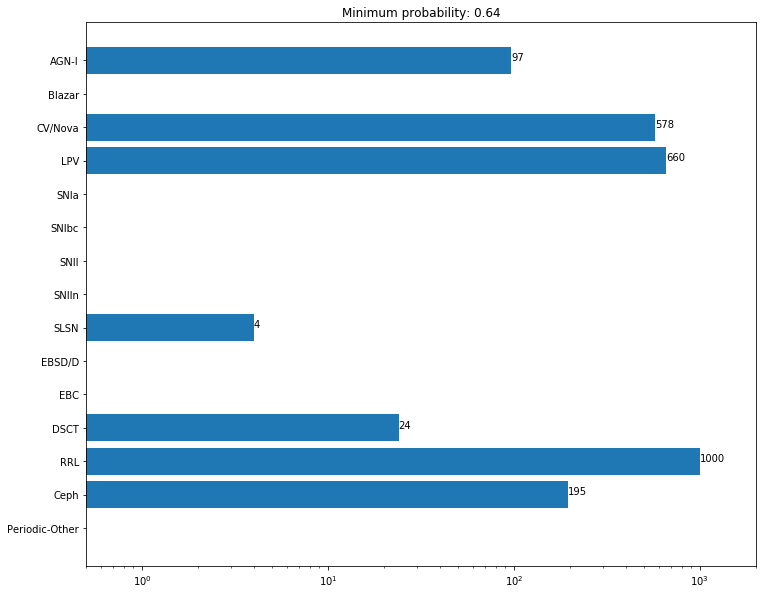

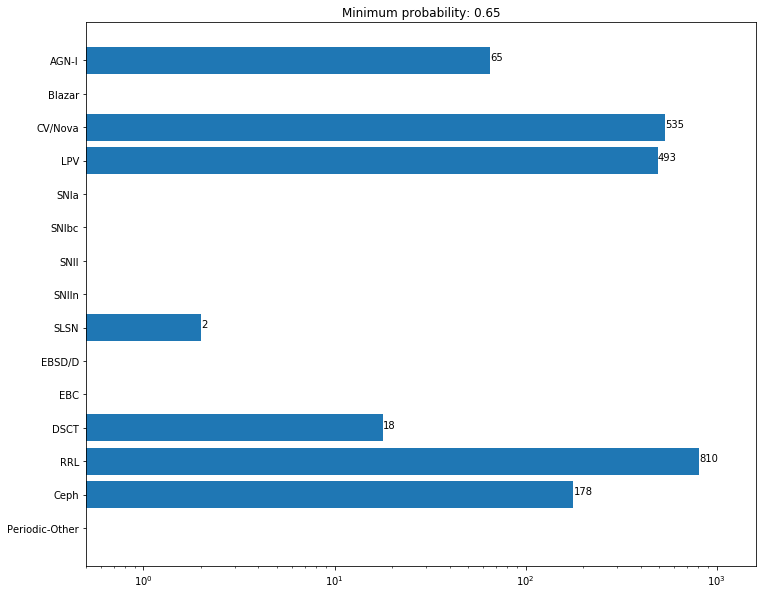

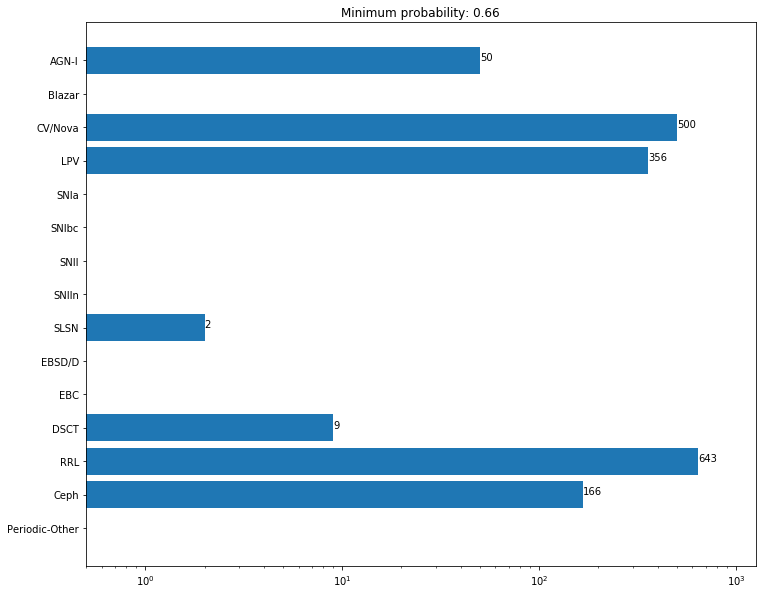

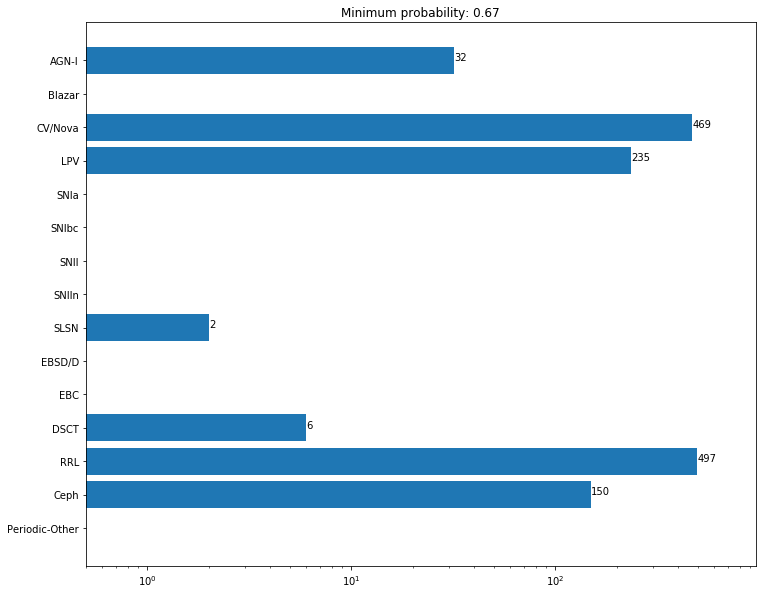

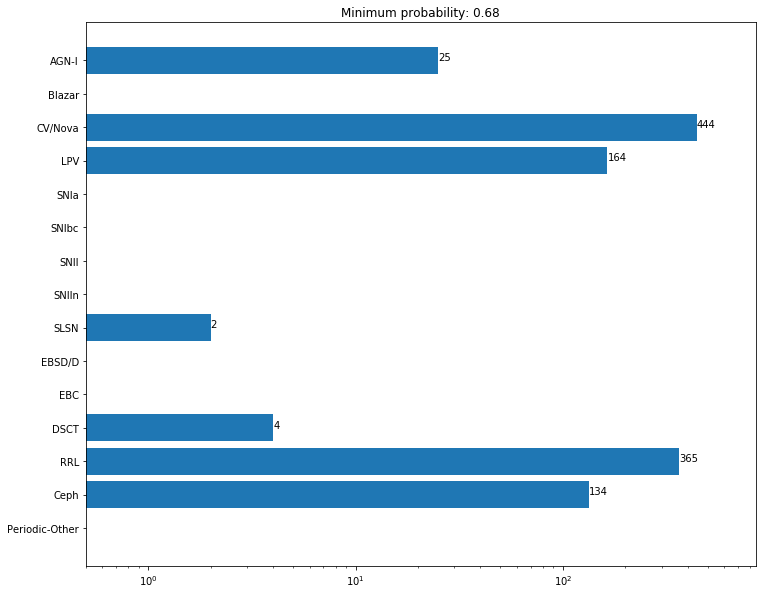

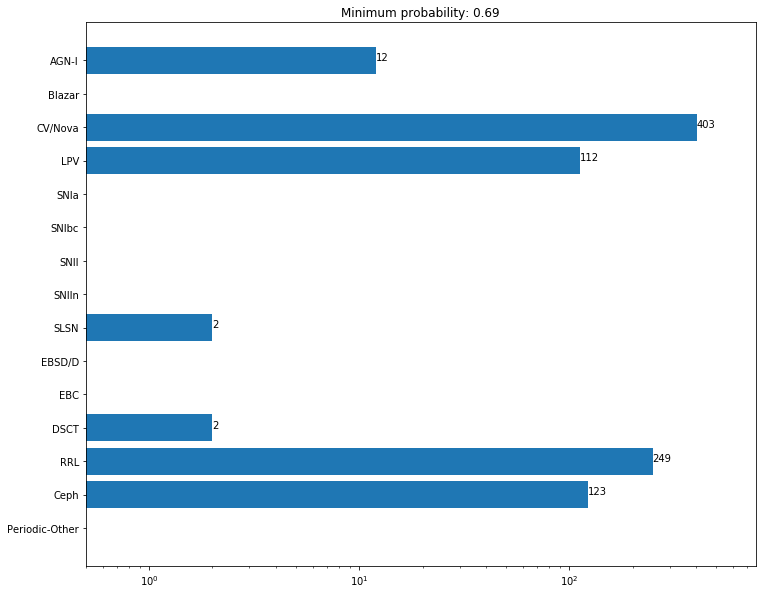

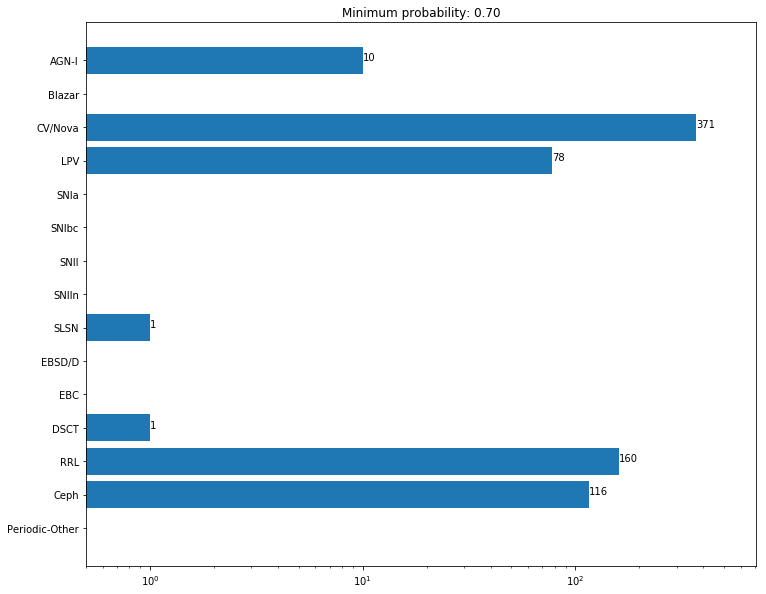

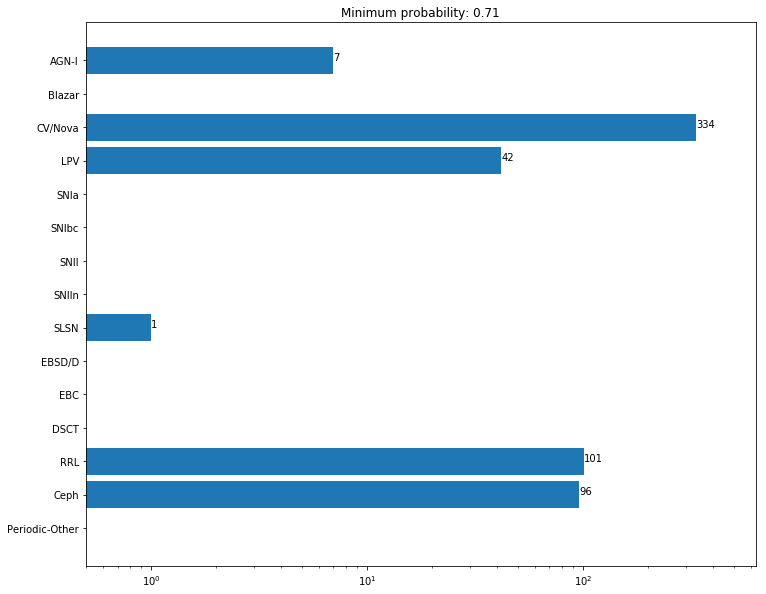

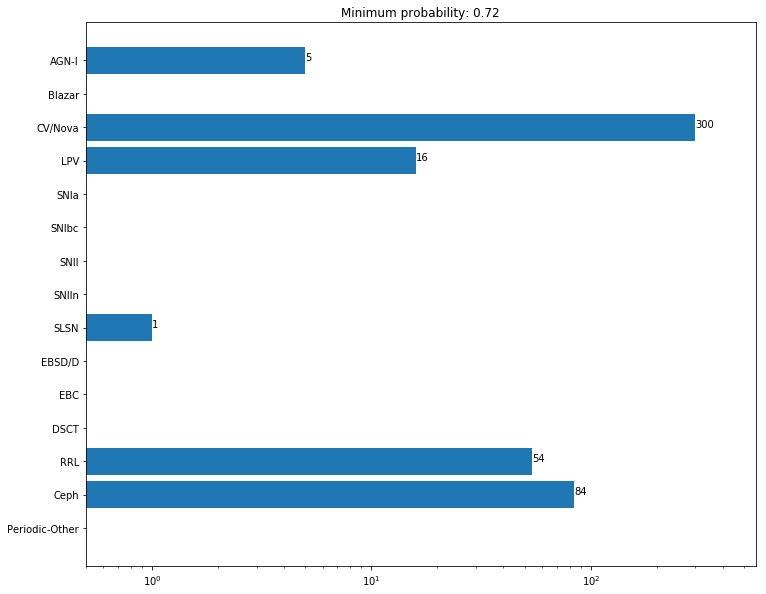

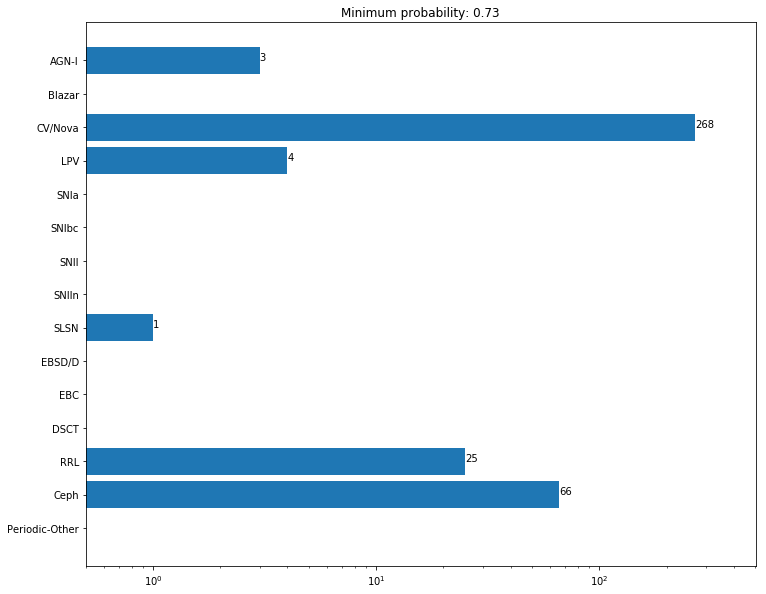

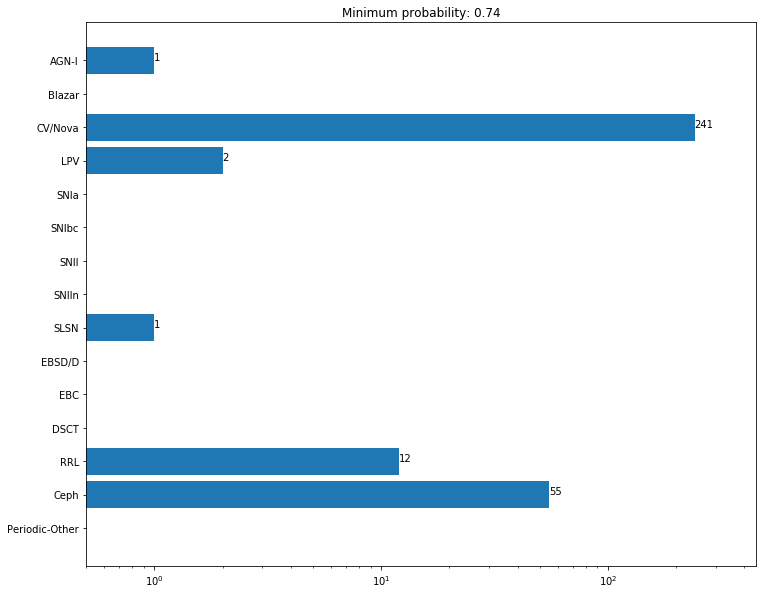

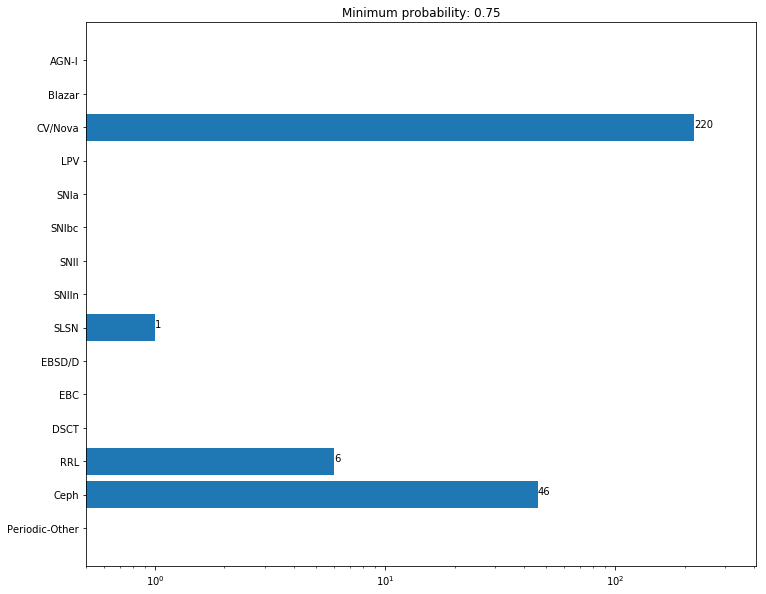

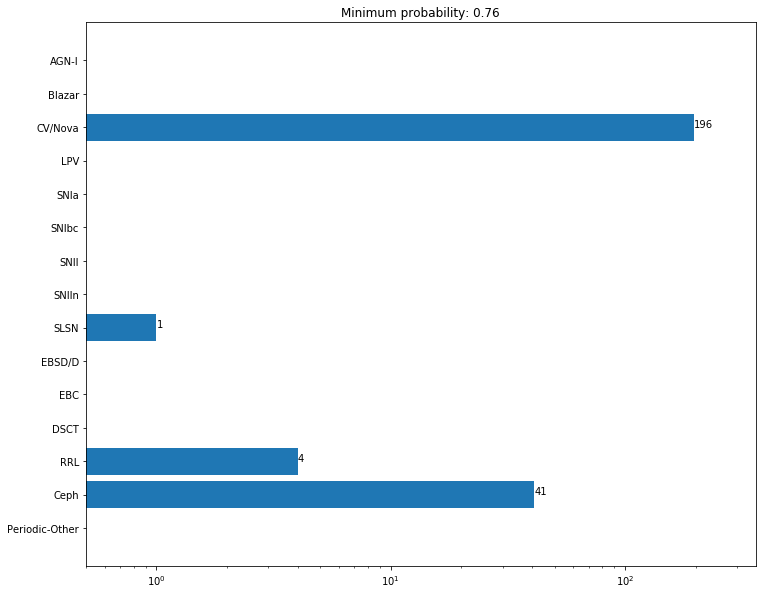

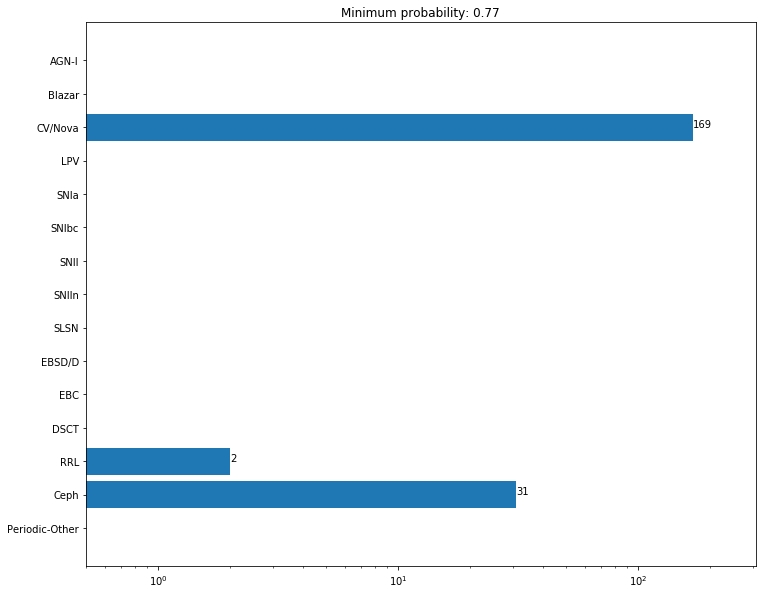

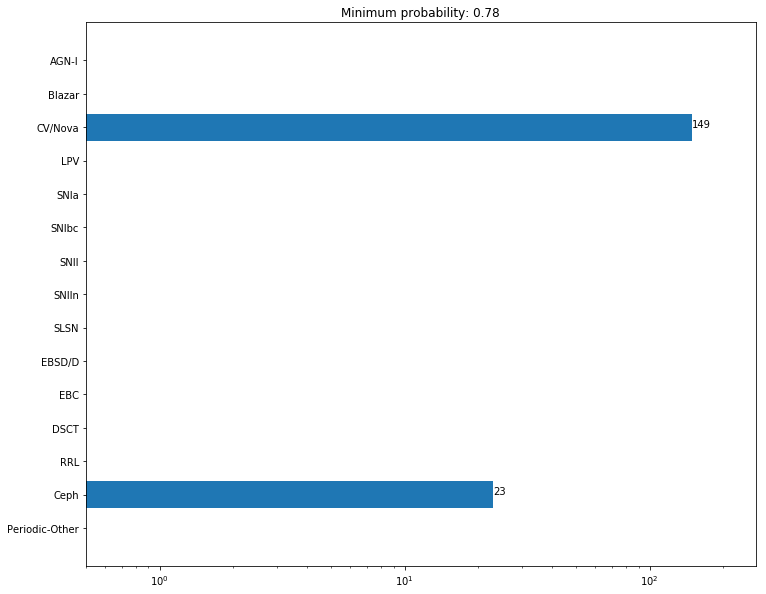

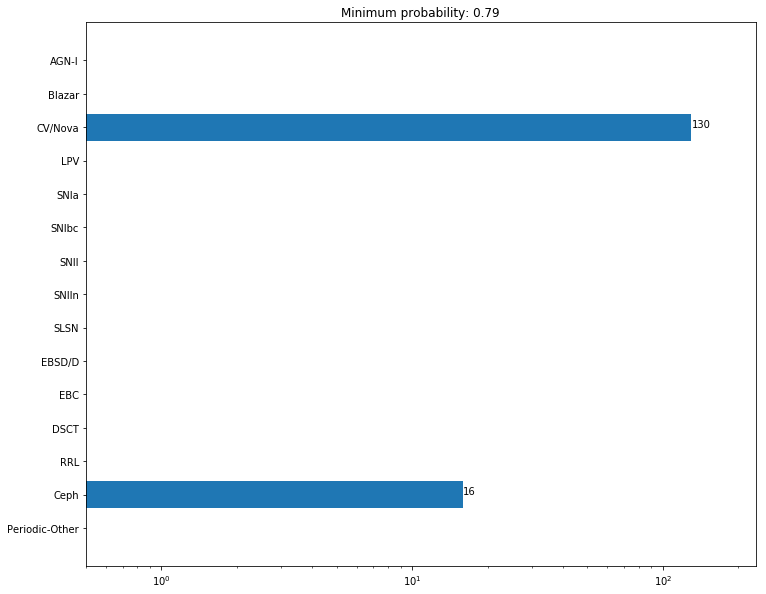

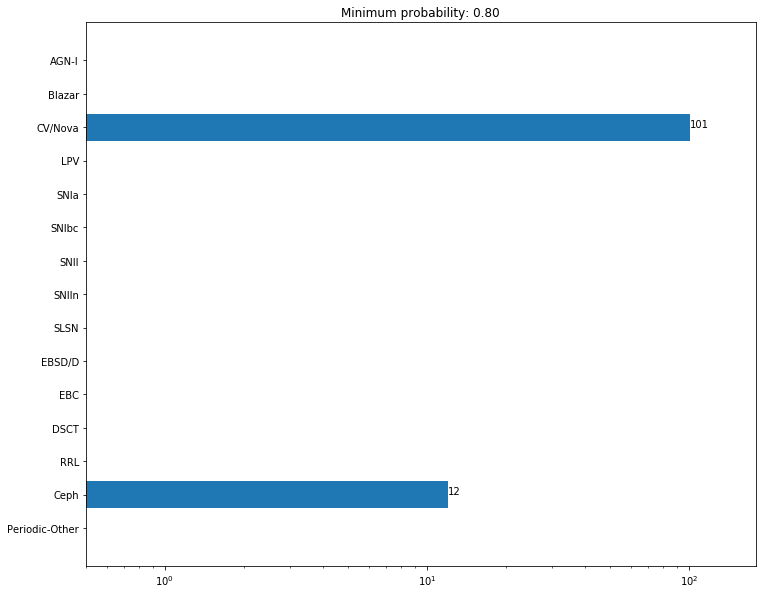

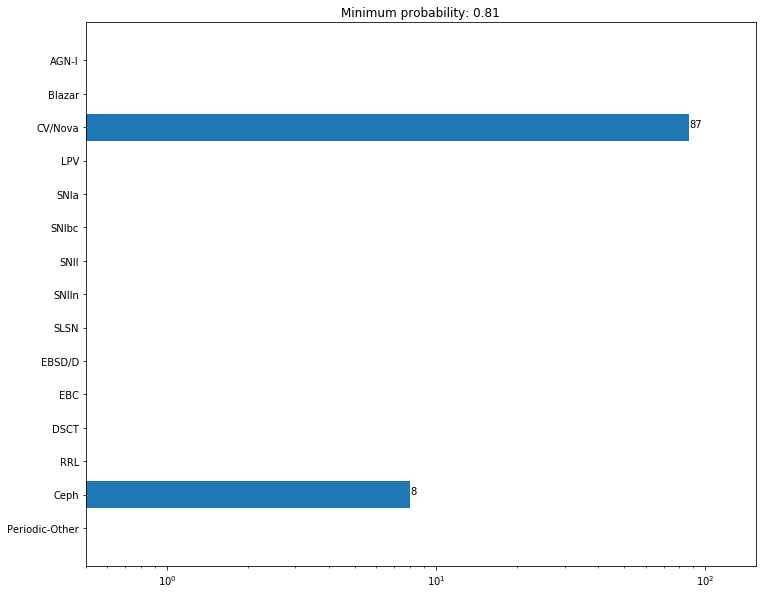

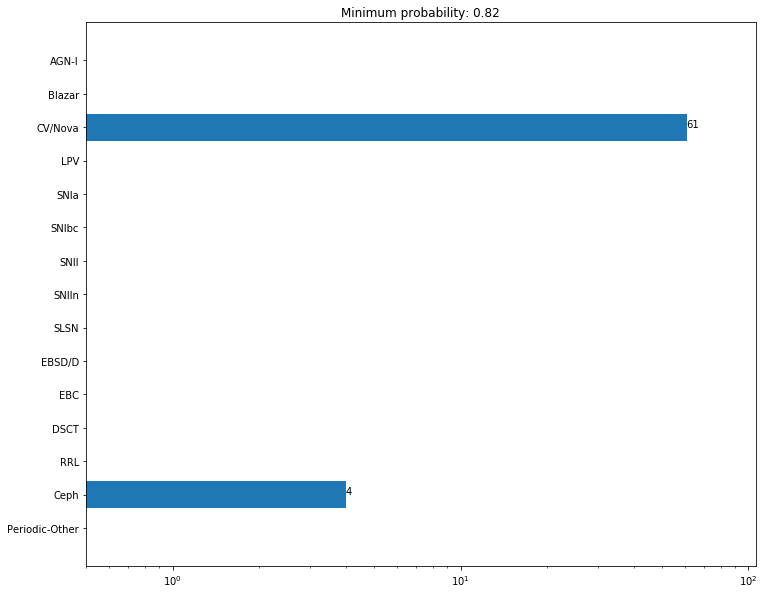

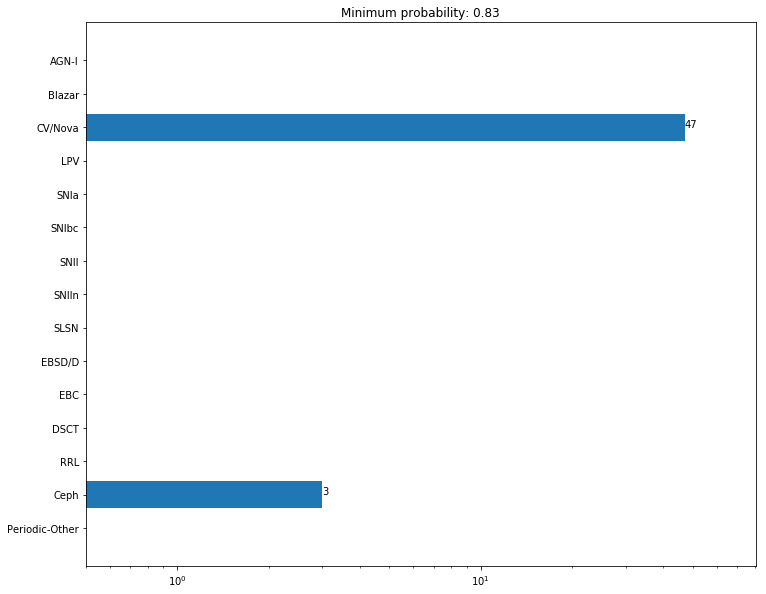

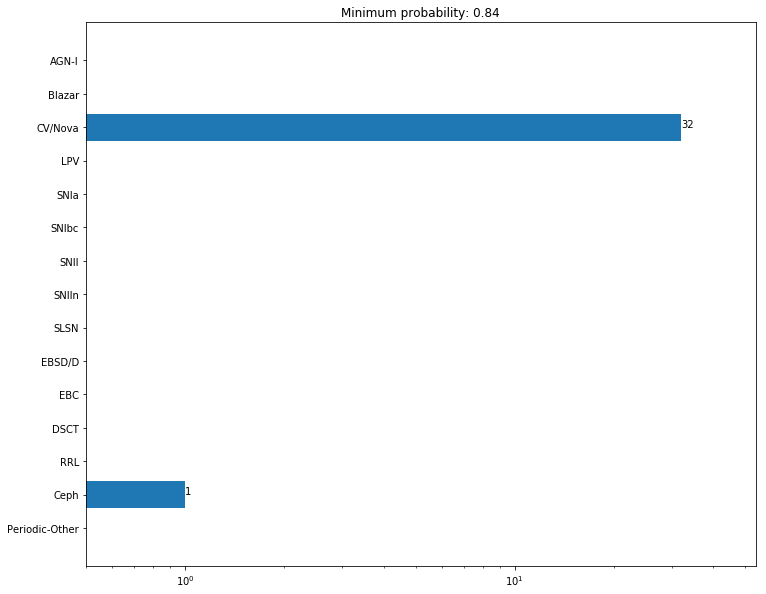

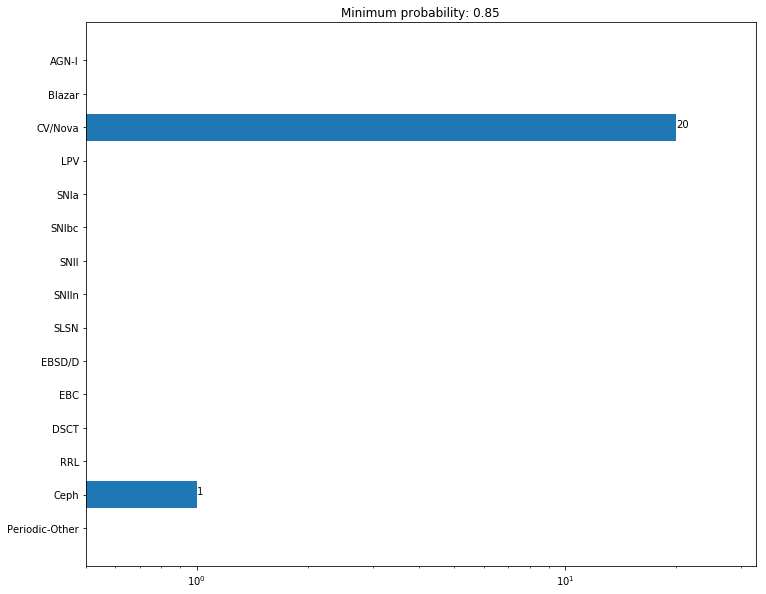

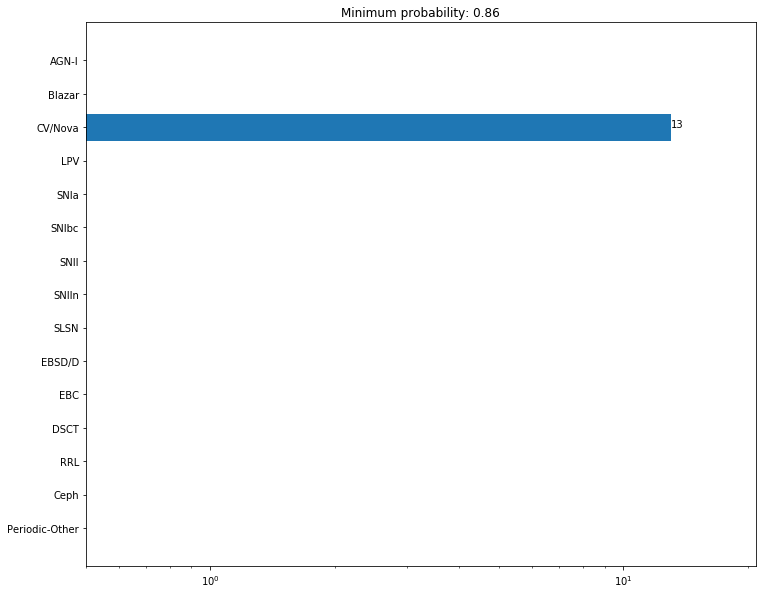

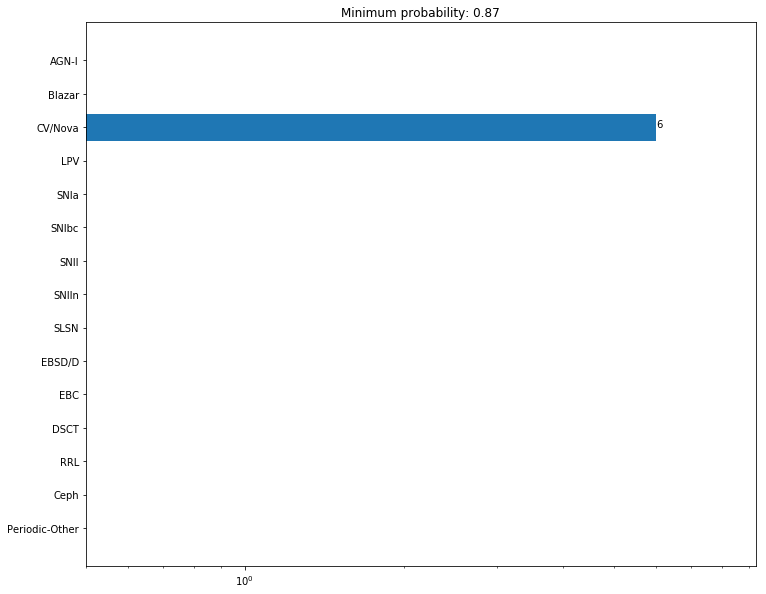

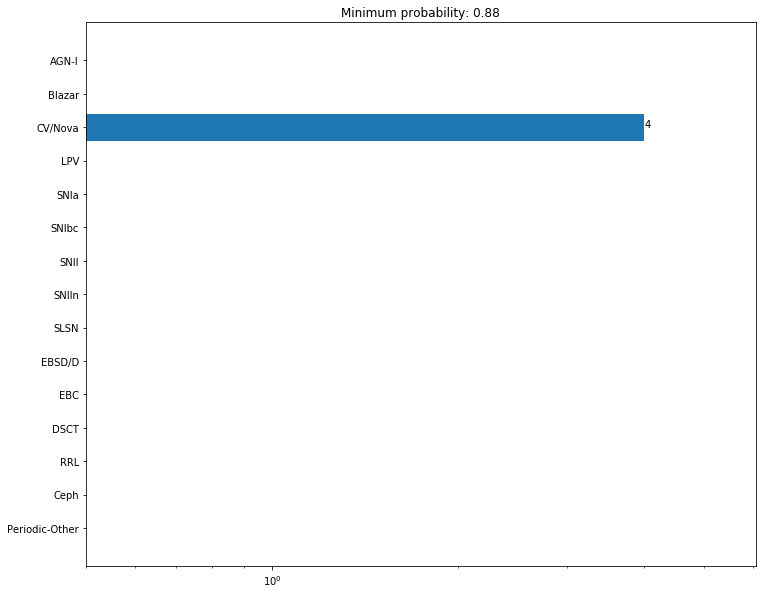

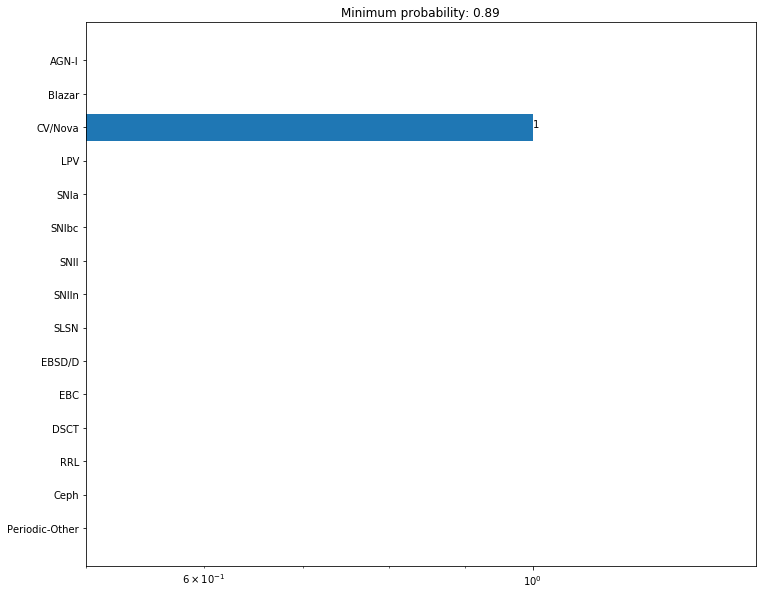

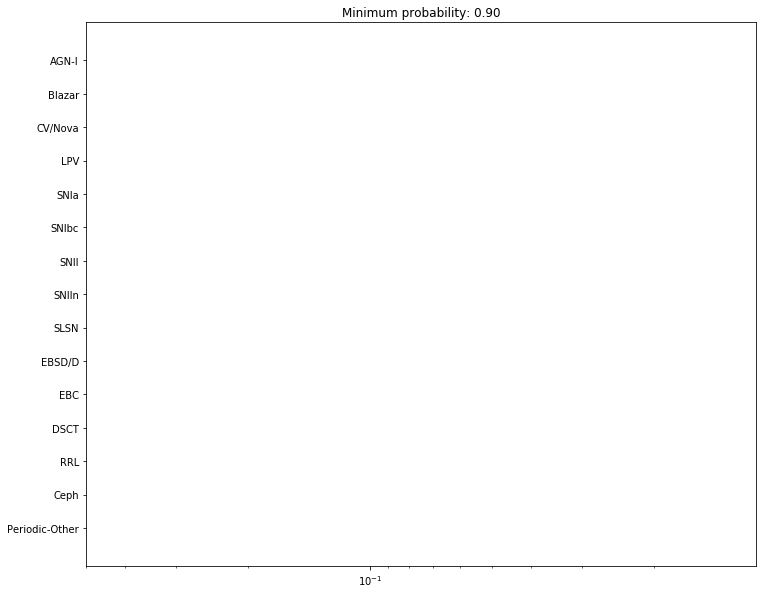

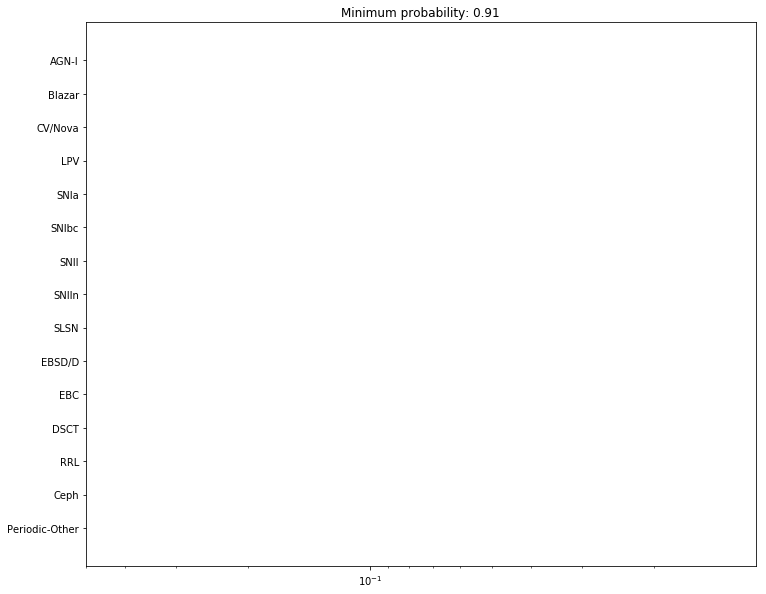

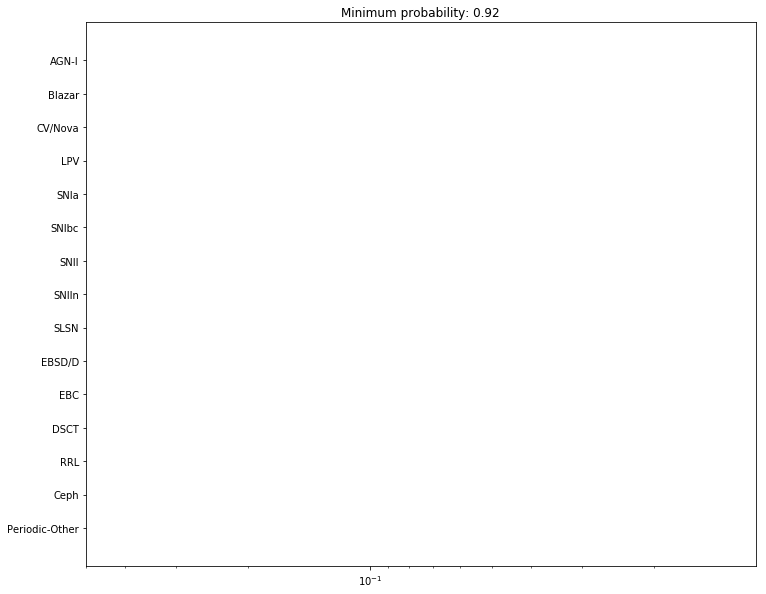

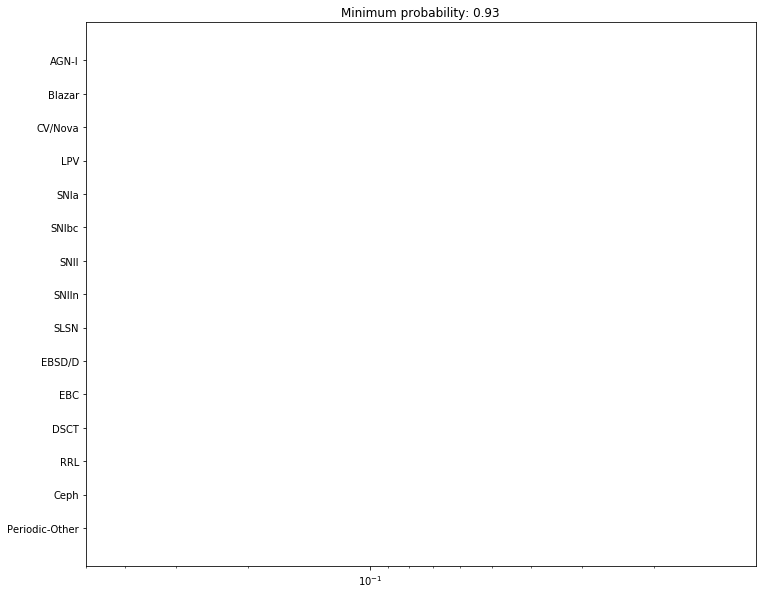

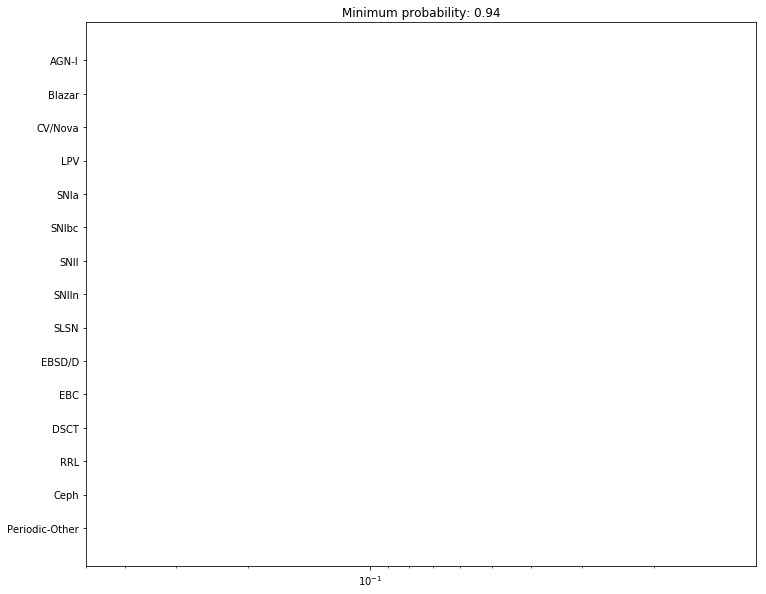

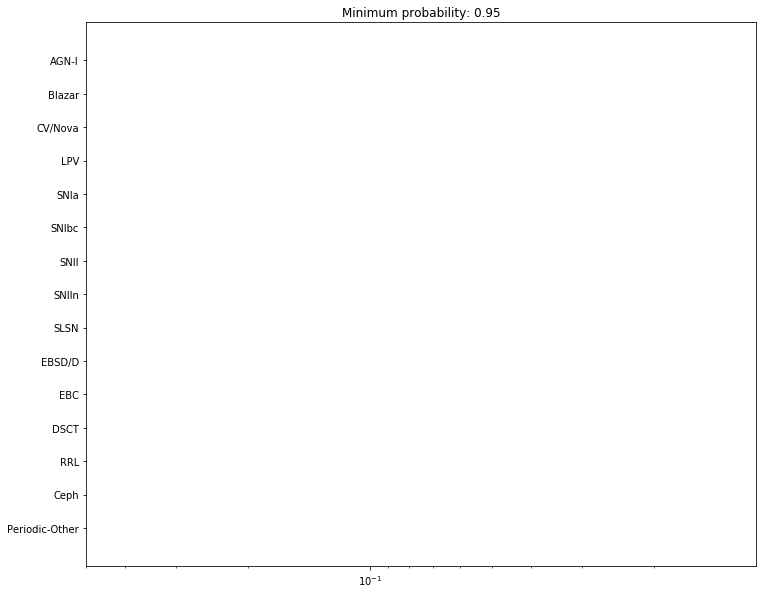

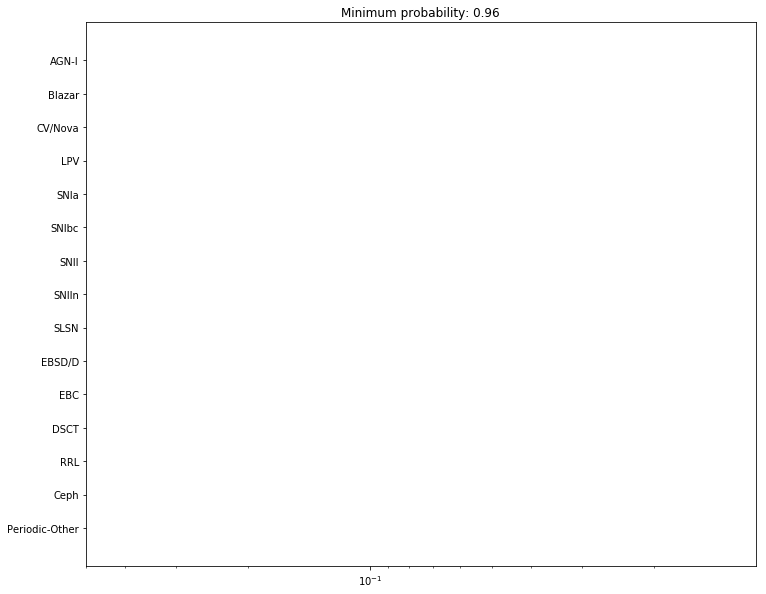

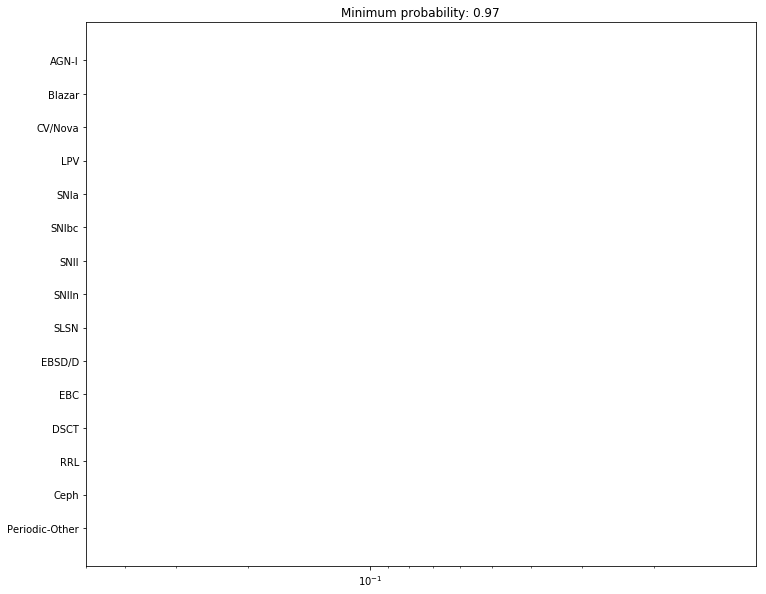

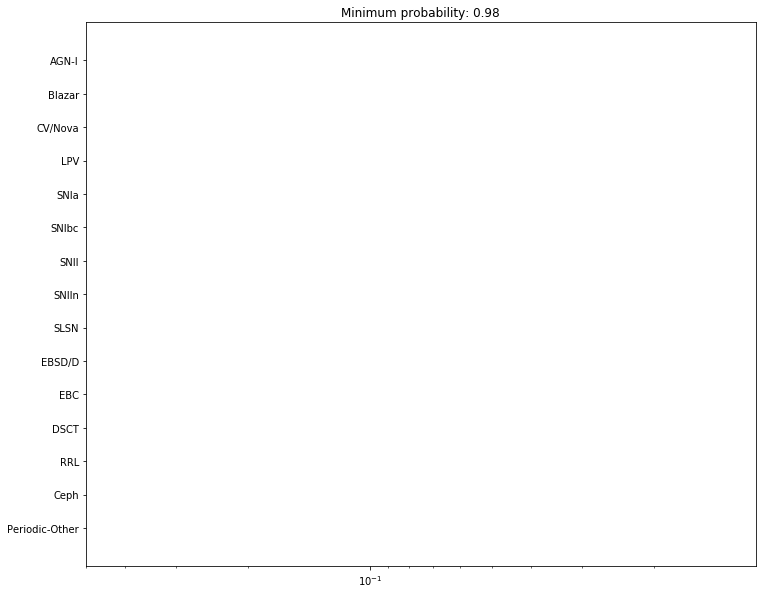

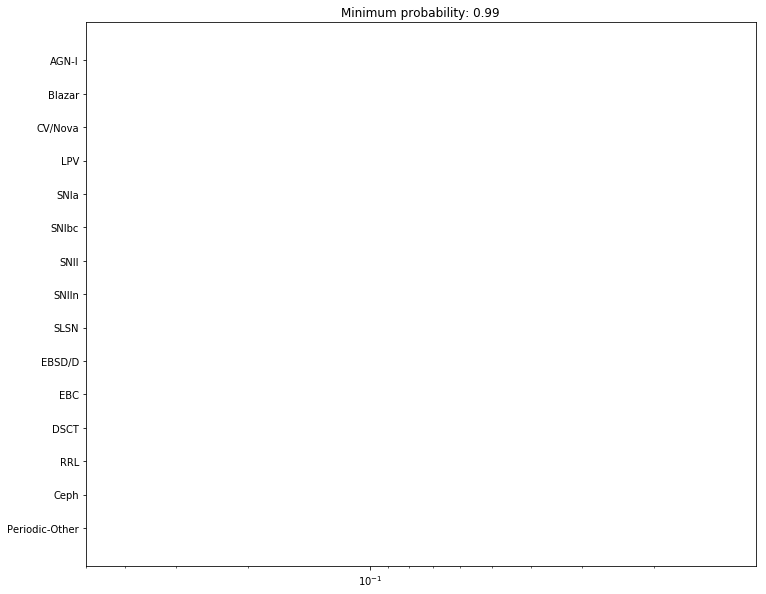

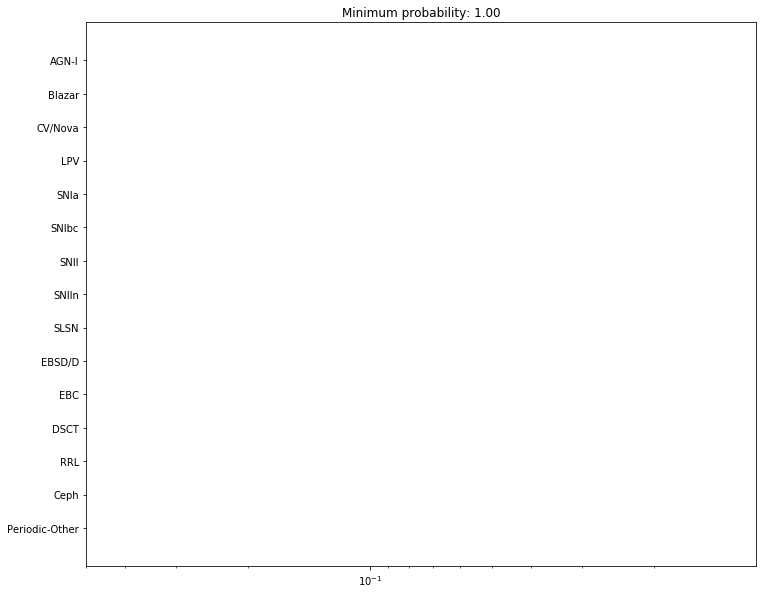

In [222]:
for prob_lim in np.linspace(0, 1, 100):
    fig, ax = plt.subplots(figsize=(12, 10))

    counts = {}
    for idx, cl in enumerate(class_order[::-1]):
        cl = "%s_prob" % cl
        mask = df_cl[cl][cl] > prob_lim
        if mask.sum() > 0:
            counts[cl] = len(df_cl[cl][cl].loc[mask])
            ax.text(counts[cl], idx, counts[cl])
        else:
            counts[cl] = 1e-3

    ax.barh(range(len(counts.keys())), list(counts.values()))
    ax.set_xscale('log')
    ax.set_xlim(0.5, ax.get_xlim()[1])
    ax.yaxis.set_ticks(range(len(counts.keys())))
    ax.yaxis.set_ticklabels([x[:-5] for x in counts.keys()]);
    ax.set_title("Minimum probability: %.2f" % prob_lim)
    
    plt.savefig("histogram_minprob%.2f.png" % prob_lim)

In [154]:
supernova = {
        "internal_name": "ZTF19abyikbv"
        }

# construct list of (key,value) pairs
json_data = [('api_key', (None, api_key)),
            ('data', (None, json.dumps(supernova)))]

json_url = url_tns_api + '/get/search'
response = requests.post(json_url, files = json_data)

objname = response.json()["data"]["reply"][0]["objname"]
data = {
        "objname": objname,
        "photometry": "1",
        "spectra": "0"
        }

# construct list of (key,value) pairs
json_data = [('api_key', (None, api_key)),
            ('data', (None, json.dumps(data)))]

json_url = url_tns_api + '/get/object'
response = requests.post(json_url, files = json_data)

groupname = response.json()["data"]["reply"]["source_group"]["group_name"]
photometry = response.json()["data"]["reply"]["photometry"]

# Extract data from TNS (API approach)

# Sandbox or real

In [51]:
sandbox = False # True: test in sandbox, False: send to real website

# Get API key and url

In [52]:
if sandbox:
    print("Getting API sandbox key...")
    api_key = open("API_sandbox.key", "r").read()
else:
    print("Getting API key...")
    api_key = open("API.key", "r").read()
    
if sandbox:
    url_tns_api="https://sandbox-tns.weizmann.ac.il/api"
else:
    url_tns_api="https://wis-tns.weizmann.ac.il/api"
    
if not sandbox:
    print("WARNING: submitting to real (not sandbox) TNS website")

Getting API key...


In [53]:
# function for changing data to json format
def format_to_json(source):
    # change data to json format and return
    parsed = json.loads(source, object_pairs_hook = OrderedDict)
    result = json.dumps(parsed, indent = 4)
    return result

In [222]:
mask = all_alerce["Discovering Group/s"] != "ALeRCE"

In [232]:
dtALeRCE = {}
telescope_2ndreport = {}

for name in all_alerce.loc[mask].Name.values:
    objname = name[3:]
    data = {
            "objname": objname,
            "photometry": "1",
            "spectra": "0"
            }

    # construct list of (key,value) pairs
    json_data = [('api_key', (None, api_key)),
                ('data', (None, json.dumps(data)))]

    json_url = url_tns_api + '/get/object'
    response = requests.post(json_url, files = json_data)

    groupname = response.json()["data"]["reply"]["source_group"]["group_name"]
    photometry = response.json()["data"]["reply"]["photometry"]
    
    times = []
    telescopes = []
    for i in photometry:
        if i["remarks"][:20] != "[Last non detection]":
            print("   ", objname, i["jd"], i["remarks"], i["telescope"]["name"])
            times.append(float(i["jd"]))
            telescopes.append(i["telescope"]["name"])

    try:
        times = np.array(times)
        telescopes = np.array(telescopes, dtype=str)
        idxsorted = np.argsort(times)
        times = times[idxsorted]
        telescopes = telescopes[idxsorted]
        dtimes = times - times[0]
        mask_rep = (dtimes > 0.5) # remove repetitions within the same night 
        dtimes = dtimes[mask_rep]
        telescopes = telescopes[mask_rep]
        dtALeRCE[objname] = dtimes[0]
        telescope_2ndreport[objname] = telescopes[0]
        print(objname, dtALeRCE[objname], telescope_2ndreport[objname])
        
        if telescope_2ndreport[objname] == "P48":
            print(times, telescopes)
    except:
        print("Error with object %s" % objname)

    2019rij 2458756.92  ATLAS1
    2019rij 2458754.7899306 Data provided by ZTF P48
2019rij 2.130069399718195 ATLAS1
    2019qvm 2458752.985  PS1
    2019qvm 2458750.8140394 Data provided by ZTF P48
2019qvm 2.1709606000222266 PS1
    2019qvf 2458756.7359954  ATLAS1
    2019qvf 2458753.6939931  Gaia
    2019qvf 2458750.6438542 Data provided by ZTF P48
2019qvf 3.0501389000564814 Gaia
    2019qsp 2458750.9359954  PS1
    2019qsp 2458753.9769907  ATLAS1
    2019qsp 2458749.8163542 Data provided by ZTF P48
2019qsp 1.1196412001736462 PS1
    2019qsg 2458754.915  PS1
    2019qsg 2458755.9479977  ATLAS1
    2019qsg 2458749.8163542 Data provided by ZTF P48
    2019qsg 2458749.792963 Data provided by ZTF P48
2019qsg 5.122037000022829 PS1
    2019qsc 2458751.1979977  Gaia
    2019qsc 2458749.6360995 Data provided by ZTF P48
2019qsc 1.5618981998413801 Gaia
    2019qqd 2458753.0859954  PS1
    2019qqd 2458748.9211458 Data provided by ZTF P48
2019qqd 4.164849599823356 PS1
    2019qqc 2458754.0779977

    2019ptb 2458744.7339931  ATLAS1
    2019ptb 2458743.73  Gaia
    2019ptb 2458734.6495833 Data provided by ZTF P48
2019ptb 9.08041669987142 Gaia
    2019pqp 2458744.0649884  PS1
    2019pqp 2458737.0002662  P48
    2019pqp 2458737.0002662  P48
    2019pqp 2458737.0002662  P48
    2019pqp 2458737.0002662  P48
    2019pqp 2458734.005544 Data provided by ZTF P48
    2019pqp 2458734.005544  P48
    2019pqp 2458734.005544  P48
    2019pqp 2458734.005544  P48
    2019pqp 2458734.005544  P48
2019pqp 2.9947222000919282 P48
[2458734.005544  2458734.005544  2458734.005544  2458734.005544
 2458734.005544  2458737.0002662 2458737.0002662 2458737.0002662
 2458737.0002662 2458744.0649884] ['P48' 'P48' 'P48' 'P48' 'PS1']
    2019pqo 2458737.7659954  ATLAS1
    2019pqo 2458733.712419 Data provided by ZTF P48
2019pqo 4.053576400037855 ATLAS1
    2019pqn 2458737.6285301  P48
    2019pqn 2458737.6285301  P48
    2019pqn 2458737.6285301  P48
    2019pqn 2458733.712419  P48
    2019pqn 2458733.712419 Da

    2019ozi 2458728.7985995  P48
    2019ozi 2458725.814213 Data provided by ZTF P48
    2019ozi 2458725.8142245  P48
2019ozi 2.9843865004368126 P48
[2458725.814213  2458725.8142245 2458728.7985995] ['P48']
    2019ozf 2458728.8039931  ATLAS1
    2019ozf 2458737.8091667  P48
    2019ozf 2458737.8091667  P48
    2019ozf 2458737.8091667  P48
    2019ozf 2458725.7897801 Data provided by ZTF P48
    2019ozf 2458725.7897801  P48
    2019ozf 2458737.7875926  P48
    2019ozf 2458737.7875926  P48
    2019ozf 2458737.7875926  P48
    2019ozf 2458725.7639815 Data provided by ZTF P48
    2019ozf 2458725.7639815  P48
2019ozf 3.0400115996599197 ATLAS1
    2019oxv 2458751.0859954  PS1
    2019oxv 2458724.9827431 Data provided by ZTF P48
2019oxv 26.103252300061285 PS1
    2019oxt 2458724.6813079 Data provided by ZTF P48
    2019oxt 2458724.6751968 Data provided by ZTF P48
    2019oxt 2458718.6809606  P48
    2019oxt 2458724.6538079 Data provided by ZTF P48
    2019oxt 2458724.6533565  P48
    2019oxt

    2019oot 2458719.9869907  ATLAS1
    2019oot 2458720.9025694  P48
    2019oot 2458720.9025694  P48
    2019oot 2458720.9025694  P48
    2019oot 2458720.9025579 Data provided by ZTF P48
    2019oot 2458723.8732523  P48
    2019oot 2458723.8732523  P48
    2019oot 2458723.8732523  P48
2019oot 0.915567200165242 P48
[2458719.9869907 2458720.9025579 2458720.9025694 2458720.9025694
 2458720.9025694 2458723.8732523 2458723.8732523 2458723.8732523] ['P48' 'P48' 'P48' 'P48' 'P48' 'P48' 'P48']
    2019oos 2458724.0739931  ATLAS1
    2019oos 2458720.9025694  P48
    2019oos 2458720.9025579 Data provided by ZTF P48
    2019oos 2458723.8732523  P48
2019oos 2.9706943999044597 P48
[2458720.9025579 2458720.9025694 2458723.8732523 2458724.0739931] ['P48' 'ATLAS1']
    2019oop 2458718.9629977  PS1
    2019oop 2458721.9819907  ATLAS1
    2019oop 2458723.8763542  P48
    2019oop 2458720.8913773  P48
    2019oop 2458720.8913657 Data provided by ZTF P48
2019oop 1.9283679998479784 P48
[2458718.9629977 245

    2019njp 2458754.0789931  PS1
    2019njp 2458722.0709954  PS1
    2019njp 2458719.0369907  ATLAS1
    2019njp 2458743.7829977  Gaia
    2019njp 2458711.9262963  P48
    2019njp 2458711.9262963  P48
    2019njp 2458707.9976968  P48
    2019njp 2458707.9976968 Data provided by ZTF P48
    2019njp 2458707.9976968  P48
2019njp 3.928599499631673 P48
[2458707.9976968 2458707.9976968 2458707.9976968 2458711.9262963
 2458711.9262963 2458719.0369907 2458722.0709954 2458743.7829977
 2458754.0789931] ['P48' 'P48' 'ATLAS1' 'PS1' 'Gaia' 'PS1']
    2019njk 2458720.0419907  PS1
    2019njk 2458707.9806944 Data provided by ZTF P48
2019njk 12.061296300031245 PS1
    2019nft 2458752.0209954  PS1
    2019nft 2458723.0589931  PS1
    2019nft 2458727.0609954  ATLAS1
    2019nft 2458706.9638889  P48
    2019nft 2458706.9822338 Data provided by ZTF P48
    2019nft 2458706.9822338  P48
2019nft 16.09510420029983 PS1
    2019new 2458719.9989931  ATLAS1
    2019new 2458706.9371991 Data provided by ZTF P48
20

    2019mix 2458733.0529977  PS1
    2019mix 2458696.9655556 Data provided by ZTF P48
    2019mix 2458693.9824306 Data provided by ZTF P48
2019mix 2.983124999795109 P48
[2458693.9824306 2458696.9655556 2458733.0529977] ['P48' 'PS1']


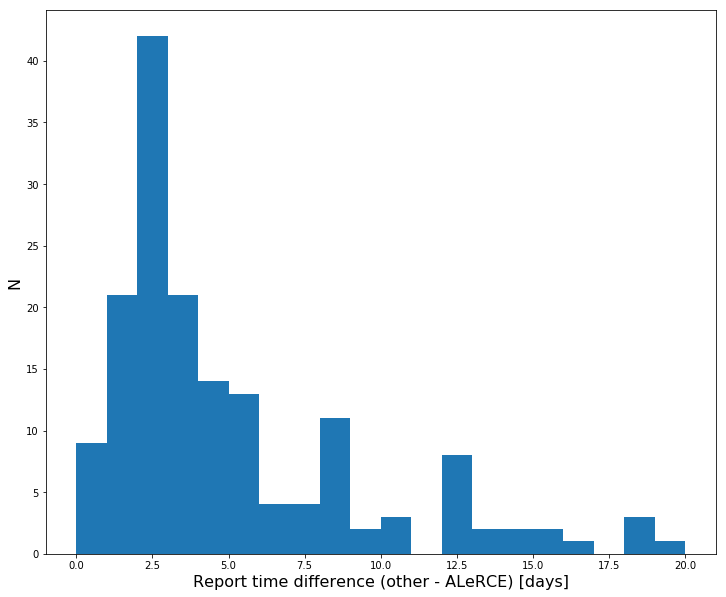

In [251]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.hist(dtALeRCE.values(), bins=np.linspace(0, 20, 21));
ax.set_xlabel("Report time difference (other - ALeRCE) [days]", fontsize=16);
ax.set_ylabel("N", fontsize=16)
plt.savefig("plots/Reportdiff.png")